In [1]:
import json
import pandas as pd
import optuna as op
import covasim as cv
import seaborn as sns
import matplotlib.pyplot as plt
from src import data, calibration, interventions

sns.set_context('notebook')
sns.set_style('whitegrid')

n_trials = 300

def plot_best(study, n_runs=30, figsize=(18, 8)):
    initial_params = {'pop_infected': study.best_params['pop_infected'], **default_params}
    intervs = interventions.get_calibration_interventions(study.best_params)
    sim = cv.Sim(pars=initial_params, interventions=intervs, datafile=df)
    msim = cv.MultiSim(sim)
    msim.run(n_runs=n_runs)
    msim.mean()
    msim.plot(
        list(cols) + ['n_infectious', 'n_susceptible'],
        fig_args={'figsize': figsize},
        scatter_args={'s': 5},
        plot_args={'lw': 2},
        interval=45
    )

Covasim 2.0.3 (2021-03-11) — © 2021 by IDM


# Simulator Calibration

## Dataset & Default Parameters

As a first step, we retrieve the historical data about the evolution of the pandemic in Italy from the official [github repository](https://github.com/pcm-dpc/COVID-19/) of the  italian ministry, from which we keep just the records related to the region *Emilia-Romagna*.

> In our simulation, we are using 40k agents with a scaling factor of 10, for a total of 400k simulated people (roughly the population of the city of Bologna). Thus, when loading the data, we need to rescale them from the 4.46 million of people living in the region to our 400k population.

In the end, the extracted columns are:
* the daily number of *tests*, which will be used in the respective intervention
* the number of *severe cases* and *critical cases* at each day
* the cumulative number of *diagnosed* cases, i.e., the people who are known to be positive
* the cumulative number of *deaths*

In [2]:
pop_size = 400e3
pop_scale = 10
cols = ['n_severe', 'n_critical', 'cum_diagnoses', 'cum_deaths']
df = data.get_regional_data(scaling_factor=4.46e6/pop_size)

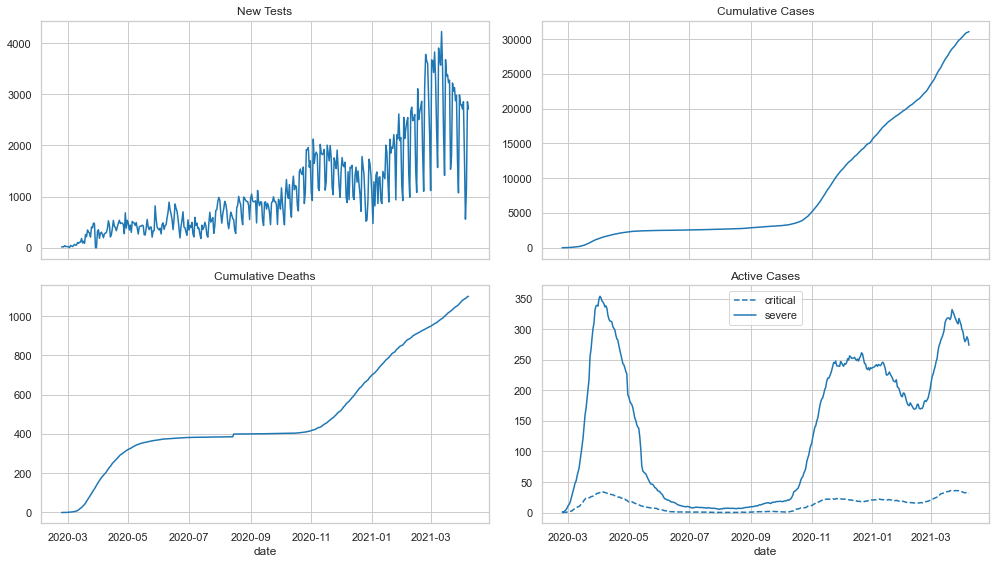

In [3]:
_, axes = plt.subplots(2, 2, figsize=(14, 8), sharex='all')
sns.lineplot(data=df, x='date', y='new_tests', ax=axes[0, 0]).set(title='New Tests', ylabel='')
sns.lineplot(data=df, x='date', y='cum_diagnoses', ax=axes[0, 1]).set(title='Cumulative Cases', ylabel='')
sns.lineplot(data=df, x='date', y='cum_deaths', ax=axes[1, 0]).set(title='Cumulative Deaths', ylabel='')
sns.lineplot(data=df, x='date', y='n_critical', label='critical', color='#1f77b4', linestyle='--', ax=axes[1, 1])
sns.lineplot(data=df, x='date', y='n_severe', label='severe', ax=axes[1, 1]).set(title='Active Cases', ylabel='')
plt.tight_layout()

In [4]:
default_params = dict(
    pop_type='hybrid',
    location='italy',
    start_day=df['date'].iloc[0],
    end_day=df['date'].iloc[-1],
    pop_size=pop_size / pop_scale,
    pop_scale=pop_scale,
    rescale=True,
    n_beds_hosp=pop_size * 370.4 / 100e3,
    n_beds_icu=pop_size * 14.46 / 100e3,
    quar_period=14,
    verbose=0
)

## Calibration #1: An Initial Approach

In this first approach, we want to learn the parameters for the *six interventions* that we put in our model, plus an initial parameter for the *number of initial infected individuals*. These parameters are:
1. the *contact tracing probability* and *contact tracing delay* for the `work` and `school` layers
  * we suppose them to be almost equal, thus we decide to learn a single parameter for both of them
  * the probability for the `household` layer is 100%, with no delay, while that for the `casual` layer is 0%
2. the relative number of *work contacts* in yellow, orange, and red zone
3. the relative number of *school contacts* in yellow and orange zone
  * this value is fixed to 0% during both summer period and red zone
4. the relative number of *casual contacts* in yellow, orange, and red zone, respectively
5. the absolute number of *imported cases* at the beginning of the simulation and in yellow, orange, and red zone
  * the number of imported cases during the summer period is the same one of the beginning
6. the absolute *beta* per symptomatic contact at the beginning of the simulation, during the late spring/summer period, and during the subsequent fall/winter period until today
  * this value is the result of both behavioural and environmental factors such as social distancing norms, masks, climate, variants, etc. 

We define our parameters using Optuna's method *suggest_\<type\>*, keeping the bounds as large as possible. These parameters are then passed to our util function to extract the correct list of interventions, which is eventually passed to a *Sim* object from which we calculate the final loss leveraging the default *compute_fit* method from covasim, using as ground truth the *severe* and *critical* columns only.

In [5]:
def objective(trial):
    # define learnable parameters
    initial_params = dict(pop_infected=trial.suggest_int('pop_infected', pop_size // 1e4, pop_size // 1e2), **default_params)
    intervention_params = dict(
        trace_prob=trial.suggest_float('trace_prob', 0.0, 1.0),                         # CONTACT TRACING
        trace_time=trial.suggest_float('trace_time', 0.0, 10.0),                        #
        yellow_work_contacts=trial.suggest_float('yellow_work_contacts', 0.0, 1.0),     # SMART WORKING
        orange_work_contacts=trial.suggest_float('orange_work_contacts', 0.0, 1.0),     #
        red_work_contacts=trial.suggest_float('red_work_contacts', 0.0, 1.0),           #
        yellow_school_contacts=trial.suggest_float('yellow_school_contacts', 0.0, 1.0), # SCHOOLS CLOSED
        orange_school_contacts=trial.suggest_float('orange_school_contacts', 0.0, 1.0), #
        yellow_casual_contacts=trial.suggest_float('yellow_casual_contacts', 0.0, 1.0), # LOCKDOWN INTERACTIONS
        orange_casual_contacts=trial.suggest_float('orange_casual_contacts', 0.0, 1.0), #
        red_casual_contacts=trial.suggest_float('red_casual_contacts', 0.0, 1.0),       #
        init_imports=trial.suggest_float('init_imports', 0.0, 20.0),                    # IMPORTED CASES
        yellow_imports=trial.suggest_float('yellow_imports', 4.0, 12.0),                #
        orange_imports=trial.suggest_float('orange_imports', 2.0, 8.0),                 #
        red_imports=trial.suggest_float('red_imports', 0.0, 4.0),                       #
        init_beta=trial.suggest_float('init_beta', 0.0, 0.2),                           # BETA CHANGE
        summer_beta=trial.suggest_float('summer_beta', 0.0, 0.2),                       #
        winter_beta=trial.suggest_float('winter_beta', 0.0, 0.2)                        #
    )
    # define and run simulations, then return loss
    intervs = interventions.get_calibration_interventions(intervention_params)
    sim = cv.Sim(pars=initial_params, interventions=intervs, datafile=df)
    sim.run()
    return sim.compute_fit(keys=['n_severe', 'n_critical'], weights={'n_severe': 1, 'n_critical': 1}).mismatch

We are now ready to start the optimization phase:
* firstly, we create a *study* object from optuna
* secondly, we call its *optimize* method, to which we pass
   * the routine to compute the objective function based on the selected values
   * another argument that indicates how many trials to run (300 in our case)

In [6]:
study = op.create_study()
study.optimize(func=objective, n_trials=n_trials)

[I 2021-04-09 04:03:00,082] A new study created in memory with name: no-name-70a3ec42-7368-4504-9265-53fe6f13b547
[I 2021-04-09 04:03:06,725] Trial 0 finished with value: 3779.111390829298 and parameters: {'pop_infected': 2106, 'trace_prob': 0.8903568461427592, 'trace_time': 3.2671099818436122, 'yellow_work_contacts': 0.022938404945001434, 'orange_work_contacts': 0.7070949981422936, 'red_work_contacts': 0.183894999130788, 'yellow_school_contacts': 0.7324877597817914, 'orange_school_contacts': 0.5109304059863515, 'yellow_casual_contacts': 0.6348550616267538, 'orange_casual_contacts': 0.7565040525875926, 'red_casual_contacts': 0.17999092988242316, 'init_imports': 7.906167407632521, 'yellow_imports': 5.167012595260125, 'orange_imports': 6.51993550762938, 'red_imports': 3.0592684063580835, 'init_beta': 0.09687105921980861, 'summer_beta': 0.13511081988738805, 'winter_beta': 0.05999208951933732}. Best is trial 0 with value: 3779.111390829298.
[I 2021-04-09 04:03:12,918] Trial 1 finished with

[I 2021-04-09 04:04:06,689] Trial 10 finished with value: 4199.099812143228 and parameters: {'pop_infected': 3940, 'trace_prob': 0.039222878293353844, 'trace_time': 0.20334812806583802, 'yellow_work_contacts': 0.6710555423434768, 'orange_work_contacts': 0.094239065347753, 'red_work_contacts': 0.9995038385873395, 'yellow_school_contacts': 0.9767478220975804, 'orange_school_contacts': 0.6243445807097586, 'yellow_casual_contacts': 0.2232811016024948, 'orange_casual_contacts': 0.43806377973767496, 'red_casual_contacts': 0.3540444247436492, 'init_imports': 4.697196532546587, 'yellow_imports': 9.681385369912089, 'orange_imports': 7.652134332177612, 'red_imports': 1.1324529737520201, 'init_beta': 0.013470617291650722, 'summer_beta': 4.6259024815732686e-05, 'winter_beta': 0.11315180989258466}. Best is trial 8 with value: 2781.312102692389.
[I 2021-04-09 04:04:12,622] Trial 11 finished with value: 4373.1740372680215 and parameters: {'pop_infected': 3936, 'trace_prob': 0.7451347389809494, 'trace

[I 2021-04-09 04:05:06,463] Trial 20 finished with value: 3407.548722692471 and parameters: {'pop_infected': 1539, 'trace_prob': 0.005560907828670074, 'trace_time': 0.673615341238022, 'yellow_work_contacts': 0.5980798222563156, 'orange_work_contacts': 0.2307073587544134, 'red_work_contacts': 0.8387515231934884, 'yellow_school_contacts': 0.8682310980037781, 'orange_school_contacts': 0.6566707318368381, 'yellow_casual_contacts': 0.8494942005892792, 'orange_casual_contacts': 0.9077755524229251, 'red_casual_contacts': 0.27799441405351194, 'init_imports': 5.1100312731269755, 'yellow_imports': 9.166852839061256, 'orange_imports': 5.702457694228109, 'red_imports': 0.748857276520555, 'init_beta': 0.03679154122293274, 'summer_beta': 0.0003267445612458453, 'winter_beta': 0.1503986851255928}. Best is trial 8 with value: 2781.312102692389.
[I 2021-04-09 04:05:13,018] Trial 21 finished with value: 3585.087337978739 and parameters: {'pop_infected': 1701, 'trace_prob': 0.0018281937649692699, 'trace_t

[I 2021-04-09 04:06:08,871] Trial 30 finished with value: 4295.102198043131 and parameters: {'pop_infected': 3725, 'trace_prob': 0.14172441389490167, 'trace_time': 0.02773805559704412, 'yellow_work_contacts': 0.3196784556502854, 'orange_work_contacts': 0.23881072510108456, 'red_work_contacts': 0.5308015738407929, 'yellow_school_contacts': 0.6050577467635098, 'orange_school_contacts': 0.18724942487657964, 'yellow_casual_contacts': 0.3026541481354493, 'orange_casual_contacts': 0.5649052096240241, 'red_casual_contacts': 0.9975036891241904, 'init_imports': 11.895691871246468, 'yellow_imports': 5.947716898478678, 'orange_imports': 4.7812291348974965, 'red_imports': 0.8378677949579677, 'init_beta': 0.04806500058238523, 'summer_beta': 0.07012987203326063, 'winter_beta': 0.10020540909522177}. Best is trial 8 with value: 2781.312102692389.
[I 2021-04-09 04:06:14,932] Trial 31 finished with value: 4220.887901978003 and parameters: {'pop_infected': 2120, 'trace_prob': 0.007553821169130736, 'trace

[I 2021-04-09 04:07:13,674] Trial 40 finished with value: 2957.86260711857 and parameters: {'pop_infected': 388, 'trace_prob': 0.12839390834617845, 'trace_time': 3.3803718159357667, 'yellow_work_contacts': 0.24504644385967758, 'orange_work_contacts': 0.5482205344242177, 'red_work_contacts': 0.8280164472046478, 'yellow_school_contacts': 0.42837702410702894, 'orange_school_contacts': 0.4874848898610007, 'yellow_casual_contacts': 0.7826302542205335, 'orange_casual_contacts': 0.9182614016902912, 'red_casual_contacts': 0.22774540584305497, 'init_imports': 3.6705508146633354, 'yellow_imports': 11.38234601479762, 'orange_imports': 2.653673046828358, 'red_imports': 0.2038868593503188, 'init_beta': 0.03619309585893213, 'summer_beta': 0.04464980045715394, 'winter_beta': 0.023454966381604797}. Best is trial 8 with value: 2781.312102692389.
[I 2021-04-09 04:07:23,479] Trial 41 finished with value: 3040.3398962342753 and parameters: {'pop_infected': 66, 'trace_prob': 0.13142276088376498, 'trace_tim

[I 2021-04-09 04:08:30,461] Trial 50 finished with value: 2873.247675127896 and parameters: {'pop_infected': 255, 'trace_prob': 0.300796231876266, 'trace_time': 5.517697274939401, 'yellow_work_contacts': 0.17881792781997577, 'orange_work_contacts': 0.9792544750987333, 'red_work_contacts': 0.9507147127879638, 'yellow_school_contacts': 0.0291158631977756, 'orange_school_contacts': 0.07120986460039214, 'yellow_casual_contacts': 0.3811369480596972, 'orange_casual_contacts': 0.47258625134933124, 'red_casual_contacts': 0.06528855477482623, 'init_imports': 1.2916641131210584, 'yellow_imports': 11.815366089616338, 'orange_imports': 2.350442156755286, 'red_imports': 0.4955097167286546, 'init_beta': 0.07487402588404606, 'summer_beta': 0.031123155103932133, 'winter_beta': 0.040506354553449433}. Best is trial 42 with value: 2469.54112502226.
[I 2021-04-09 04:08:37,075] Trial 51 finished with value: 3136.4714039830155 and parameters: {'pop_infected': 220, 'trace_prob': 0.29734957724342925, 'trace_t

[I 2021-04-09 04:09:33,223] Trial 60 finished with value: 2510.5172168194727 and parameters: {'pop_infected': 752, 'trace_prob': 0.6494141487265415, 'trace_time': 3.984870998306365, 'yellow_work_contacts': 0.1811135117715319, 'orange_work_contacts': 0.8983667476297345, 'red_work_contacts': 0.6731486896413493, 'yellow_school_contacts': 0.24350666780225338, 'orange_school_contacts': 0.008801668206401325, 'yellow_casual_contacts': 0.05165911075708612, 'orange_casual_contacts': 0.3349728114265397, 'red_casual_contacts': 0.009450535831394208, 'init_imports': 5.72428720343338, 'yellow_imports': 11.399954188933766, 'orange_imports': 2.1399808734524073, 'red_imports': 2.424228040352873, 'init_beta': 0.0665467322144091, 'summer_beta': 0.054019751391096854, 'winter_beta': 0.08886694807580653}. Best is trial 57 with value: 2405.045683337832.
[I 2021-04-09 04:09:39,601] Trial 61 finished with value: 2394.176860191057 and parameters: {'pop_infected': 459, 'trace_prob': 0.6659337969875391, 'trace_ti

[I 2021-04-09 04:10:36,722] Trial 70 finished with value: 2727.7948329502237 and parameters: {'pop_infected': 413, 'trace_prob': 0.844385244489212, 'trace_time': 5.359558753350984, 'yellow_work_contacts': 0.14604626040008845, 'orange_work_contacts': 0.7285412343440499, 'red_work_contacts': 0.7578976078137869, 'yellow_school_contacts': 0.2693821442875092, 'orange_school_contacts': 0.15995085562820005, 'yellow_casual_contacts': 0.09393874946940475, 'orange_casual_contacts': 0.3943056048411704, 'red_casual_contacts': 0.040318424645145394, 'init_imports': 4.122535665756022, 'yellow_imports': 11.540667135990935, 'orange_imports': 3.671236944042808, 'red_imports': 2.618215380201559, 'init_beta': 0.08315226588848762, 'summer_beta': 0.03125045365276733, 'winter_beta': 0.05150673591462938}. Best is trial 62 with value: 2332.701683992924.
[I 2021-04-09 04:10:42,957] Trial 71 finished with value: 2576.6766397156325 and parameters: {'pop_infected': 739, 'trace_prob': 0.6923609417222388, 'trace_tim

[I 2021-04-09 04:11:38,853] Trial 80 finished with value: 3837.731815448426 and parameters: {'pop_infected': 435, 'trace_prob': 0.46473988102533265, 'trace_time': 5.172479136320544, 'yellow_work_contacts': 0.4746469219688332, 'orange_work_contacts': 0.8276441381570889, 'red_work_contacts': 0.7612854523420561, 'yellow_school_contacts': 0.47214965883255877, 'orange_school_contacts': 0.10803274261542237, 'yellow_casual_contacts': 0.2708380828301368, 'orange_casual_contacts': 0.15341856289203032, 'red_casual_contacts': 0.5271863677909621, 'init_imports': 8.428683488394288, 'yellow_imports': 11.494330267246905, 'orange_imports': 2.118817842047594, 'red_imports': 3.183293177057292, 'init_beta': 0.05077599045217106, 'summer_beta': 0.07477084702586799, 'winter_beta': 0.06372501209026282}. Best is trial 62 with value: 2332.701683992924.
[I 2021-04-09 04:11:45,116] Trial 81 finished with value: 2690.2117897449803 and parameters: {'pop_infected': 509, 'trace_prob': 0.5683331556724525, 'trace_time

[I 2021-04-09 04:12:41,162] Trial 90 finished with value: 2970.739582855528 and parameters: {'pop_infected': 1050, 'trace_prob': 0.6221621634324116, 'trace_time': 3.9833586244703176, 'yellow_work_contacts': 0.1645924002653522, 'orange_work_contacts': 0.9988808331146137, 'red_work_contacts': 0.6136238315353784, 'yellow_school_contacts': 0.31825067830397485, 'orange_school_contacts': 0.3680269814288479, 'yellow_casual_contacts': 0.0450035812170642, 'orange_casual_contacts': 0.3814221393390247, 'red_casual_contacts': 0.05744632753130049, 'init_imports': 3.068807401923989, 'yellow_imports': 10.948031949533435, 'orange_imports': 2.005320129285874, 'red_imports': 2.3983218011747187, 'init_beta': 0.056766671749866764, 'summer_beta': 0.08295174276407433, 'winter_beta': 0.049636899927362824}. Best is trial 62 with value: 2332.701683992924.
[I 2021-04-09 04:12:47,448] Trial 91 finished with value: 2594.56714405044 and parameters: {'pop_infected': 520, 'trace_prob': 0.718720646477749, 'trace_time

[I 2021-04-09 04:13:46,286] Trial 100 finished with value: 1825.1565400769318 and parameters: {'pop_infected': 46, 'trace_prob': 0.8047378133380911, 'trace_time': 6.265422067054554, 'yellow_work_contacts': 0.10250573404332924, 'orange_work_contacts': 0.8133707848643005, 'red_work_contacts': 0.736757146133816, 'yellow_school_contacts': 0.5979226541990368, 'orange_school_contacts': 0.024333327178269422, 'yellow_casual_contacts': 0.26595444601082807, 'orange_casual_contacts': 0.14305894149909895, 'red_casual_contacts': 0.09938873388964216, 'init_imports': 1.3053396533192827, 'yellow_imports': 11.820642397825257, 'orange_imports': 3.563460894648241, 'red_imports': 2.0342251833141414, 'init_beta': 0.03369527185947226, 'summer_beta': 0.0015714167697859181, 'winter_beta': 0.04718005354355812}. Best is trial 100 with value: 1825.1565400769318.
[I 2021-04-09 04:13:52,492] Trial 101 finished with value: 1948.5432435499145 and parameters: {'pop_infected': 54, 'trace_prob': 0.8361599908882104, 'tr

[I 2021-04-09 04:14:49,115] Trial 110 finished with value: 280.47140530713574 and parameters: {'pop_infected': 243, 'trace_prob': 0.9585750552368102, 'trace_time': 8.286201691379457, 'yellow_work_contacts': 0.05990678920378474, 'orange_work_contacts': 0.626398893895435, 'red_work_contacts': 0.7438063589048867, 'yellow_school_contacts': 0.6891944314510483, 'orange_school_contacts': 0.08405375256061863, 'yellow_casual_contacts': 0.24844899776748564, 'orange_casual_contacts': 0.08094326643546698, 'red_casual_contacts': 0.3296689278944237, 'init_imports': 0.12857690898629945, 'yellow_imports': 10.992262208494143, 'orange_imports': 4.844404489886435, 'red_imports': 1.3793698462516413, 'init_beta': 0.008301434139183517, 'summer_beta': 0.001763508550980858, 'winter_beta': 0.012833570077195586}. Best is trial 109 with value: 265.1053684386869.
[I 2021-04-09 04:14:54,920] Trial 111 finished with value: 283.70301993934993 and parameters: {'pop_infected': 279, 'trace_prob': 0.9476782381076497, 't

[I 2021-04-09 04:15:47,785] Trial 120 finished with value: 287.41007424843326 and parameters: {'pop_infected': 277, 'trace_prob': 0.9573459104861435, 'trace_time': 8.258878223671541, 'yellow_work_contacts': 0.07106722871006588, 'orange_work_contacts': 0.5988568190195994, 'red_work_contacts': 0.6602066865047528, 'yellow_school_contacts': 0.6999750150303069, 'orange_school_contacts': 0.08118650584550313, 'yellow_casual_contacts': 0.3004359392057918, 'orange_casual_contacts': 0.0022245193166764788, 'red_casual_contacts': 0.3234997103000857, 'init_imports': 0.02239799801682652, 'yellow_imports': 10.698207580344398, 'orange_imports': 4.987162437173345, 'red_imports': 1.3804187752372232, 'init_beta': 0.006745153987105821, 'summer_beta': 0.0072523073915963, 'winter_beta': 0.006563314360460609}. Best is trial 109 with value: 265.1053684386869.
[I 2021-04-09 04:15:53,667] Trial 121 finished with value: 283.1228521237625 and parameters: {'pop_infected': 285, 'trace_prob': 0.9632625508469437, 'tr

[I 2021-04-09 04:16:50,369] Trial 130 finished with value: 3404.5742850070237 and parameters: {'pop_infected': 180, 'trace_prob': 0.9440666623576242, 'trace_time': 7.850806500186055, 'yellow_work_contacts': 0.025196014221791165, 'orange_work_contacts': 0.559682351446096, 'red_work_contacts': 0.5579137814559093, 'yellow_school_contacts': 0.7836325812911198, 'orange_school_contacts': 0.12563366521613645, 'yellow_casual_contacts': 0.21680236085848714, 'orange_casual_contacts': 0.0016255230993106363, 'red_casual_contacts': 0.2882694565927577, 'init_imports': 0.3907042419921684, 'yellow_imports': 10.22381082682903, 'orange_imports': 4.889836501511024, 'red_imports': 1.4751434708047446, 'init_beta': 0.012073052675492477, 'summer_beta': 0.020223345429613616, 'winter_beta': 0.022848799855082397}. Best is trial 122 with value: 246.05561325481395.
[I 2021-04-09 04:16:56,562] Trial 131 finished with value: 279.3488714217957 and parameters: {'pop_infected': 325, 'trace_prob': 0.9546415742298557, '

[I 2021-04-09 04:17:54,569] Trial 140 finished with value: 3017.7804517712957 and parameters: {'pop_infected': 178, 'trace_prob': 0.9941948103844992, 'trace_time': 9.063427678263862, 'yellow_work_contacts': 0.0008457702290849828, 'orange_work_contacts': 0.5267614311152999, 'red_work_contacts': 0.6471373184081437, 'yellow_school_contacts': 0.6509891232674553, 'orange_school_contacts': 0.15547659298903144, 'yellow_casual_contacts': 0.35883891754130676, 'orange_casual_contacts': 0.061639682868300225, 'red_casual_contacts': 0.23765468455253874, 'init_imports': 14.649253141053007, 'yellow_imports': 9.786106751207305, 'orange_imports': 4.954615767648582, 'red_imports': 1.1991447586142059, 'init_beta': 0.014833881399258123, 'summer_beta': 0.016778422617340662, 'winter_beta': 0.017892050059190635}. Best is trial 134 with value: 228.32735724968808.
[I 2021-04-09 04:18:00,110] Trial 141 finished with value: 291.7808413560998 and parameters: {'pop_infected': 311, 'trace_prob': 0.9670317065977962,

[I 2021-04-09 04:18:56,300] Trial 150 finished with value: 254.83101743834172 and parameters: {'pop_infected': 157, 'trace_prob': 0.9172448869990723, 'trace_time': 8.69645263259479, 'yellow_work_contacts': 0.1280535468442287, 'orange_work_contacts': 0.640579585286517, 'red_work_contacts': 0.5888883745235084, 'yellow_school_contacts': 0.7691364982086445, 'orange_school_contacts': 0.3474885417999432, 'yellow_casual_contacts': 0.2244391350780915, 'orange_casual_contacts': 0.039068054705855636, 'red_casual_contacts': 0.22669571890768075, 'init_imports': 0.495778215992231, 'yellow_imports': 10.497181565799723, 'orange_imports': 4.388785632032167, 'red_imports': 1.5174705231810675, 'init_beta': 0.011870209300074016, 'summer_beta': 0.00015160180090745897, 'winter_beta': 0.014797831420911518}. Best is trial 143 with value: 205.21872592566086.
[I 2021-04-09 04:19:02,036] Trial 151 finished with value: 4633.015176115035 and parameters: {'pop_infected': 142, 'trace_prob': 0.9188964729235797, 'tra

[I 2021-04-09 04:19:58,914] Trial 160 finished with value: 681.4386920250031 and parameters: {'pop_infected': 386, 'trace_prob': 0.8822135455315535, 'trace_time': 8.691364587466225, 'yellow_work_contacts': 0.1495056691994846, 'orange_work_contacts': 0.6690516131988401, 'red_work_contacts': 0.6782466787448904, 'yellow_school_contacts': 0.8242550090738855, 'orange_school_contacts': 0.3167954431517658, 'yellow_casual_contacts': 0.16363180499368885, 'orange_casual_contacts': 0.03175340050336042, 'red_casual_contacts': 0.16253826310078467, 'init_imports': 1.3567510902861144, 'yellow_imports': 8.61610565487903, 'orange_imports': 4.136859286423448, 'red_imports': 1.5294844751488714, 'init_beta': 0.012640439023864629, 'summer_beta': 0.0051982778405281925, 'winter_beta': 0.026064802265188265}. Best is trial 154 with value: 189.46784510057446.
[I 2021-04-09 04:20:05,057] Trial 161 finished with value: 262.7623291368916 and parameters: {'pop_infected': 187, 'trace_prob': 0.9296166353061692, 'trac

[I 2021-04-09 04:21:01,944] Trial 170 finished with value: 3437.7228483481813 and parameters: {'pop_infected': 131, 'trace_prob': 0.9938546055492663, 'trace_time': 8.867251875582289, 'yellow_work_contacts': 0.1134741819810649, 'orange_work_contacts': 0.6785620795123436, 'red_work_contacts': 0.48857127803174416, 'yellow_school_contacts': 0.7232008099600366, 'orange_school_contacts': 0.29040079365575366, 'yellow_casual_contacts': 0.17727899999991725, 'orange_casual_contacts': 0.1002923226787181, 'red_casual_contacts': 0.29489525815942713, 'init_imports': 2.158096780463477, 'yellow_imports': 10.202708844812909, 'orange_imports': 4.624640409824583, 'red_imports': 1.5449543453153631, 'init_beta': 0.012266420827355498, 'summer_beta': 0.0199483267355705, 'winter_beta': 0.020187969086972797}. Best is trial 154 with value: 189.46784510057446.
[I 2021-04-09 04:21:08,086] Trial 171 finished with value: 265.0662062756562 and parameters: {'pop_infected': 192, 'trace_prob': 0.9792040209359164, 'trac

[I 2021-04-09 04:22:05,140] Trial 180 finished with value: 234.18657601487217 and parameters: {'pop_infected': 388, 'trace_prob': 0.8989128763173662, 'trace_time': 7.741582664219716, 'yellow_work_contacts': 0.17610260543795203, 'orange_work_contacts': 0.7093109627326787, 'red_work_contacts': 0.5509261093762075, 'yellow_school_contacts': 0.8675484231252227, 'orange_school_contacts': 0.30670387573082986, 'yellow_casual_contacts': 0.2515196075761529, 'orange_casual_contacts': 0.060882046160977435, 'red_casual_contacts': 0.17310120515541358, 'init_imports': 1.2833231940117535, 'yellow_imports': 9.280502901738771, 'orange_imports': 4.506789812588697, 'red_imports': 1.4889013488977587, 'init_beta': 0.011060727155863587, 'summer_beta': 0.0035044801082143506, 'winter_beta': 0.012649409522178537}. Best is trial 154 with value: 189.46784510057446.
[I 2021-04-09 04:22:11,234] Trial 181 finished with value: 252.25904328628906 and parameters: {'pop_infected': 403, 'trace_prob': 0.8976647095750823, 

[I 2021-04-09 04:23:08,899] Trial 190 finished with value: 2941.5012050500914 and parameters: {'pop_infected': 462, 'trace_prob': 0.7862227081821455, 'trace_time': 8.046998667983473, 'yellow_work_contacts': 0.17494869776650734, 'orange_work_contacts': 0.7624070460971414, 'red_work_contacts': 0.5832142186205729, 'yellow_school_contacts': 0.9205982786753876, 'orange_school_contacts': 0.5128564154177494, 'yellow_casual_contacts': 0.25788757226392406, 'orange_casual_contacts': 0.14134321444693104, 'red_casual_contacts': 0.46727806165692487, 'init_imports': 1.4806984808761148, 'yellow_imports': 9.374156101544743, 'orange_imports': 5.2310424647762535, 'red_imports': 1.6499337772944105, 'init_beta': 0.028912840132520254, 'summer_beta': 0.0093351048261909, 'winter_beta': 0.007783387058432883}. Best is trial 154 with value: 189.46784510057446.
[I 2021-04-09 04:23:14,899] Trial 191 finished with value: 207.77810912528787 and parameters: {'pop_infected': 348, 'trace_prob': 0.8956105140605044, 'tr

[I 2021-04-09 04:24:10,997] Trial 200 finished with value: 278.4154105365667 and parameters: {'pop_infected': 345, 'trace_prob': 0.881016318445523, 'trace_time': 8.107685551410311, 'yellow_work_contacts': 0.16505217966344105, 'orange_work_contacts': 0.7318631513131841, 'red_work_contacts': 0.5352272536148214, 'yellow_school_contacts': 0.9365571976000104, 'orange_school_contacts': 0.3544221028779216, 'yellow_casual_contacts': 0.16764739754163996, 'orange_casual_contacts': 0.0019952896269747056, 'red_casual_contacts': 0.20444307068409157, 'init_imports': 0.7293803189919759, 'yellow_imports': 9.625282323475258, 'orange_imports': 5.259822284395359, 'red_imports': 1.4343847480237424, 'init_beta': 0.003908351883763626, 'summer_beta': 0.00046119932419762407, 'winter_beta': 0.014375400122954794}. Best is trial 154 with value: 189.46784510057446.
[I 2021-04-09 04:24:17,626] Trial 201 finished with value: 772.0146546998313 and parameters: {'pop_infected': 386, 'trace_prob': 0.8409400897852866, '

[I 2021-04-09 04:25:14,229] Trial 210 finished with value: 203.2025392931851 and parameters: {'pop_infected': 570, 'trace_prob': 0.80442033868719, 'trace_time': 8.107102473259951, 'yellow_work_contacts': 0.1877759034557205, 'orange_work_contacts': 0.7377142205779359, 'red_work_contacts': 0.6238792523622932, 'yellow_school_contacts': 0.8868480589508295, 'orange_school_contacts': 0.43647072835302425, 'yellow_casual_contacts': 0.18050374026928534, 'orange_casual_contacts': 0.04828194038039637, 'red_casual_contacts': 0.24905343943279065, 'init_imports': 2.966605747704415, 'yellow_imports': 9.641671145212971, 'orange_imports': 5.22375012581771, 'red_imports': 1.1678989799514152, 'init_beta': 0.012590213198082914, 'summer_beta': 0.0003010283171743927, 'winter_beta': 0.009148230094525575}. Best is trial 154 with value: 189.46784510057446.
[I 2021-04-09 04:25:20,713] Trial 211 finished with value: 324.49299731124944 and parameters: {'pop_infected': 566, 'trace_prob': 0.8038772434760402, 'trace

[I 2021-04-09 04:26:19,149] Trial 220 finished with value: 530.2752790480383 and parameters: {'pop_infected': 680, 'trace_prob': 0.8774961640569016, 'trace_time': 8.216790313156954, 'yellow_work_contacts': 0.2219123804070005, 'orange_work_contacts': 0.7171690628327755, 'red_work_contacts': 0.6079193176572851, 'yellow_school_contacts': 0.8736868240511791, 'orange_school_contacts': 0.3798309598175462, 'yellow_casual_contacts': 0.21154316035021856, 'orange_casual_contacts': 0.07085605544781443, 'red_casual_contacts': 0.19911220721671313, 'init_imports': 2.2284764463290143, 'yellow_imports': 10.05074132895461, 'orange_imports': 5.294219232456321, 'red_imports': 1.1055957584989335, 'init_beta': 0.018537677542389153, 'summer_beta': 0.00023468473628215122, 'winter_beta': 0.018299781660771966}. Best is trial 213 with value: 188.30677395189196.
[I 2021-04-09 04:26:25,568] Trial 221 finished with value: 214.04377779221477 and parameters: {'pop_infected': 473, 'trace_prob': 0.8475689380403749, 't

[I 2021-04-09 04:27:24,153] Trial 230 finished with value: 299.94980270246674 and parameters: {'pop_infected': 449, 'trace_prob': 0.8156656426091159, 'trace_time': 7.987386052697882, 'yellow_work_contacts': 0.23437347705628278, 'orange_work_contacts': 0.7718082205766801, 'red_work_contacts': 0.6628676774901042, 'yellow_school_contacts': 0.9289040044899256, 'orange_school_contacts': 0.36712364669478115, 'yellow_casual_contacts': 0.17921122176285487, 'orange_casual_contacts': 0.09686400980748543, 'red_casual_contacts': 0.2868021547036762, 'init_imports': 2.765788683808076, 'yellow_imports': 9.556085664344344, 'orange_imports': 5.097852884180368, 'red_imports': 0.8358862878572004, 'init_beta': 0.005080904243456809, 'summer_beta': 7.62298701804628e-05, 'winter_beta': 0.02256130243105696}. Best is trial 213 with value: 188.30677395189196.
[I 2021-04-09 04:27:30,488] Trial 231 finished with value: 588.3164697582273 and parameters: {'pop_infected': 585, 'trace_prob': 0.762815319045926, 'trace

[I 2021-04-09 04:28:27,945] Trial 240 finished with value: 4354.6367815985695 and parameters: {'pop_infected': 616, 'trace_prob': 0.7872106467510632, 'trace_time': 8.057926351709863, 'yellow_work_contacts': 0.19234621296304685, 'orange_work_contacts': 0.725711901130068, 'red_work_contacts': 0.6347775221456985, 'yellow_school_contacts': 0.8779686401516685, 'orange_school_contacts': 0.38665664766298363, 'yellow_casual_contacts': 0.16598515346466539, 'orange_casual_contacts': 0.06833881571220018, 'red_casual_contacts': 0.5830744609054276, 'init_imports': 3.379724696255088, 'yellow_imports': 7.571043056906229, 'orange_imports': 5.050722287267765, 'red_imports': 0.9974454771805348, 'init_beta': 0.14360468880538252, 'summer_beta': 0.007032677329561503, 'winter_beta': 0.022840502198863764}. Best is trial 233 with value: 173.31080293672113.
[I 2021-04-09 04:28:34,207] Trial 241 finished with value: 202.3374786028897 and parameters: {'pop_infected': 434, 'trace_prob': 0.8325174476302216, 'trace

[I 2021-04-09 04:29:30,751] Trial 250 finished with value: 1396.866478463251 and parameters: {'pop_infected': 601, 'trace_prob': 0.7376513291830192, 'trace_time': 8.614499077735587, 'yellow_work_contacts': 0.248431748428229, 'orange_work_contacts': 0.6949106309006873, 'red_work_contacts': 0.678055953528879, 'yellow_school_contacts': 0.989311014235853, 'orange_school_contacts': 0.3679187774290739, 'yellow_casual_contacts': 0.09139165810559449, 'orange_casual_contacts': 0.01045057117360277, 'red_casual_contacts': 0.21688542778171122, 'init_imports': 1.4599078628610258, 'yellow_imports': 7.300313511751187, 'orange_imports': 5.121073544932424, 'red_imports': 0.5991343286101474, 'init_beta': 0.02209710030283778, 'summer_beta': 0.0004590404258073182, 'winter_beta': 0.017960576321720774}. Best is trial 233 with value: 173.31080293672113.
[I 2021-04-09 04:29:37,208] Trial 251 finished with value: 408.32283858330345 and parameters: {'pop_infected': 543, 'trace_prob': 0.7652447076300164, 'trace_

[I 2021-04-09 04:30:34,692] Trial 260 finished with value: 1131.8690360868736 and parameters: {'pop_infected': 502, 'trace_prob': 0.8313129849752736, 'trace_time': 8.76962630865063, 'yellow_work_contacts': 0.31998371209036536, 'orange_work_contacts': 0.6612072351187916, 'red_work_contacts': 0.6528924365559404, 'yellow_school_contacts': 0.974430150787425, 'orange_school_contacts': 0.4038698843908881, 'yellow_casual_contacts': 0.1875340821042473, 'orange_casual_contacts': 0.12272673915457899, 'red_casual_contacts': 0.19108632436961492, 'init_imports': 12.415239539110063, 'yellow_imports': 7.4969940411250615, 'orange_imports': 4.896328134712055, 'red_imports': 0.979458918559528, 'init_beta': 0.013050119892143214, 'summer_beta': 1.492947259009586e-06, 'winter_beta': 0.019177835213692287}. Best is trial 233 with value: 173.31080293672113.
[I 2021-04-09 04:30:41,651] Trial 261 finished with value: 1931.7544089337089 and parameters: {'pop_infected': 2125, 'trace_prob': 0.7749025124361816, 'tr

[I 2021-04-09 04:31:40,011] Trial 270 finished with value: 395.68944264865786 and parameters: {'pop_infected': 678, 'trace_prob': 0.8130668730287435, 'trace_time': 8.426558809069272, 'yellow_work_contacts': 0.22176188117296566, 'orange_work_contacts': 0.6705216828732867, 'red_work_contacts': 0.617788059099734, 'yellow_school_contacts': 0.9196794156312551, 'orange_school_contacts': 0.37225817163260433, 'yellow_casual_contacts': 0.20858410552378823, 'orange_casual_contacts': 0.047527383523272175, 'red_casual_contacts': 0.18284848235022622, 'init_imports': 1.272577737386482, 'yellow_imports': 6.7724149682807875, 'orange_imports': 4.909423909745914, 'red_imports': 0.9848551537078701, 'init_beta': 0.016260467255939104, 'summer_beta': 0.00349724923840946, 'winter_beta': 0.017885364395911943}. Best is trial 233 with value: 173.31080293672113.
[I 2021-04-09 04:31:46,366] Trial 271 finished with value: 223.6294513685638 and parameters: {'pop_infected': 520, 'trace_prob': 0.8236762905776255, 'tr

[I 2021-04-09 04:32:41,718] Trial 280 finished with value: 266.58223479645665 and parameters: {'pop_infected': 555, 'trace_prob': 0.7235965344942124, 'trace_time': 9.024942581887016, 'yellow_work_contacts': 0.2955619188845203, 'orange_work_contacts': 0.7107780921625811, 'red_work_contacts': 0.7064339670628411, 'yellow_school_contacts': 0.9971179066289066, 'orange_school_contacts': 0.24001774336545192, 'yellow_casual_contacts': 0.050859885699424456, 'orange_casual_contacts': 0.2085825309084602, 'red_casual_contacts': 0.13267220133190966, 'init_imports': 1.1949791624520256, 'yellow_imports': 7.627059472564543, 'orange_imports': 4.648655536000601, 'red_imports': 0.7207544246040207, 'init_beta': 0.015381352193149227, 'summer_beta': 9.57091554906023e-05, 'winter_beta': 0.006488505410240262}. Best is trial 233 with value: 173.31080293672113.
[I 2021-04-09 04:32:48,149] Trial 281 finished with value: 991.5579668763686 and parameters: {'pop_infected': 654, 'trace_prob': 0.7951887057810988, 'tr

[I 2021-04-09 04:33:44,153] Trial 290 finished with value: 285.38272558354276 and parameters: {'pop_infected': 711, 'trace_prob': 0.7841778093116897, 'trace_time': 8.97389757594151, 'yellow_work_contacts': 0.3366466541737252, 'orange_work_contacts': 0.7458894441924928, 'red_work_contacts': 0.6993363092420698, 'yellow_school_contacts': 0.8943446539468517, 'orange_school_contacts': 0.2878411305570038, 'yellow_casual_contacts': 0.16733201398813405, 'orange_casual_contacts': 0.20603941514349108, 'red_casual_contacts': 0.1733436013183779, 'init_imports': 1.4860932874685204, 'yellow_imports': 7.9323794004002695, 'orange_imports': 5.471685309399646, 'red_imports': 0.7965606237653443, 'init_beta': 0.004152778561285201, 'summer_beta': 0.0001333580363721866, 'winter_beta': 0.00018836797329344068}. Best is trial 233 with value: 173.31080293672113.
[I 2021-04-09 04:33:50,680] Trial 291 finished with value: 2175.5853594815053 and parameters: {'pop_infected': 636, 'trace_prob': 0.745079786731713, 't

Once we have the results, we are able to inspect them. In order to do so, we get some statistics on the top 10% of the tried configurations in order to see how confident is the optimizer about each investigated parameter.

In [7]:
calibration.inspect_study(study, top=0.1)[1]

,count,min,max,mean,median,std,best
objective,30,173.310803,229.002102,208.692823,210.323226,13.024621,173.310803
pop_infected,30,235.000000,783.000000,511.266667,493.500000,119.743385,477.000000
trace_prob,30,0.730282,0.999870,0.833505,0.823402,0.066603,0.823127
trace_time,30,7.799708,8.966223,8.481052,8.453951,0.310548,8.602670
yellow_work_contacts,30,0.077537,0.351380,0.223683,0.224250,0.072061,0.202125
orange_work_contacts,30,0.629862,0.759605,0.714194,0.712260,0.030115,0.688493
red_work_contacts,30,0.517183,0.716435,0.643626,0.651012,0.044541,0.656168
yellow_school_contacts,30,0.574608,0.999344,0.889765,0.917522,0.117478,0.910866
orange_school_contacts,30,0.185228,0.438438,0.341666,0.359686,0.073021,0.391287
yellow_casual_contacts,30,0.017376,0.290176,0.171633,0.177482,0.060062,0.158916


Finally, we can plot the evolution (averaged over 30 runs) of the pandemic curves, i.e., number of *severe* and *critical* cases, and the number of the cumulative *diagnosed* and *dead* individuals, along with their respective ground truths. Additionally, the curves of *infectious* individuals and remaining *susceptibles* are plotted as well.

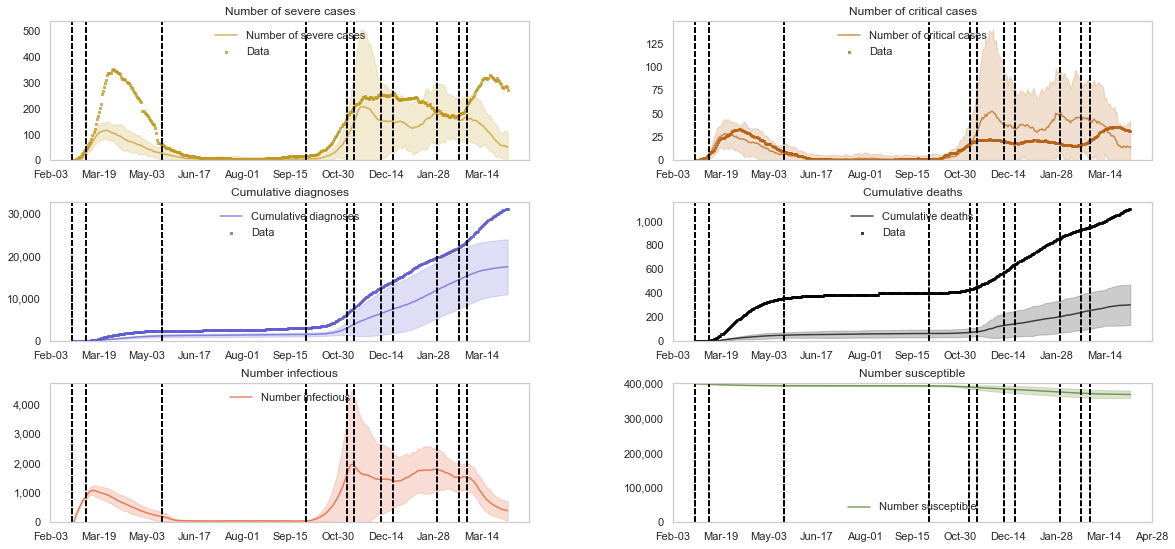

In [8]:
plot_best(study)

## Calibration #2: Death Column & Viral Load

While somehow able to catch the trend, the optimizer did not do a great job, in particular for the death column. Thus, from now on we will include this column as well in the set of ground truths to be optimized.

Additionally, we let the optimizer learn a new set of parameters involving the viral load of the virus.

> Ideally, this should allow the optimizer to fit all the three curves by giving them the correct scale. Moreover, as the viral load could have change during time depending on the season and other factors, we leave the degree of freedom to set these parameters for each of our *three macro-steps* (initial, summer, and winter periods), for a total of 12 new parameters.

We will now proceed with the same steps as before, but with these newly introduced parameters.

In [9]:
def get_calibration_params(trial):
    return dict(
        pop_infected=trial.suggest_int('pop_infected', pop_size // 1e4, pop_size // 1e2),
**default_params
    ), dict(
        trace_prob=trial.suggest_float('trace_prob', 0.0, 1.0),
        trace_time=trial.suggest_float('trace_time', 0.0, 10.0),
        yellow_work_contacts=trial.suggest_float('yellow_work_contacts', 0.0, 1.0),
        orange_work_contacts=trial.suggest_float('orange_work_contacts', 0.0, 1.0),
        red_work_contacts=trial.suggest_float('red_work_contacts', 0.0, 1.0),
        yellow_school_contacts=trial.suggest_float('yellow_school_contacts', 0.0, 1.0),
        orange_school_contacts=trial.suggest_float('orange_school_contacts', 0.0, 1.0),
        yellow_casual_contacts=trial.suggest_float('yellow_casual_contacts', 0.0, 1.0),
        orange_casual_contacts=trial.suggest_float('orange_casual_contacts', 0.0, 1.0),
        red_casual_contacts=trial.suggest_float('red_casual_contacts', 0.0, 1.0),
        init_imports=trial.suggest_float('init_imports', 0.0, 20.0),
        yellow_imports=trial.suggest_float('yellow_imports', 4.0, 12.0),
        orange_imports=trial.suggest_float('orange_imports', 2.0, 8.0),
        red_imports=trial.suggest_float('red_imports', 0.0, 4.0),
        init_beta=trial.suggest_float('init_beta', 0.0, 0.2),
        init_symp=trial.suggest_float('init_symp', 0.0, 10.0),
        init_sev=trial.suggest_float('init_sev', 0.0, 10.0),
        init_crit=trial.suggest_float('init_crit', 0.0, 10.0),
        init_death=trial.suggest_float('init_death', 0.0, 10.0),
        summer_beta=trial.suggest_float('summer_beta', 0.0, 0.2),
        summer_symp=trial.suggest_float('summer_symp', 0.0, 10.0),
        summer_sev=trial.suggest_float('summer_sev', 0.0, 10.0),
        summer_crit=trial.suggest_float('summer_crit', 0.0, 10.0),
        summer_death=trial.suggest_float('summer_death', 0.0, 10.0),
        winter_beta=trial.suggest_float('winter_beta', 0.0, 0.2),
        winter_symp=trial.suggest_float('winter_symp', 0.0, 10.0),
        winter_sev=trial.suggest_float('winter_sev', 0.0, 10.0),
        winter_crit=trial.suggest_float('winter_crit', 0.0, 10.0),
        winter_death=trial.suggest_float('winter_death', 0.0, 10.0)
    )

In [10]:
def objective(trial):
    # define learnable parameters
    initial_params, intervention_params = get_calibration_params(trial)
    # define and run simulations, then return loss
    intervs = interventions.get_calibration_interventions(intervention_params)
    sim = cv.Sim(pars=initial_params, interventions=intervs, datafile=df)
    sim.run()
    keys = ['n_severe', 'n_critical', 'cum_deaths']
    return sim.compute_fit(keys=keys, weights={k: 1 for k in keys}).mismatch

study = op.create_study()
study.optimize(func=objective, n_trials=n_trials)

[I 2021-04-09 04:36:06,383] A new study created in memory with name: no-name-769e3cb8-73bf-4524-955a-d11337cfe182
[I 2021-04-09 04:36:13,057] Trial 0 finished with value: 76811.57045309844 and parameters: {'pop_infected': 1721, 'trace_prob': 0.22984553418061093, 'trace_time': 2.5284336071994886, 'yellow_work_contacts': 0.43033280801769047, 'orange_work_contacts': 0.8175830217622423, 'red_work_contacts': 0.8330794388338224, 'yellow_school_contacts': 0.10490869845626916, 'orange_school_contacts': 0.13473061991228774, 'yellow_casual_contacts': 0.1757626074481209, 'orange_casual_contacts': 0.07038901983682355, 'red_casual_contacts': 0.7317175412839751, 'init_imports': 15.370895799635234, 'yellow_imports': 11.529123589149961, 'orange_imports': 5.739600945206499, 'red_imports': 0.020350573520702575, 'init_beta': 0.053123846794556485, 'init_symp': 2.5403261460693205, 'init_sev': 7.805951207313572, 'init_crit': 2.8891116678965534, 'init_death': 9.240974317052714, 'summer_beta': 0.0100078539553

[I 2021-04-09 04:36:59,007] Trial 7 finished with value: 105839.53604487807 and parameters: {'pop_infected': 330, 'trace_prob': 0.5634260784929122, 'trace_time': 5.4691699902758915, 'yellow_work_contacts': 0.3601656998031386, 'orange_work_contacts': 0.9277077556143423, 'red_work_contacts': 0.9107840491743253, 'yellow_school_contacts': 0.589707861807836, 'orange_school_contacts': 0.9318797583999321, 'yellow_casual_contacts': 0.35125189790944156, 'orange_casual_contacts': 0.6504228649524715, 'red_casual_contacts': 0.5702168439479983, 'init_imports': 13.109159353066882, 'yellow_imports': 4.224867555050555, 'orange_imports': 5.111084907090188, 'red_imports': 0.4409101024505073, 'init_beta': 0.07670047323168921, 'init_symp': 1.6279873827930702, 'init_sev': 8.625695645424793, 'init_crit': 8.92058132810428, 'init_death': 9.358507691773783, 'summer_beta': 0.030421775025217392, 'summer_symp': 4.5965761229371935, 'summer_sev': 3.0813540205947296, 'summer_crit': 4.9970414270950725, 'summer_death'

[I 2021-04-09 04:37:45,065] Trial 14 finished with value: 10525.859531881453 and parameters: {'pop_infected': 2536, 'trace_prob': 0.9984802027727453, 'trace_time': 7.1584915639986875, 'yellow_work_contacts': 0.08043391490879753, 'orange_work_contacts': 0.41872080892261543, 'red_work_contacts': 0.5521757920848009, 'yellow_school_contacts': 0.3672697774671702, 'orange_school_contacts': 0.6102175025377714, 'yellow_casual_contacts': 0.8813161949677405, 'orange_casual_contacts': 0.8277779546407094, 'red_casual_contacts': 0.05774610630992727, 'init_imports': 19.870734471433476, 'yellow_imports': 5.081212814004066, 'orange_imports': 7.315872015453992, 'red_imports': 2.582882619799531, 'init_beta': 0.1964900325971249, 'init_symp': 9.754249422803554, 'init_sev': 2.4043343028937167, 'init_crit': 0.4419518399564567, 'init_death': 4.244887555198744, 'summer_beta': 0.1714846591505181, 'summer_symp': 3.180161524184415, 'summer_sev': 7.3424547192126095, 'summer_crit': 7.842795568524332, 'summer_death

[I 2021-04-09 04:38:29,516] Trial 21 finished with value: 4858.601083160907 and parameters: {'pop_infected': 2437, 'trace_prob': 0.7618867366265155, 'trace_time': 6.644050525778134, 'yellow_work_contacts': 0.00441602487667052, 'orange_work_contacts': 0.007868870445762732, 'red_work_contacts': 0.31732723340680874, 'yellow_school_contacts': 0.34924479076165404, 'orange_school_contacts': 0.6277345830666501, 'yellow_casual_contacts': 0.9609892175957281, 'orange_casual_contacts': 0.8976698108357716, 'red_casual_contacts': 0.1737264055105161, 'init_imports': 19.787227001270754, 'yellow_imports': 6.888107012299774, 'orange_imports': 7.769399190356684, 'red_imports': 1.5003228528531902, 'init_beta': 0.13160770532764543, 'init_symp': 6.102205992553856, 'init_sev': 0.3573812112439745, 'init_crit': 1.8089453548137855, 'init_death': 7.8336491928292755, 'summer_beta': 0.16863645928635815, 'summer_symp': 2.9492025935131467, 'summer_sev': 9.77862053716907, 'summer_crit': 8.89308367859231, 'summer_dea

[I 2021-04-09 04:39:13,797] Trial 28 finished with value: 448.2387774947908 and parameters: {'pop_infected': 3361, 'trace_prob': 0.6016295286253028, 'trace_time': 9.981241526476184, 'yellow_work_contacts': 0.8016336696586335, 'orange_work_contacts': 0.2357670544721653, 'red_work_contacts': 0.6066368841365053, 'yellow_school_contacts': 0.41949106183186735, 'orange_school_contacts': 0.021503355998878648, 'yellow_casual_contacts': 0.9208715423557241, 'orange_casual_contacts': 0.9222847258765677, 'red_casual_contacts': 0.5414729217717094, 'init_imports': 16.857257110729158, 'yellow_imports': 6.361532038346447, 'orange_imports': 5.907984020000054, 'red_imports': 2.1873052215626654, 'init_beta': 0.08944580745067608, 'init_symp': 7.574925641787772, 'init_sev': 0.018633914823179665, 'init_crit': 1.2202262773082395, 'init_death': 6.742343729418998, 'summer_beta': 0.17944177362088434, 'summer_symp': 4.788784844796043, 'summer_sev': 6.639296874498382, 'summer_crit': 4.27231211138639, 'summer_deat

[I 2021-04-09 04:39:59,434] Trial 35 finished with value: 68781.81052278614 and parameters: {'pop_infected': 1038, 'trace_prob': 0.3696747671532325, 'trace_time': 8.792111138790329, 'yellow_work_contacts': 0.8875465332520232, 'orange_work_contacts': 0.08811106597458837, 'red_work_contacts': 0.7463423886058619, 'yellow_school_contacts': 0.6887678518617122, 'orange_school_contacts': 0.08696611292966647, 'yellow_casual_contacts': 0.7096867249757349, 'orange_casual_contacts': 0.03490534314986371, 'red_casual_contacts': 0.5543478151296063, 'init_imports': 18.602275708518462, 'yellow_imports': 6.672950460176913, 'orange_imports': 4.218621258618313, 'red_imports': 0.8878552615039457, 'init_beta': 0.020712356413107036, 'init_symp': 4.735805754882232, 'init_sev': 6.980896307393772, 'init_crit': 3.7586585370994414, 'init_death': 3.2289230786078242, 'summer_beta': 0.020875067330296843, 'summer_symp': 7.419700349116779, 'summer_sev': 2.548549669907887, 'summer_crit': 4.2945365195488, 'summer_death

[I 2021-04-09 04:40:43,595] Trial 42 finished with value: 1567.3887051670695 and parameters: {'pop_infected': 1807, 'trace_prob': 0.6007435640634573, 'trace_time': 6.046788965346185, 'yellow_work_contacts': 0.7084896039792148, 'orange_work_contacts': 0.24210727198128146, 'red_work_contacts': 0.8398513719118361, 'yellow_school_contacts': 0.39833926199755, 'orange_school_contacts': 0.11287469475046204, 'yellow_casual_contacts': 0.5646943907209073, 'orange_casual_contacts': 0.20364599293817737, 'red_casual_contacts': 0.5659054555232017, 'init_imports': 16.796437740524023, 'yellow_imports': 6.68712147259653, 'orange_imports': 3.774552448093493, 'red_imports': 2.2020406339452485, 'init_beta': 0.10763577102400763, 'init_symp': 4.231326992253986, 'init_sev': 0.11053969729162132, 'init_crit': 2.2374046790996514, 'init_death': 3.873268225028263, 'summer_beta': 0.024228210915679907, 'summer_symp': 9.219330443218476, 'summer_sev': 4.688151849286207, 'summer_crit': 2.2156883657791884, 'summer_deat

[I 2021-04-09 04:41:27,913] Trial 49 finished with value: 40319.00693936269 and parameters: {'pop_infected': 56, 'trace_prob': 0.4032669855960087, 'trace_time': 9.015074267987206, 'yellow_work_contacts': 0.8334940952263816, 'orange_work_contacts': 0.25436146652732816, 'red_work_contacts': 0.806809179490971, 'yellow_school_contacts': 0.6483623865752325, 'orange_school_contacts': 0.10342782060099112, 'yellow_casual_contacts': 0.5414664796852791, 'orange_casual_contacts': 0.24572302900333926, 'red_casual_contacts': 0.5436125589046447, 'init_imports': 9.34621803032522, 'yellow_imports': 5.311106370886135, 'orange_imports': 4.4683406919249435, 'red_imports': 2.589785424592251, 'init_beta': 0.053073399203587064, 'init_symp': 5.919301334650878, 'init_sev': 2.87918062891618, 'init_crit': 2.7992474208091074, 'init_death': 6.827412616424203, 'summer_beta': 0.008357663175430546, 'summer_symp': 5.999225043132183, 'summer_sev': 2.020576217604061, 'summer_crit': 3.5752856400952413, 'summer_death': 6

[I 2021-04-09 04:42:12,848] Trial 56 finished with value: 2304.1631951578274 and parameters: {'pop_infected': 1204, 'trace_prob': 0.4805351291266534, 'trace_time': 8.460203078423271, 'yellow_work_contacts': 0.36367694594329897, 'orange_work_contacts': 0.4778671706471024, 'red_work_contacts': 0.7230837260270809, 'yellow_school_contacts': 0.12736978066495638, 'orange_school_contacts': 0.32349561556443074, 'yellow_casual_contacts': 0.32289698229119673, 'orange_casual_contacts': 0.06363806356893172, 'red_casual_contacts': 0.5313094379013664, 'init_imports': 13.559342018726332, 'yellow_imports': 8.176583266203568, 'orange_imports': 6.603129461339776, 'red_imports': 1.3936312515721305, 'init_beta': 0.06799485776404066, 'init_symp': 8.735460219111577, 'init_sev': 0.4664132534961788, 'init_crit': 0.5820093909315696, 'init_death': 2.790236509076913, 'summer_beta': 0.012337953352208714, 'summer_symp': 6.864257327829756, 'summer_sev': 7.751978235756837, 'summer_crit': 7.231310580186367, 'summer_d

[I 2021-04-09 04:42:56,486] Trial 63 finished with value: 401.07448215286126 and parameters: {'pop_infected': 1756, 'trace_prob': 0.01329002423911857, 'trace_time': 9.542207970971086, 'yellow_work_contacts': 0.25597371174547195, 'orange_work_contacts': 0.14584083336404355, 'red_work_contacts': 0.8987116060184837, 'yellow_school_contacts': 0.16693969069305914, 'orange_school_contacts': 0.20304281221940565, 'yellow_casual_contacts': 0.8635827838863726, 'orange_casual_contacts': 0.12749087043004742, 'red_casual_contacts': 0.6454141629868201, 'init_imports': 16.661998284419308, 'yellow_imports': 5.768078439097348, 'orange_imports': 7.174662388851433, 'red_imports': 1.9667611241393574, 'init_beta': 0.10212392785011286, 'init_symp': 5.905260982355034, 'init_sev': 0.010771150143008244, 'init_crit': 2.0683140617367894, 'init_death': 4.2349272045963335, 'summer_beta': 0.04352464886862886, 'summer_symp': 4.340231769373003, 'summer_sev': 7.595986595353983, 'summer_crit': 4.047603433481431, 'summe

[I 2021-04-09 04:43:39,522] Trial 70 finished with value: 409.58408221349134 and parameters: {'pop_infected': 1024, 'trace_prob': 0.5541411971731663, 'trace_time': 0.5961359706657037, 'yellow_work_contacts': 0.3818173339070575, 'orange_work_contacts': 0.15487365299542957, 'red_work_contacts': 0.7379374723968086, 'yellow_school_contacts': 0.36994962746388904, 'orange_school_contacts': 0.13909768634633007, 'yellow_casual_contacts': 0.8001574989581404, 'orange_casual_contacts': 0.25575960978002726, 'red_casual_contacts': 0.5753044827336788, 'init_imports': 11.587881948592091, 'yellow_imports': 7.004744113684032, 'orange_imports': 4.543707118425026, 'red_imports': 1.8265846994051766, 'init_beta': 0.11536896899017224, 'init_symp': 7.10090630772727, 'init_sev': 0.015837739634154285, 'init_crit': 0.9011647534804315, 'init_death': 4.172420712351033, 'summer_beta': 0.0427281634466532, 'summer_symp': 6.590217366112493, 'summer_sev': 8.125642625577253, 'summer_crit': 4.4282226185229625, 'summer_d

[I 2021-04-09 04:44:22,207] Trial 77 finished with value: 2656.6339411900562 and parameters: {'pop_infected': 1124, 'trace_prob': 0.6735808724530727, 'trace_time': 0.951455792049974, 'yellow_work_contacts': 0.366366402021747, 'orange_work_contacts': 0.21739156367751322, 'red_work_contacts': 0.6343746201777691, 'yellow_school_contacts': 0.2644512949596483, 'orange_school_contacts': 0.15326909531740718, 'yellow_casual_contacts': 0.8318108345282347, 'orange_casual_contacts': 0.1900821301203767, 'red_casual_contacts': 0.5605046832822589, 'init_imports': 11.00970028731441, 'yellow_imports': 6.910913210330756, 'orange_imports': 3.473494427132871, 'red_imports': 1.7973219396620157, 'init_beta': 0.13621670001044403, 'init_symp': 6.397332485181376, 'init_sev': 1.2529799881673087, 'init_crit': 0.0795452569920162, 'init_death': 4.36814531108399, 'summer_beta': 0.03771835380043507, 'summer_symp': 6.179199726029686, 'summer_sev': 9.058850848964207, 'summer_crit': 5.0041098140191105, 'summer_death':

[I 2021-04-09 04:45:04,593] Trial 84 finished with value: 446.2858695093739 and parameters: {'pop_infected': 664, 'trace_prob': 0.3275277272329602, 'trace_time': 2.9675809354999956, 'yellow_work_contacts': 0.2327659426279525, 'orange_work_contacts': 0.19508126263540798, 'red_work_contacts': 0.7732364854712895, 'yellow_school_contacts': 0.446963424401185, 'orange_school_contacts': 0.2209076134332811, 'yellow_casual_contacts': 0.8813257654386428, 'orange_casual_contacts': 0.2812951138256035, 'red_casual_contacts': 0.5288864570621138, 'init_imports': 12.688880763627544, 'yellow_imports': 6.228772504760704, 'orange_imports': 4.0262024916443435, 'red_imports': 1.6154868654353587, 'init_beta': 0.10822217993966053, 'init_symp': 6.790855715707948, 'init_sev': 0.007012102647147845, 'init_crit': 0.23333294923566028, 'init_death': 4.443196928076302, 'summer_beta': 0.07005133400181335, 'summer_symp': 6.177122051501225, 'summer_sev': 8.571974850809099, 'summer_crit': 4.809010603066065, 'summer_deat

[I 2021-04-09 04:45:47,536] Trial 91 finished with value: 1608.299589117224 and parameters: {'pop_infected': 1293, 'trace_prob': 0.5104140693466028, 'trace_time': 0.17391782162090536, 'yellow_work_contacts': 0.42880901309986186, 'orange_work_contacts': 0.07146977308382502, 'red_work_contacts': 0.7041919102733285, 'yellow_school_contacts': 0.37531677106674055, 'orange_school_contacts': 0.1553849313765982, 'yellow_casual_contacts': 0.8124410255826227, 'orange_casual_contacts': 0.2374002540962085, 'red_casual_contacts': 0.5832072440844233, 'init_imports': 10.613400252219465, 'yellow_imports': 7.208166505895947, 'orange_imports': 4.407114141194481, 'red_imports': 1.8235461391028482, 'init_beta': 0.11791445919613937, 'init_symp': 7.1785498419500335, 'init_sev': 0.24105675841598131, 'init_crit': 0.7343932702437618, 'init_death': 4.192165515271286, 'summer_beta': 0.0445183040974533, 'summer_symp': 7.323548118603675, 'summer_sev': 7.905061340102119, 'summer_crit': 3.9929917169451277, 'summer_d

[I 2021-04-09 04:46:30,801] Trial 98 finished with value: 18817.75725622818 and parameters: {'pop_infected': 1957, 'trace_prob': 0.5730071999128787, 'trace_time': 2.408302024374111, 'yellow_work_contacts': 0.2998690822637673, 'orange_work_contacts': 0.07404696546237638, 'red_work_contacts': 0.7422301574653505, 'yellow_school_contacts': 0.3279712780989628, 'orange_school_contacts': 0.2874553099229754, 'yellow_casual_contacts': 0.7292313997957908, 'orange_casual_contacts': 0.31434868110591185, 'red_casual_contacts': 0.6760836614436135, 'init_imports': 8.307537705473052, 'yellow_imports': 5.775865766896255, 'orange_imports': 5.7437402902844035, 'red_imports': 1.5621292328804075, 'init_beta': 0.1489884338346903, 'init_symp': 7.858259842512747, 'init_sev': 1.071014064226137, 'init_crit': 5.665622225000478, 'init_death': 4.615377512695052, 'summer_beta': 0.004945034467725649, 'summer_symp': 6.275756573894903, 'summer_sev': 7.05078037774961, 'summer_crit': 4.679477963959951, 'summer_death': 5

[I 2021-04-09 04:47:14,220] Trial 105 finished with value: 25827.59644763887 and parameters: {'pop_infected': 1248, 'trace_prob': 0.3998001131073031, 'trace_time': 4.843834446678874, 'yellow_work_contacts': 0.1362026120962165, 'orange_work_contacts': 0.2885829677633054, 'red_work_contacts': 0.6561459466609032, 'yellow_school_contacts': 0.5778656793312865, 'orange_school_contacts': 0.6362869794006268, 'yellow_casual_contacts': 0.9495190742095523, 'orange_casual_contacts': 0.41788349168105593, 'red_casual_contacts': 0.598122928560326, 'init_imports': 11.835102200933292, 'yellow_imports': 6.703519011181023, 'orange_imports': 3.780856104277468, 'red_imports': 2.37913011654351, 'init_beta': 0.06400798362715801, 'init_symp': 5.5718642809073975, 'init_sev': 4.596172813036324, 'init_crit': 0.557662155855339, 'init_death': 3.2876810933603133, 'summer_beta': 0.08560223120526766, 'summer_symp': 7.277993568821294, 'summer_sev': 9.435046668296243, 'summer_crit': 0.6615640432343177, 'summer_death': 

[I 2021-04-09 04:47:58,372] Trial 112 finished with value: 454.070415749207 and parameters: {'pop_infected': 930, 'trace_prob': 0.3186163050957294, 'trace_time': 4.147799276744241, 'yellow_work_contacts': 0.1969278314319437, 'orange_work_contacts': 0.21479002768203767, 'red_work_contacts': 0.7526114021823811, 'yellow_school_contacts': 0.44426609227822245, 'orange_school_contacts': 0.4946201778703186, 'yellow_casual_contacts': 0.8762893540131935, 'orange_casual_contacts': 0.4951339457453653, 'red_casual_contacts': 0.6017430318602869, 'init_imports': 13.738919282835587, 'yellow_imports': 6.263421100728964, 'orange_imports': 4.239820861301597, 'red_imports': 2.0709083745116743, 'init_beta': 0.10604331323128756, 'init_symp': 6.48768815325506, 'init_sev': 0.01901399870772706, 'init_crit': 0.304900134257564, 'init_death': 4.296693978565104, 'summer_beta': 0.07535002174360529, 'summer_symp': 8.149732701665727, 'summer_sev': 9.01474055275619, 'summer_crit': 3.141205739544625, 'summer_death': 2

[I 2021-04-09 04:48:42,369] Trial 119 finished with value: 7649.298867111805 and parameters: {'pop_infected': 1089, 'trace_prob': 0.5542307695100389, 'trace_time': 1.6629447109930737, 'yellow_work_contacts': 0.1443444676577817, 'orange_work_contacts': 0.10709432265876628, 'red_work_contacts': 0.7156363367507229, 'yellow_school_contacts': 0.4055578643307647, 'orange_school_contacts': 0.680792671521985, 'yellow_casual_contacts': 0.7548458220296114, 'orange_casual_contacts': 0.09339743953241325, 'red_casual_contacts': 0.34958527851190496, 'init_imports': 10.13915554600745, 'yellow_imports': 7.403663738627131, 'orange_imports': 6.96507825312652, 'red_imports': 0.45843906263816614, 'init_beta': 0.07782952045325078, 'init_symp': 7.626763801494722, 'init_sev': 0.6794253036502934, 'init_crit': 1.8778092280328105, 'init_death': 2.962894335478289, 'summer_beta': 0.045347430084299915, 'summer_symp': 7.999943782350131, 'summer_sev': 6.215026764866625, 'summer_crit': 5.708053619020275, 'summer_deat

[I 2021-04-09 04:49:25,546] Trial 126 finished with value: 6113.215417241173 and parameters: {'pop_infected': 1903, 'trace_prob': 0.3379906905987997, 'trace_time': 1.9389251125404847, 'yellow_work_contacts': 0.2441750738226053, 'orange_work_contacts': 0.06898207828523173, 'red_work_contacts': 0.6407033470055132, 'yellow_school_contacts': 0.3572401193116994, 'orange_school_contacts': 0.5367769155182303, 'yellow_casual_contacts': 0.8062060556933868, 'orange_casual_contacts': 0.019483154481292238, 'red_casual_contacts': 0.4913311342991146, 'init_imports': 11.39965248533892, 'yellow_imports': 7.422355358285567, 'orange_imports': 4.382795543667014, 'red_imports': 1.851010885111146, 'init_beta': 0.10890127027897734, 'init_symp': 6.927984861920082, 'init_sev': 0.8923513153900711, 'init_crit': 0.8367749879420987, 'init_death': 4.990950253139422, 'summer_beta': 0.013382405410382176, 'summer_symp': 6.989839480615068, 'summer_sev': 3.596604784346968, 'summer_crit': 4.614491486895478, 'summer_deat

[I 2021-04-09 04:50:08,409] Trial 133 finished with value: 5859.9420502447365 and parameters: {'pop_infected': 1047, 'trace_prob': 0.4913181159347741, 'trace_time': 2.1869975892740143, 'yellow_work_contacts': 0.16670706057165124, 'orange_work_contacts': 0.17874933459983028, 'red_work_contacts': 0.7735723348648228, 'yellow_school_contacts': 0.461592556567598, 'orange_school_contacts': 0.16498644578070118, 'yellow_casual_contacts': 0.8990225051037717, 'orange_casual_contacts': 0.38888475500639785, 'red_casual_contacts': 0.5651204464496804, 'init_imports': 11.08429950582432, 'yellow_imports': 7.582894207741317, 'orange_imports': 6.654195269695017, 'red_imports': 2.0569941256306477, 'init_beta': 0.10269328481657429, 'init_symp': 6.294911910912761, 'init_sev': 0.3414192385226624, 'init_crit': 4.799392813499471, 'init_death': 3.9914118999407275, 'summer_beta': 0.04346892618536398, 'summer_symp': 8.386578074580616, 'summer_sev': 6.90155027005256, 'summer_crit': 5.645161884171721, 'summer_deat

[I 2021-04-09 04:50:51,588] Trial 140 finished with value: 429.05486808273156 and parameters: {'pop_infected': 786, 'trace_prob': 0.47111145264657556, 'trace_time': 0.9515796447999997, 'yellow_work_contacts': 0.4421039009552262, 'orange_work_contacts': 0.28299857401561757, 'red_work_contacts': 0.7446716015057894, 'yellow_school_contacts': 0.5620360080497778, 'orange_school_contacts': 0.05080661566369454, 'yellow_casual_contacts': 0.9536822005548441, 'orange_casual_contacts': 0.5015998628851277, 'red_casual_contacts': 0.46056794813117863, 'init_imports': 9.22137465357769, 'yellow_imports': 8.245588367875662, 'orange_imports': 5.863434425040923, 'red_imports': 3.8729097501457304, 'init_beta': 0.08803370819587081, 'init_symp': 8.321841306287135, 'init_sev': 0.0002918203904419374, 'init_crit': 0.6685798743543966, 'init_death': 3.6378655634616655, 'summer_beta': 0.049246634449617896, 'summer_symp': 6.293654988855071, 'summer_sev': 9.578904545088768, 'summer_crit': 5.004037132113522, 'summer

[I 2021-04-09 04:51:35,494] Trial 147 finished with value: 7952.342033164869 and parameters: {'pop_infected': 1020, 'trace_prob': 0.41430194661584857, 'trace_time': 8.38539726339344, 'yellow_work_contacts': 0.39853675264132576, 'orange_work_contacts': 0.2932204236801311, 'red_work_contacts': 0.684199945536584, 'yellow_school_contacts': 0.49751820207933467, 'orange_school_contacts': 0.0711536183261073, 'yellow_casual_contacts': 0.8474847472662524, 'orange_casual_contacts': 0.5063315533782491, 'red_casual_contacts': 0.3928089842233281, 'init_imports': 10.361703645294728, 'yellow_imports': 8.119509427202315, 'orange_imports': 7.240262567296372, 'red_imports': 2.057893848107534, 'init_beta': 0.09242383312787195, 'init_symp': 8.068496348547571, 'init_sev': 0.6887720090435345, 'init_crit': 1.7593348615915647, 'init_death': 4.006871629947185, 'summer_beta': 0.011740928586448799, 'summer_symp': 8.841902254653242, 'summer_sev': 9.553391633469559, 'summer_crit': 3.0185109264425503, 'summer_death

[I 2021-04-09 04:52:18,872] Trial 154 finished with value: 401.47697814003305 and parameters: {'pop_infected': 1235, 'trace_prob': 0.2931880169740239, 'trace_time': 9.386935524867683, 'yellow_work_contacts': 0.8489038232361694, 'orange_work_contacts': 0.16989800665738541, 'red_work_contacts': 0.7809843444026153, 'yellow_school_contacts': 0.299014637012958, 'orange_school_contacts': 0.5892044160274307, 'yellow_casual_contacts': 0.833659482035937, 'orange_casual_contacts': 0.04465645521601785, 'red_casual_contacts': 0.4894480480900667, 'init_imports': 9.613552570058383, 'yellow_imports': 6.570520906732338, 'orange_imports': 4.687381410953339, 'red_imports': 1.8140421921268581, 'init_beta': 0.11574287488702881, 'init_symp': 6.573343541703012, 'init_sev': 0.05598782072413657, 'init_crit': 0.5784143678356177, 'init_death': 4.084082340467497, 'summer_beta': 0.006004631233315438, 'summer_symp': 6.847198356172855, 'summer_sev': 7.4391555346471065, 'summer_crit': 4.644315804726798, 'summer_deat

[I 2021-04-09 04:53:01,255] Trial 161 finished with value: 426.3194979427141 and parameters: {'pop_infected': 1405, 'trace_prob': 0.25389011697108965, 'trace_time': 9.807321433878915, 'yellow_work_contacts': 0.8165771566417318, 'orange_work_contacts': 0.03573296308050734, 'red_work_contacts': 0.6615652518757964, 'yellow_school_contacts': 0.40166443119725537, 'orange_school_contacts': 0.7177541337951967, 'yellow_casual_contacts': 0.7831172314816057, 'orange_casual_contacts': 0.0015459299503479754, 'red_casual_contacts': 0.4051981596972953, 'init_imports': 8.757350909944204, 'yellow_imports': 6.740158045313146, 'orange_imports': 6.95761006945266, 'red_imports': 2.20080732219412, 'init_beta': 0.13413891912071793, 'init_symp': 6.170141576438466, 'init_sev': 0.024040252815551263, 'init_crit': 1.6225709088212898, 'init_death': 3.8644388883320095, 'summer_beta': 0.0037877245342304595, 'summer_symp': 6.840559472195581, 'summer_sev': 9.726716716835542, 'summer_crit': 4.495261834635154, 'summer_

[I 2021-04-09 04:53:43,490] Trial 168 finished with value: 451.66686831915354 and parameters: {'pop_infected': 1182, 'trace_prob': 0.2369129636330154, 'trace_time': 1.326966484990539, 'yellow_work_contacts': 0.8607580167324572, 'orange_work_contacts': 0.09016586316758488, 'red_work_contacts': 0.5361934187763255, 'yellow_school_contacts': 0.4040467278299693, 'orange_school_contacts': 0.5702377782787674, 'yellow_casual_contacts': 0.17538679630607226, 'orange_casual_contacts': 0.004259163820252693, 'red_casual_contacts': 0.3822132905792345, 'init_imports': 9.024275013778993, 'yellow_imports': 6.060006253024122, 'orange_imports': 4.528245206331227, 'red_imports': 1.9401444664411713, 'init_beta': 0.05675808902037779, 'init_symp': 5.674144499999933, 'init_sev': 0.001776657283302916, 'init_crit': 2.6434318807960047, 'init_death': 5.452905401989037, 'summer_beta': 0.012281728558336763, 'summer_symp': 6.615238370924725, 'summer_sev': 7.881544657309377, 'summer_crit': 3.6391792003122276, 'summer

[I 2021-04-09 04:54:26,301] Trial 175 finished with value: 2174.3632493879754 and parameters: {'pop_infected': 1032, 'trace_prob': 0.3644133451716859, 'trace_time': 1.5875644407634042, 'yellow_work_contacts': 0.8329259610743764, 'orange_work_contacts': 0.07766778034330758, 'red_work_contacts': 0.7125023018987877, 'yellow_school_contacts': 0.43367630407903973, 'orange_school_contacts': 0.6293684408469462, 'yellow_casual_contacts': 0.793094963723723, 'orange_casual_contacts': 0.02840912266731911, 'red_casual_contacts': 0.5747635666931185, 'init_imports': 8.956615558470272, 'yellow_imports': 6.58817857545427, 'orange_imports': 5.066681803632829, 'red_imports': 2.236032049088759, 'init_beta': 0.1303388137461677, 'init_symp': 7.270783819057643, 'init_sev': 0.42931726035517803, 'init_crit': 0.5772215425404965, 'init_death': 3.723330193348679, 'summer_beta': 0.03179125311935047, 'summer_symp': 6.35238054263346, 'summer_sev': 1.333721435616484, 'summer_crit': 3.3257833579673015, 'summer_death'

[I 2021-04-09 04:55:09,180] Trial 182 finished with value: 356.1426040243212 and parameters: {'pop_infected': 1685, 'trace_prob': 0.3182454362326866, 'trace_time': 0.775318965419173, 'yellow_work_contacts': 0.030969665905127067, 'orange_work_contacts': 0.3148027273233127, 'red_work_contacts': 0.6530122091009922, 'yellow_school_contacts': 0.07208191474961238, 'orange_school_contacts': 0.648423913826757, 'yellow_casual_contacts': 0.8886993980127875, 'orange_casual_contacts': 0.5187702475936176, 'red_casual_contacts': 0.5499219367286353, 'init_imports': 9.88700160558235, 'yellow_imports': 7.587550876117231, 'orange_imports': 7.302699373757401, 'red_imports': 1.7978636431252564, 'init_beta': 0.07703805630177726, 'init_symp': 5.893383040872454, 'init_sev': 0.00857849569295422, 'init_crit': 4.207083248180642, 'init_death': 5.23529018659005, 'summer_beta': 0.009355758556439513, 'summer_symp': 6.580091237580294, 'summer_sev': 7.912767836206963, 'summer_crit': 5.604443065406941, 'summer_death':

[I 2021-04-09 04:55:52,987] Trial 189 finished with value: 389.7301222126949 and parameters: {'pop_infected': 1836, 'trace_prob': 0.3159369929495824, 'trace_time': 0.25591723820920353, 'yellow_work_contacts': 0.005100051691258368, 'orange_work_contacts': 0.39229682201605015, 'red_work_contacts': 0.5848621248251648, 'yellow_school_contacts': 0.040800916809640424, 'orange_school_contacts': 0.6923298109114978, 'yellow_casual_contacts': 0.967557455085935, 'orange_casual_contacts': 0.5223800317612566, 'red_casual_contacts': 0.5466394779401604, 'init_imports': 9.484828354183046, 'yellow_imports': 7.834435962968468, 'orange_imports': 7.33381757113052, 'red_imports': 1.7936411241255308, 'init_beta': 0.06957346928410123, 'init_symp': 5.830022703866597, 'init_sev': 0.0023333595553355502, 'init_crit': 4.4494891447863525, 'init_death': 5.251762098687262, 'summer_beta': 0.024468614926270157, 'summer_symp': 6.984334113174077, 'summer_sev': 8.33081836466366, 'summer_crit': 5.801611337549909, 'summer_

[I 2021-04-09 04:56:36,927] Trial 196 finished with value: 6033.132187116818 and parameters: {'pop_infected': 1822, 'trace_prob': 0.27300956455439096, 'trace_time': 1.2890420869429788, 'yellow_work_contacts': 0.007666819327180205, 'orange_work_contacts': 0.35274233874173516, 'red_work_contacts': 0.637213352129228, 'yellow_school_contacts': 0.061470420606873896, 'orange_school_contacts': 0.6383049623977575, 'yellow_casual_contacts': 0.8552506678981783, 'orange_casual_contacts': 0.4942961851882241, 'red_casual_contacts': 0.6215981790325573, 'init_imports': 10.494168285602482, 'yellow_imports': 7.835859130999328, 'orange_imports': 7.664090150551881, 'red_imports': 1.9011984308864431, 'init_beta': 0.08711550254451525, 'init_symp': 5.293882711886424, 'init_sev': 0.36749211612739136, 'init_crit': 3.9879868416604305, 'init_death': 5.148749685028087, 'summer_beta': 0.027658808102141337, 'summer_symp': 7.857275479895092, 'summer_sev': 8.645136229411023, 'summer_crit': 6.235361138644789, 'summer

[I 2021-04-09 04:57:21,068] Trial 203 finished with value: 367.5484010514163 and parameters: {'pop_infected': 1556, 'trace_prob': 0.3425521451405942, 'trace_time': 0.5360128112504063, 'yellow_work_contacts': 0.10757733281933231, 'orange_work_contacts': 0.4049142022102156, 'red_work_contacts': 0.6219316678797927, 'yellow_school_contacts': 0.08459867843262663, 'orange_school_contacts': 0.6980362274564734, 'yellow_casual_contacts': 0.9297641682436999, 'orange_casual_contacts': 0.5353488250074683, 'red_casual_contacts': 0.5551008871870959, 'init_imports': 8.303282383530405, 'yellow_imports': 7.929079445108511, 'orange_imports': 7.564607935101965, 'red_imports': 1.6362775720635074, 'init_beta': 0.09219309568268517, 'init_symp': 5.8003895435715425, 'init_sev': 0.013775048714859916, 'init_crit': 5.685023280654871, 'init_death': 5.382460975756656, 'summer_beta': 0.01009816801792867, 'summer_symp': 7.542293863068614, 'summer_sev': 8.491772093351283, 'summer_crit': 6.8238898372179655, 'summer_de

[I 2021-04-09 04:58:04,978] Trial 210 finished with value: 5913.942882747331 and parameters: {'pop_infected': 2000, 'trace_prob': 0.33290896944609155, 'trace_time': 0.45065191436119134, 'yellow_work_contacts': 0.12209855470318215, 'orange_work_contacts': 0.4731126037316258, 'red_work_contacts': 0.5805077576922227, 'yellow_school_contacts': 0.0614459658109819, 'orange_school_contacts': 0.7241252935479698, 'yellow_casual_contacts': 0.9358965239139052, 'orange_casual_contacts': 0.5027888053349039, 'red_casual_contacts': 0.5255720901702863, 'init_imports': 9.859871965827313, 'yellow_imports': 8.128093235986121, 'orange_imports': 7.481735945672374, 'red_imports': 1.1406120768742598, 'init_beta': 0.0898720222889478, 'init_symp': 5.779201965619102, 'init_sev': 0.3367842268554233, 'init_crit': 6.068557263857002, 'init_death': 5.055601605770032, 'summer_beta': 0.02340613204929775, 'summer_symp': 8.080762568446819, 'summer_sev': 8.97849120773055, 'summer_crit': 7.631194532442619, 'summer_death':

[I 2021-04-09 04:58:48,846] Trial 217 finished with value: 449.8767099682261 and parameters: {'pop_infected': 1645, 'trace_prob': 0.37895300737098664, 'trace_time': 0.5007990764415449, 'yellow_work_contacts': 0.1078692545242528, 'orange_work_contacts': 0.4349767094140185, 'red_work_contacts': 0.6368914456578475, 'yellow_school_contacts': 0.000913784414468633, 'orange_school_contacts': 0.814193865810888, 'yellow_casual_contacts': 0.905467425916798, 'orange_casual_contacts': 0.5160673591098611, 'red_casual_contacts': 0.5284528506692082, 'init_imports': 10.629630962258167, 'yellow_imports': 7.816653734825654, 'orange_imports': 7.3385494100094615, 'red_imports': 0.7901306491005553, 'init_beta': 0.08303779811458999, 'init_symp': 5.368183156816544, 'init_sev': 0.0016240903958314509, 'init_crit': 5.639725245397512, 'init_death': 6.046633968730632, 'summer_beta': 0.01546291515542031, 'summer_symp': 7.540097340043296, 'summer_sev': 9.119342344833647, 'summer_crit': 8.398780751308331, 'summer_de

[I 2021-04-09 04:59:32,469] Trial 224 finished with value: 3118.4440243127137 and parameters: {'pop_infected': 1460, 'trace_prob': 0.27178274055291746, 'trace_time': 1.1777387827170052, 'yellow_work_contacts': 0.11064492685637821, 'orange_work_contacts': 0.4592381080607783, 'red_work_contacts': 0.5628881168369841, 'yellow_school_contacts': 0.05444777529061405, 'orange_school_contacts': 0.7014618839933197, 'yellow_casual_contacts': 0.8862228690505671, 'orange_casual_contacts': 0.5481629401380037, 'red_casual_contacts': 0.5700339653875801, 'init_imports': 8.67876147472897, 'yellow_imports': 7.589277567055597, 'orange_imports': 7.082901892140724, 'red_imports': 1.4495535737596255, 'init_beta': 0.07817254239569417, 'init_symp': 1.683397386753013, 'init_sev': 0.19058827864287914, 'init_crit': 5.045335389488935, 'init_death': 4.997060175040905, 'summer_beta': 6.443159612906126e-05, 'summer_symp': 7.27450678571682, 'summer_sev': 7.929992137320231, 'summer_crit': 7.671141542974005, 'summer_dea

[I 2021-04-09 05:00:16,004] Trial 231 finished with value: 442.92029786858524 and parameters: {'pop_infected': 1530, 'trace_prob': 0.331620714918067, 'trace_time': 0.8076432741064352, 'yellow_work_contacts': 0.08434721566605104, 'orange_work_contacts': 0.3918058682892816, 'red_work_contacts': 0.6560276199202328, 'yellow_school_contacts': 0.08839498273189363, 'orange_school_contacts': 0.7669516712662791, 'yellow_casual_contacts': 0.8787135200572705, 'orange_casual_contacts': 0.5463045302478481, 'red_casual_contacts': 0.5547925537142712, 'init_imports': 10.29909385808546, 'yellow_imports': 8.048206125231374, 'orange_imports': 7.6223859477169285, 'red_imports': 1.553830584959884, 'init_beta': 0.09326762997098981, 'init_symp': 6.141380611035429, 'init_sev': 0.001271689641334818, 'init_crit': 6.791419669730344, 'init_death': 5.194850882136218, 'summer_beta': 0.007284675795621626, 'summer_symp': 7.173467105803646, 'summer_sev': 8.396787110553493, 'summer_crit': 6.54626013451829, 'summer_deat

[I 2021-04-09 05:01:00,224] Trial 238 finished with value: 1512.6483255432563 and parameters: {'pop_infected': 1891, 'trace_prob': 0.34041294455518645, 'trace_time': 0.19663602331836622, 'yellow_work_contacts': 0.098901451780089, 'orange_work_contacts': 0.31347766146947564, 'red_work_contacts': 0.6961253613997033, 'yellow_school_contacts': 0.04870799443214729, 'orange_school_contacts': 0.6512327249752488, 'yellow_casual_contacts': 0.9053340269426081, 'orange_casual_contacts': 0.45059487944281595, 'red_casual_contacts': 0.01878620755282312, 'init_imports': 9.685362898606757, 'yellow_imports': 8.38812323581089, 'orange_imports': 7.271152433238701, 'red_imports': 1.7612861979507046, 'init_beta': 0.10002002373049423, 'init_symp': 8.157732084587183, 'init_sev': 0.012651358122108308, 'init_crit': 5.289888332869386, 'init_death': 5.372666911708083, 'summer_beta': 0.017431606010873322, 'summer_symp': 6.736241145729618, 'summer_sev': 9.108120060164262, 'summer_crit': 6.870586069405647, 'summer_

[I 2021-04-09 05:01:44,409] Trial 245 finished with value: 457.42755417426895 and parameters: {'pop_infected': 1642, 'trace_prob': 0.35660304171567525, 'trace_time': 0.5495423932907423, 'yellow_work_contacts': 0.06457262323255569, 'orange_work_contacts': 0.31283403539460763, 'red_work_contacts': 0.5525881952202544, 'yellow_school_contacts': 0.12481594746939485, 'orange_school_contacts': 0.6427529072887793, 'yellow_casual_contacts': 0.8952144187763161, 'orange_casual_contacts': 0.15163629041509286, 'red_casual_contacts': 0.6320023149161367, 'init_imports': 19.900249287646496, 'yellow_imports': 8.257510661572615, 'orange_imports': 7.43387927120877, 'red_imports': 1.6272074907526328, 'init_beta': 0.10098356931110537, 'init_symp': 6.037041725194183, 'init_sev': 0.00046640070001553475, 'init_crit': 5.798662124709687, 'init_death': 5.037814273870626, 'summer_beta': 0.039109766703429104, 'summer_symp': 7.607883413926034, 'summer_sev': 8.386863373076162, 'summer_crit': 7.120407615001116, 'summ

[I 2021-04-09 05:02:28,466] Trial 252 finished with value: 395.35347551009045 and parameters: {'pop_infected': 1960, 'trace_prob': 0.45432592944204186, 'trace_time': 1.7412054046995409, 'yellow_work_contacts': 0.08973818822388374, 'orange_work_contacts': 0.41617425604466785, 'red_work_contacts': 0.9059115084957098, 'yellow_school_contacts': 0.10774880936976544, 'orange_school_contacts': 0.7483082199777019, 'yellow_casual_contacts': 0.8884206339145808, 'orange_casual_contacts': 0.48846592155622537, 'red_casual_contacts': 0.5423538718317505, 'init_imports': 11.239323554385644, 'yellow_imports': 5.39899647367099, 'orange_imports': 6.591538211271759, 'red_imports': 1.397906057921344, 'init_beta': 0.08300144220848664, 'init_symp': 8.311857329026566, 'init_sev': 0.007162427400548394, 'init_crit': 5.90883370007685, 'init_death': 4.999647527761219, 'summer_beta': 0.007790327657682267, 'summer_symp': 7.217446906837971, 'summer_sev': 8.22348142497042, 'summer_crit': 6.295244661379553, 'summer_de

[I 2021-04-09 05:03:12,077] Trial 259 finished with value: 3957.065639708778 and parameters: {'pop_infected': 2013, 'trace_prob': 0.2558989874839338, 'trace_time': 0.2624169288172391, 'yellow_work_contacts': 0.050712982031977966, 'orange_work_contacts': 0.5059659302185221, 'red_work_contacts': 0.9146099314465217, 'yellow_school_contacts': 0.5521168440841715, 'orange_school_contacts': 0.031089031297179465, 'yellow_casual_contacts': 0.8645133485639215, 'orange_casual_contacts': 0.5727065892326364, 'red_casual_contacts': 0.527786251605505, 'init_imports': 8.06264601333148, 'yellow_imports': 4.297418338972051, 'orange_imports': 6.780414335831072, 'red_imports': 1.2171478796450228, 'init_beta': 0.08748208856611461, 'init_symp': 8.943390118421906, 'init_sev': 0.22111920993992093, 'init_crit': 6.046287216441565, 'init_death': 5.712194320229515, 'summer_beta': 0.02480213896805613, 'summer_symp': 7.561402161643243, 'summer_sev': 9.362084945797708, 'summer_crit': 5.579909742665454, 'summer_death

[I 2021-04-09 05:03:56,392] Trial 266 finished with value: 2986.48575215899 and parameters: {'pop_infected': 1925, 'trace_prob': 0.28474428748324865, 'trace_time': 2.081243644010114, 'yellow_work_contacts': 0.1336645172944828, 'orange_work_contacts': 0.44733993747877726, 'red_work_contacts': 0.7125375217093267, 'yellow_school_contacts': 0.015597706342168956, 'orange_school_contacts': 0.0217471965255625, 'yellow_casual_contacts': 0.8704309621984951, 'orange_casual_contacts': 0.4357934348827563, 'red_casual_contacts': 0.5811414475130484, 'init_imports': 7.290105940817804, 'yellow_imports': 4.806985885253385, 'orange_imports': 6.717161730119291, 'red_imports': 1.8411283893843058, 'init_beta': 0.0911466252494088, 'init_symp': 5.358312536360111, 'init_sev': 0.1895742088044986, 'init_crit': 4.123405582294743, 'init_death': 7.647674099827508, 'summer_beta': 0.024944790437960402, 'summer_symp': 7.653417265849726, 'summer_sev': 9.757812451244284, 'summer_crit': 6.179749938833404, 'summer_death'

[I 2021-04-09 05:04:40,041] Trial 273 finished with value: 92665.36954194834 and parameters: {'pop_infected': 2157, 'trace_prob': 0.4573642510069052, 'trace_time': 2.238113128032607, 'yellow_work_contacts': 0.14686918072356342, 'orange_work_contacts': 0.30192238932198373, 'red_work_contacts': 0.9878402825226016, 'yellow_school_contacts': 0.6207550457541172, 'orange_school_contacts': 0.6264346278758087, 'yellow_casual_contacts': 0.4410331693151104, 'orange_casual_contacts': 0.6294417778381624, 'red_casual_contacts': 0.5339387644620059, 'init_imports': 9.480082394016627, 'yellow_imports': 8.477628040513352, 'orange_imports': 5.965635212731262, 'red_imports': 3.957115449148974, 'init_beta': 0.06545835548228562, 'init_symp': 4.958464687338628, 'init_sev': 9.29751295410376, 'init_crit': 4.874589073753477, 'init_death': 4.497602298053469, 'summer_beta': 0.01593975937991138, 'summer_symp': 7.597377785832116, 'summer_sev': 4.421713731431261, 'summer_crit': 5.348959666972067, 'summer_death': 4.

[I 2021-04-09 05:05:23,446] Trial 280 finished with value: 6825.1293851228975 and parameters: {'pop_infected': 1895, 'trace_prob': 0.43040101069270653, 'trace_time': 7.92492665664596, 'yellow_work_contacts': 0.9991687120068233, 'orange_work_contacts': 0.27057502181041626, 'red_work_contacts': 0.6013514990036064, 'yellow_school_contacts': 0.5814505783900034, 'orange_school_contacts': 0.6336808828532647, 'yellow_casual_contacts': 0.83925324964411, 'orange_casual_contacts': 0.5628266374917696, 'red_casual_contacts': 0.405842635250444, 'init_imports': 8.338562120044143, 'yellow_imports': 8.856409912196787, 'orange_imports': 5.288085327943503, 'red_imports': 3.5739070068625076, 'init_beta': 0.09954216612556414, 'init_symp': 5.196431500428211, 'init_sev': 0.39282193207893873, 'init_crit': 6.551404816154625, 'init_death': 5.033703780867329, 'summer_beta': 0.020907094629088022, 'summer_symp': 7.304517375468385, 'summer_sev': 4.065882652432288, 'summer_crit': 6.262695443560439, 'summer_death': 

[I 2021-04-09 05:06:09,182] Trial 287 finished with value: 2925.7685985078515 and parameters: {'pop_infected': 1706, 'trace_prob': 0.411781391847579, 'trace_time': 7.060183753221204, 'yellow_work_contacts': 0.6932142948812816, 'orange_work_contacts': 0.29554198293603895, 'red_work_contacts': 0.6034515234847986, 'yellow_school_contacts': 0.033541175726518095, 'orange_school_contacts': 0.6211643382571733, 'yellow_casual_contacts': 0.8027019289813396, 'orange_casual_contacts': 0.6368072614285405, 'red_casual_contacts': 0.4828807617644954, 'init_imports': 7.2540255613405975, 'yellow_imports': 8.796700747869071, 'orange_imports': 4.988376882305743, 'red_imports': 3.7634933982317063, 'init_beta': 0.04648983335510512, 'init_symp': 4.81452563709257, 'init_sev': 0.17472067372826972, 'init_crit': 7.628471633212398, 'init_death': 6.385512889928823, 'summer_beta': 0.023504361088679558, 'summer_symp': 1.143151753675763, 'summer_sev': 1.6918442690170377, 'summer_crit': 9.830570778152019, 'summer_dea

[I 2021-04-09 05:06:55,224] Trial 294 finished with value: 9058.042970683771 and parameters: {'pop_infected': 1912, 'trace_prob': 0.41525529151051827, 'trace_time': 7.073677635661525, 'yellow_work_contacts': 0.9277993416857055, 'orange_work_contacts': 0.31053265899202714, 'red_work_contacts': 0.6790224271130197, 'yellow_school_contacts': 0.023377282145296448, 'orange_school_contacts': 0.6252564329440792, 'yellow_casual_contacts': 0.11125678993134053, 'orange_casual_contacts': 0.6244256178419784, 'red_casual_contacts': 0.4960973859344183, 'init_imports': 8.694564171945673, 'yellow_imports': 8.738369932270848, 'orange_imports': 4.953566181440037, 'red_imports': 3.725255100595408, 'init_beta': 0.049839110021428594, 'init_symp': 4.865106255389585, 'init_sev': 0.545289414853021, 'init_crit': 7.13416726664388, 'init_death': 6.1703512100296685, 'summer_beta': 0.013787011616526255, 'summer_symp': 0.9166090868539326, 'summer_sev': 2.5535760333793913, 'summer_crit': 6.0394603947256185, 'summer_d

In [11]:
calibration.inspect_study(study, top=0.1)[1]

,count,min,max,mean,median,std,best
objective,30,303.617895,394.807955,364.413059,366.364613,21.960068,303.617895
pop_infected,30,587.000000,2075.000000,1621.100000,1729.000000,327.074214,1607.000000
trace_prob,30,0.280715,0.555326,0.372027,0.365741,0.064618,0.350957
trace_time,30,0.024097,9.827418,4.117224,1.904269,3.721434,7.470643
yellow_work_contacts,30,0.004630,0.964406,0.353250,0.162608,0.332954,0.964406
orange_work_contacts,30,0.061325,0.446655,0.289342,0.308445,0.109671,0.290469
red_work_contacts,30,0.331451,0.996714,0.631357,0.621081,0.109811,0.649626
yellow_school_contacts,30,0.001073,0.571236,0.223055,0.096314,0.221245,0.030192
orange_school_contacts,30,0.004659,0.738310,0.518078,0.643725,0.249663,0.646096
yellow_casual_contacts,30,0.181110,0.967557,0.825726,0.863993,0.159439,0.806700


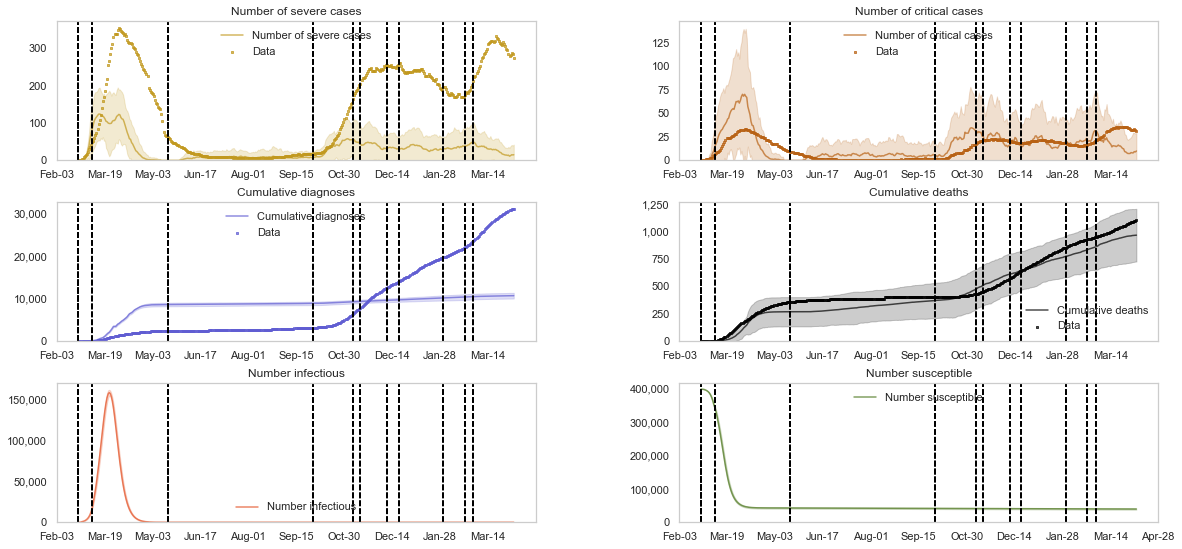

In [12]:
plot_best(study)

## Calibration #3: Multi-Sim, Steps & Diagnosed Column

The previous approach had many flaws that we will now try to resolve.

1. the `objective` function is computed as the sum of the mismatches on a single run, which may lead to the exploration of wrong areas of the loss function due to the inner stochastic nature of covasim
  * in order to balance the efficiency and effectiveness, from now on we will average the results of 3 runs
  
2. as some parameters are more coarse-grained than other, we introduce the `step` and `log` parameters of optuna both to reduce the search space to discrete values instead of uniform ones and to guide the search of nearby parameters:
  * to each *probability* parameter will be assigned a step of 0.01
  * to each *absolute* parameter will be assigned a step of 0.1 (except for *pop_infected*)
  * to each *beta* will be assigned no step, being it an extremely fine-grained parameter
  * to each *viral load* parameter will be assigned no step, but a log-uniform search
  
3. the simulator, while trying to fit the summer period, in order to keep the number of cases low while being able to be prepared for the second wave, gets stuck on configurations with a high summer beta and a low summer symptomatic probability, which leads to a totally out-of-scale number of infectious individuals
  * from now on, we will include the total number of infected people as ground truth, which corresponds to the *cum_diagnoses* column (not the cum_infectious, which includes the non-diagnosed cases, too)

In [13]:
def get_calibration_params(trial):
    return dict(
        pop_infected=trial.suggest_int('pop_infected', pop_size // 1e4, pop_size // 1e2, step=5),
        **default_params
    ), dict(
        trace_prob=trial.suggest_float('trace_prob', 0.0, 1.0, step=1e-2),
        trace_time=trial.suggest_float('trace_time', 0.0, 10.0, step=1e-1),
        yellow_work_contacts=trial.suggest_float('yellow_work_contacts', 0.0, 1.0, step=1e-1),
        orange_work_contacts=trial.suggest_float('orange_work_contacts', 0.0, 1.0, step=1e-1),
        red_work_contacts=trial.suggest_float('red_work_contacts', 0.0, 1.0, step=1e-1),
        yellow_school_contacts=trial.suggest_float('yellow_school_contacts', 0.0, 1.0, step=1e-1),
        orange_school_contacts=trial.suggest_float('orange_school_contacts', 0.0, 1.0, step=1e-1),
        yellow_casual_contacts=trial.suggest_float('yellow_casual_contacts', 0.0, 1.0, step=1e-1),
        orange_casual_contacts=trial.suggest_float('orange_casual_contacts', 0.0, 1.0, step=1e-1),
        red_casual_contacts=trial.suggest_float('red_casual_contacts', 0.0, 1.0, step=1e-1),
        init_imports=trial.suggest_float('init_imports', 0.0, 20.0, step=1e-1),
        yellow_imports=trial.suggest_float('yellow_imports', 4.0, 12.0, step=1e-1),
        orange_imports=trial.suggest_float('orange_imports', 2.0, 8.0, step=1e-1),
        red_imports=trial.suggest_float('red_imports', 0.0, 4.0, step=1e-1),
        init_beta=trial.suggest_float('init_beta', 0.0, 0.2, step=None),
        init_symp=trial.suggest_float('init_symp', 0.01, 10.0, log=True),
        init_sev=trial.suggest_float('init_sev', 0.01, 10.0, log=True),
        init_crit=trial.suggest_float('init_crit', 0.01, 10.0, log=True),
        init_death=trial.suggest_float('init_death', 0.01, 10.0, log=True),
        summer_beta=trial.suggest_float('summer_beta', 0.0, 0.2, step=None),
        summer_symp=trial.suggest_float('summer_symp', 0.01, 10.0, log=True),
        summer_sev=trial.suggest_float('summer_sev', 0.01, 10.0, log=True),
        summer_crit=trial.suggest_float('summer_crit', 0.01, 10.0, log=True),
        summer_death=trial.suggest_float('summer_death', 0.01, 10.0, log=True),
        winter_beta=trial.suggest_float('winter_beta', 0.0, 0.2, step=None),
        winter_symp=trial.suggest_float('winter_symp', 0.01, 10.0, log=True),
        winter_sev=trial.suggest_float('winter_sev', 0.01, 10.0, log=True),
        winter_crit=trial.suggest_float('winter_crit', 0.01, 10.0, log=True),
        winter_death=trial.suggest_float('winter_death', 0.01, 10.0, log=True)
    )

In [14]:
weights = {k: 1 for k in cols}

def objective(trial):
    # define learnable parameters
    initial_params, intervention_params = get_calibration_params(trial)
    # define and run simulations, then return loss
    intervs = interventions.get_calibration_interventions(intervention_params)
    sim = cv.Sim(pars=initial_params, interventions=intervs, datafile=df)
    msim = cv.MultiSim(sim)
    msim.run(n_runs=3)
    mismatches = [s.compute_fit(keys=cols, weights=weights).mismatch for s in msim.sims]
    return sum(mismatches) / 3

study = op.create_study()
study.optimize(func=objective, n_trials=n_trials)

[I 2021-04-09 05:08:42,114] A new study created in memory with name: no-name-764a295a-921c-4b21-b031-aa5969e85267
[I 2021-04-09 05:08:53,823] Trial 0 finished with value: 2792.4867564672427 and parameters: {'pop_infected': 495, 'trace_prob': 0.42, 'trace_time': 8.6, 'yellow_work_contacts': 0.30000000000000004, 'orange_work_contacts': 0.30000000000000004, 'red_work_contacts': 0.5, 'yellow_school_contacts': 0.5, 'orange_school_contacts': 0.6000000000000001, 'yellow_casual_contacts': 0.4, 'orange_casual_contacts': 0.9, 'red_casual_contacts': 0.1, 'init_imports': 7.0, 'yellow_imports': 11.7, 'orange_imports': 6.1000000000000005, 'red_imports': 1.6, 'init_beta': 0.052421094481928714, 'init_symp': 0.3956952725514369, 'init_sev': 0.013683993347737896, 'init_crit': 0.0694392426654977, 'init_death': 0.08108564441062234, 'summer_beta': 0.14038712072434809, 'summer_symp': 0.1140058209345715, 'summer_sev': 9.61308332865341, 'summer_crit': 7.988938113709805, 'summer_death': 0.5843670526409128, 'win

[I 2021-04-09 05:10:26,199] Trial 8 finished with value: 951.3840602803866 and parameters: {'pop_infected': 2815, 'trace_prob': 0.61, 'trace_time': 4.6000000000000005, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.7000000000000001, 'red_work_contacts': 0.5, 'yellow_school_contacts': 0.30000000000000004, 'orange_school_contacts': 0.0, 'yellow_casual_contacts': 0.2, 'orange_casual_contacts': 0.7000000000000001, 'red_casual_contacts': 0.4, 'init_imports': 15.8, 'yellow_imports': 7.0, 'orange_imports': 3.2, 'red_imports': 3.3000000000000003, 'init_beta': 0.1915900458347546, 'init_symp': 1.890281618465529, 'init_sev': 0.23961675113332379, 'init_crit': 0.09501947508252187, 'init_death': 0.025713966304363647, 'summer_beta': 0.15726015889677702, 'summer_symp': 1.8020379037488934, 'summer_sev': 0.8462128559021819, 'summer_crit': 0.4547087667327269, 'summer_death': 1.0061442997666656, 'winter_beta': 0.11218721185978053, 'winter_symp': 0.012850371467768887, 'winter_sev': 2.93422064696830

[I 2021-04-09 05:12:03,521] Trial 16 finished with value: 718.3993786716572 and parameters: {'pop_infected': 1760, 'trace_prob': 0.51, 'trace_time': 3.3000000000000003, 'yellow_work_contacts': 0.1, 'orange_work_contacts': 0.8, 'red_work_contacts': 0.8, 'yellow_school_contacts': 0.8, 'orange_school_contacts': 0.4, 'yellow_casual_contacts': 0.30000000000000004, 'orange_casual_contacts': 0.1, 'red_casual_contacts': 0.0, 'init_imports': 12.8, 'yellow_imports': 8.4, 'orange_imports': 7.2, 'red_imports': 2.7, 'init_beta': 0.057542711980612476, 'init_symp': 0.014606527684077721, 'init_sev': 1.5851416431488998, 'init_crit': 0.19643988398237316, 'init_death': 0.7510443422698538, 'summer_beta': 0.010582931076755162, 'summer_symp': 0.7004870588996068, 'summer_sev': 2.650140809965005, 'summer_crit': 8.740930625057324, 'summer_death': 9.448739425423826, 'winter_beta': 0.009775051465620993, 'winter_symp': 0.37115956502110165, 'winter_sev': 9.932754990321511, 'winter_crit': 0.04183322255414581, 'wint

[I 2021-04-09 05:13:37,165] Trial 24 finished with value: 838.6999188840351 and parameters: {'pop_infected': 2500, 'trace_prob': 0.85, 'trace_time': 1.1, 'yellow_work_contacts': 0.5, 'orange_work_contacts': 0.2, 'red_work_contacts': 0.9, 'yellow_school_contacts': 0.7000000000000001, 'orange_school_contacts': 0.5, 'yellow_casual_contacts': 0.8, 'orange_casual_contacts': 0.4, 'red_casual_contacts': 0.30000000000000004, 'init_imports': 11.200000000000001, 'yellow_imports': 5.1, 'orange_imports': 7.4, 'red_imports': 2.8000000000000003, 'init_beta': 0.0384985881457415, 'init_symp': 0.4481846730017544, 'init_sev': 0.3864744157404052, 'init_crit': 0.222157380438339, 'init_death': 5.439982111285245, 'summer_beta': 0.08004163811187043, 'summer_symp': 0.8631567077823787, 'summer_sev': 0.01488314380937354, 'summer_crit': 4.602622176675742, 'summer_death': 1.3046517990739557, 'winter_beta': 0.09610378174294557, 'winter_symp': 2.0298032684252543, 'winter_sev': 2.406131966518932, 'winter_crit': 4.01

[I 2021-04-09 05:15:13,220] Trial 32 finished with value: 491.7409683509083 and parameters: {'pop_infected': 2610, 'trace_prob': 0.73, 'trace_time': 2.5, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.30000000000000004, 'red_work_contacts': 0.4, 'yellow_school_contacts': 0.5, 'orange_school_contacts': 0.7000000000000001, 'yellow_casual_contacts': 0.7000000000000001, 'orange_casual_contacts': 0.5, 'red_casual_contacts': 0.6000000000000001, 'init_imports': 2.0, 'yellow_imports': 4.6, 'orange_imports': 8.0, 'red_imports': 1.6, 'init_beta': 0.050274390633616974, 'init_symp': 0.39001418956605055, 'init_sev': 0.02491351804971876, 'init_crit': 0.3190151400986832, 'init_death': 1.4869612131916794, 'summer_beta': 0.021991686407396002, 'summer_symp': 0.014873964293721618, 'summer_sev': 0.11635931294430124, 'summer_crit': 0.5599429328407537, 'summer_death': 0.9905317279891082, 'winter_beta': 0.018047860753297347, 'winter_symp': 0.5929604787205114, 'winter_sev': 7.5883370257471014, 'winter

[I 2021-04-09 05:16:56,475] Trial 40 finished with value: 539.5767520882008 and parameters: {'pop_infected': 2715, 'trace_prob': 0.72, 'trace_time': 1.9000000000000001, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.30000000000000004, 'red_work_contacts': 0.2, 'yellow_school_contacts': 0.4, 'orange_school_contacts': 1.0, 'yellow_casual_contacts': 0.5, 'orange_casual_contacts': 0.8, 'red_casual_contacts': 0.30000000000000004, 'init_imports': 3.5, 'yellow_imports': 6.9, 'orange_imports': 7.0, 'red_imports': 1.0, 'init_beta': 0.029327235682724953, 'init_symp': 0.11806701578204326, 'init_sev': 0.16893050295339038, 'init_crit': 0.7644799271249089, 'init_death': 0.9328708037107061, 'summer_beta': 0.14192854105151326, 'summer_symp': 0.03832838131032609, 'summer_sev': 0.030795732922860565, 'summer_crit': 0.6792504607009485, 'summer_death': 0.30530405389457693, 'winter_beta': 0.04595249482489491, 'winter_symp': 0.06666483650642531, 'winter_sev': 4.27780692833543, 'winter_crit': 2.787065

[I 2021-04-09 05:18:30,590] Trial 48 finished with value: 435.741887108614 and parameters: {'pop_infected': 940, 'trace_prob': 0.9400000000000001, 'trace_time': 0.1, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.6000000000000001, 'red_work_contacts': 0.2, 'yellow_school_contacts': 0.7000000000000001, 'orange_school_contacts': 0.6000000000000001, 'yellow_casual_contacts': 0.8, 'orange_casual_contacts': 0.7000000000000001, 'red_casual_contacts': 0.4, 'init_imports': 7.6000000000000005, 'yellow_imports': 7.1, 'orange_imports': 6.7, 'red_imports': 3.0, 'init_beta': 0.09416893234691899, 'init_symp': 1.8813229600866892, 'init_sev': 0.014455754407297492, 'init_crit': 1.7790572293549711, 'init_death': 7.33842286687505, 'summer_beta': 0.009301703684482649, 'summer_symp': 0.1020248417696317, 'summer_sev': 0.019310713786064613, 'summer_crit': 0.35799116979459644, 'summer_death': 0.05934688825133359, 'winter_beta': 0.06630607046569337, 'winter_symp': 1.3374938229997624, 'winter_sev': 2.32

[I 2021-04-09 05:20:07,112] Trial 56 finished with value: 472.853287613212 and parameters: {'pop_infected': 755, 'trace_prob': 0.97, 'trace_time': 1.1, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.7000000000000001, 'red_work_contacts': 0.1, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.6000000000000001, 'yellow_casual_contacts': 1.0, 'orange_casual_contacts': 0.7000000000000001, 'red_casual_contacts': 0.2, 'init_imports': 8.700000000000001, 'yellow_imports': 6.6, 'orange_imports': 6.7, 'red_imports': 3.7, 'init_beta': 0.10330810731284108, 'init_symp': 5.299626824302289, 'init_sev': 0.010286398772447145, 'init_crit': 4.111225470146401, 'init_death': 3.9770893871387063, 'summer_beta': 0.13004135893217433, 'summer_symp': 0.09538300902008622, 'summer_sev': 0.01836989901246271, 'summer_crit': 0.14212185097255345, 'summer_death': 0.01562126756515446, 'winter_beta': 0.08706270892334159, 'winter_symp': 1.650462032488523, 'winter_sev': 0.6574029405688101, 'winter_crit': 0

[I 2021-04-09 05:21:46,577] Trial 64 finished with value: 573.726573464298 and parameters: {'pop_infected': 605, 'trace_prob': 0.89, 'trace_time': 0.5, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.6000000000000001, 'red_work_contacts': 0.0, 'yellow_school_contacts': 0.6000000000000001, 'orange_school_contacts': 0.6000000000000001, 'yellow_casual_contacts': 0.9, 'orange_casual_contacts': 0.6000000000000001, 'red_casual_contacts': 0.30000000000000004, 'init_imports': 6.4, 'yellow_imports': 7.300000000000001, 'orange_imports': 6.7, 'red_imports': 3.5, 'init_beta': 0.07950573605234862, 'init_symp': 1.7484756184640369, 'init_sev': 0.04148688317082682, 'init_crit': 2.5124011754374096, 'init_death': 5.189943959656122, 'summer_beta': 0.13183858999635173, 'summer_symp': 0.08592582176544158, 'summer_sev': 0.047535453582082575, 'summer_crit': 0.16660984621893482, 'summer_death': 0.022775817544577855, 'winter_beta': 0.03814851320304967, 'winter_symp': 3.876527285129939, 'winter_sev': 2.8

[I 2021-04-09 05:23:20,980] Trial 72 finished with value: 420.2800100932732 and parameters: {'pop_infected': 860, 'trace_prob': 0.14, 'trace_time': 1.1, 'yellow_work_contacts': 0.8, 'orange_work_contacts': 0.7000000000000001, 'red_work_contacts': 0.2, 'yellow_school_contacts': 0.6000000000000001, 'orange_school_contacts': 0.7000000000000001, 'yellow_casual_contacts': 0.9, 'orange_casual_contacts': 0.8, 'red_casual_contacts': 0.1, 'init_imports': 18.5, 'yellow_imports': 7.4, 'orange_imports': 6.1000000000000005, 'red_imports': 3.9000000000000004, 'init_beta': 0.1341557513330518, 'init_symp': 1.3749363623030761, 'init_sev': 0.01668016108051046, 'init_crit': 3.238130609660142, 'init_death': 4.561486168041062, 'summer_beta': 0.15630637047590226, 'summer_symp': 0.07026961957793926, 'summer_sev': 0.01169027689708052, 'summer_crit': 0.5253870403054095, 'summer_death': 0.011830622023281811, 'winter_beta': 0.07712683108800544, 'winter_symp': 2.2298585824769517, 'winter_sev': 1.2459227980813996,

[I 2021-04-09 05:24:58,898] Trial 80 finished with value: 481.2938973837588 and parameters: {'pop_infected': 1075, 'trace_prob': 0.17, 'trace_time': 1.5, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.8, 'red_work_contacts': 0.2, 'yellow_school_contacts': 0.5, 'orange_school_contacts': 0.5, 'yellow_casual_contacts': 0.8, 'orange_casual_contacts': 0.8, 'red_casual_contacts': 0.4, 'init_imports': 16.5, 'yellow_imports': 5.1, 'orange_imports': 6.4, 'red_imports': 3.4000000000000004, 'init_beta': 0.09902455662635909, 'init_symp': 2.0295757310014326, 'init_sev': 0.024687173744339132, 'init_crit': 2.2600885614594746, 'init_death': 3.813446142397645, 'summer_beta': 0.18840101741156173, 'summer_symp': 0.04814261306987839, 'summer_sev': 0.014981526741871892, 'summer_crit': 1.2532266711957523, 'summer_death': 0.1752356309352817, 'winter_beta': 0.1110101838661017, 'winter_symp': 2.396000674251458, 'winter_sev': 3.387359423008969, 'winter_crit': 0.6826166405494631, 'winter_death': 0.269893

[I 2021-04-09 05:26:38,466] Trial 88 finished with value: 471.92661648959665 and parameters: {'pop_infected': 1255, 'trace_prob': 0.1, 'trace_time': 0.9, 'yellow_work_contacts': 0.8, 'orange_work_contacts': 0.7000000000000001, 'red_work_contacts': 0.2, 'yellow_school_contacts': 0.5, 'orange_school_contacts': 0.7000000000000001, 'yellow_casual_contacts': 0.9, 'orange_casual_contacts': 0.8, 'red_casual_contacts': 0.2, 'init_imports': 17.0, 'yellow_imports': 6.1, 'orange_imports': 5.5, 'red_imports': 3.7, 'init_beta': 0.1117088386111377, 'init_symp': 3.538740971268947, 'init_sev': 0.01188631473468325, 'init_crit': 3.9731928690487623, 'init_death': 3.382126401138893, 'summer_beta': 0.19732637803357242, 'summer_symp': 0.033975314270589065, 'summer_sev': 0.024726914584004646, 'summer_crit': 3.97424463373878, 'summer_death': 0.11904793721625224, 'winter_beta': 0.11741084839014694, 'winter_symp': 5.975992390314501, 'winter_sev': 0.8707295242598376, 'winter_crit': 0.38241952165188886, 'winter_d

[I 2021-04-09 05:28:14,068] Trial 96 finished with value: 456.1344731889739 and parameters: {'pop_infected': 775, 'trace_prob': 0.17, 'trace_time': 0.8, 'yellow_work_contacts': 0.8, 'orange_work_contacts': 0.6000000000000001, 'red_work_contacts': 0.0, 'yellow_school_contacts': 0.7000000000000001, 'orange_school_contacts': 0.7000000000000001, 'yellow_casual_contacts': 0.8, 'orange_casual_contacts': 0.8, 'red_casual_contacts': 0.30000000000000004, 'init_imports': 15.8, 'yellow_imports': 6.300000000000001, 'orange_imports': 7.300000000000001, 'red_imports': 3.7, 'init_beta': 0.1253765695985226, 'init_symp': 1.073471181529047, 'init_sev': 0.014649292032031063, 'init_crit': 2.7307903561123994, 'init_death': 3.849393601995007, 'summer_beta': 0.17547430777830195, 'summer_symp': 0.11489241748659375, 'summer_sev': 0.07045810194346742, 'summer_crit': 0.16944827814524216, 'summer_death': 0.3558192111751939, 'winter_beta': 0.10425784497264726, 'winter_symp': 8.409462001623602, 'winter_sev': 1.7776

[I 2021-04-09 05:29:52,885] Trial 104 finished with value: 465.93210454656054 and parameters: {'pop_infected': 920, 'trace_prob': 0.0, 'trace_time': 1.0, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.7000000000000001, 'red_work_contacts': 0.2, 'yellow_school_contacts': 0.5, 'orange_school_contacts': 0.5, 'yellow_casual_contacts': 0.9, 'orange_casual_contacts': 0.8, 'red_casual_contacts': 0.1, 'init_imports': 16.6, 'yellow_imports': 5.5, 'orange_imports': 6.2, 'red_imports': 3.8000000000000003, 'init_beta': 0.11411869877770184, 'init_symp': 1.8390984239206363, 'init_sev': 0.013065200872084745, 'init_crit': 1.221903295721439, 'init_death': 7.524599083552109, 'summer_beta': 0.15168329960012053, 'summer_symp': 0.4136399447122276, 'summer_sev': 0.019971774941404678, 'summer_crit': 2.1311410189271913, 'summer_death': 0.017696839877806177, 'winter_beta': 0.0992601513253612, 'winter_symp': 4.97510537876553, 'winter_sev': 1.9945373071975594, 'winter_crit': 0.7891291161726836, 'winter_d

[I 2021-04-09 05:31:29,975] Trial 112 finished with value: 464.0254345572917 and parameters: {'pop_infected': 1275, 'trace_prob': 0.52, 'trace_time': 0.9, 'yellow_work_contacts': 0.8, 'orange_work_contacts': 0.7000000000000001, 'red_work_contacts': 0.2, 'yellow_school_contacts': 0.6000000000000001, 'orange_school_contacts': 0.6000000000000001, 'yellow_casual_contacts': 0.9, 'orange_casual_contacts': 0.7000000000000001, 'red_casual_contacts': 0.30000000000000004, 'init_imports': 5.800000000000001, 'yellow_imports': 6.1, 'orange_imports': 4.800000000000001, 'red_imports': 3.6, 'init_beta': 0.0928706431463982, 'init_symp': 1.3088789327770534, 'init_sev': 0.01761594330804065, 'init_crit': 3.769762637677669, 'init_death': 4.898488439624527, 'summer_beta': 0.14915087876410843, 'summer_symp': 0.23752182748104328, 'summer_sev': 0.056764550338916954, 'summer_crit': 2.405823441370877, 'summer_death': 0.16610184132103176, 'winter_beta': 0.07445719412310134, 'winter_symp': 4.263046121940933, 'wint

[I 2021-04-09 05:33:04,783] Trial 120 finished with value: 472.7747993350513 and parameters: {'pop_infected': 1575, 'trace_prob': 0.0, 'trace_time': 1.0, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.8, 'red_work_contacts': 0.2, 'yellow_school_contacts': 0.5, 'orange_school_contacts': 0.5, 'yellow_casual_contacts': 0.9, 'orange_casual_contacts': 0.8, 'red_casual_contacts': 0.4, 'init_imports': 17.5, 'yellow_imports': 5.1, 'orange_imports': 2.5, 'red_imports': 3.2, 'init_beta': 0.09503914163793174, 'init_symp': 3.690022145822912, 'init_sev': 0.010037107090560425, 'init_crit': 3.0268844243949165, 'init_death': 6.832417782436599, 'summer_beta': 0.16890487714351984, 'summer_symp': 0.15805492085257344, 'summer_sev': 0.02059614002718599, 'summer_crit': 1.3572164665546413, 'summer_death': 0.15256287908992733, 'winter_beta': 0.06382366826936926, 'winter_symp': 2.2973998059443574, 'winter_sev': 2.187072369546809, 'winter_crit': 0.1259949856032834, 'winter_death': 1.181688797078877}. Be

[I 2021-04-09 05:34:45,128] Trial 128 finished with value: 447.08027256696613 and parameters: {'pop_infected': 540, 'trace_prob': 0.8300000000000001, 'trace_time': 0.7000000000000001, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.5, 'red_work_contacts': 0.0, 'yellow_school_contacts': 0.7000000000000001, 'orange_school_contacts': 0.7000000000000001, 'yellow_casual_contacts': 0.8, 'orange_casual_contacts': 0.7000000000000001, 'red_casual_contacts': 0.30000000000000004, 'init_imports': 5.7, 'yellow_imports': 7.4, 'orange_imports': 6.4, 'red_imports': 2.8000000000000003, 'init_beta': 0.15371511625246276, 'init_symp': 0.7871810934820801, 'init_sev': 0.021940504173180667, 'init_crit': 1.102696990657677, 'init_death': 3.636147008174742, 'summer_beta': 0.1624375330206518, 'summer_symp': 0.07229335271061713, 'summer_sev': 0.019216963408046583, 'summer_crit': 0.369457947296635, 'summer_death': 0.01411770517483626, 'winter_beta': 0.060883927096520594, 'winter_symp': 2.6136237457209273, '

[I 2021-04-09 05:36:21,460] Trial 136 finished with value: 408.6297915902566 and parameters: {'pop_infected': 365, 'trace_prob': 0.8200000000000001, 'trace_time': 0.5, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.5, 'red_work_contacts': 0.2, 'yellow_school_contacts': 0.7000000000000001, 'orange_school_contacts': 0.7000000000000001, 'yellow_casual_contacts': 0.7000000000000001, 'orange_casual_contacts': 0.7000000000000001, 'red_casual_contacts': 0.1, 'init_imports': 5.4, 'yellow_imports': 7.5, 'orange_imports': 6.4, 'red_imports': 3.2, 'init_beta': 0.15619353903580122, 'init_symp': 0.9260062626436097, 'init_sev': 0.018762846965545903, 'init_crit': 2.1076343396228325, 'init_death': 2.9129214063105664, 'summer_beta': 0.1440323501329685, 'summer_symp': 0.14585369744965554, 'summer_sev': 0.01564401778535015, 'summer_crit': 0.5166115313522617, 'summer_death': 0.011211890008601535, 'winter_beta': 0.07028003646347494, 'winter_symp': 2.3325348694399404, 'winter_sev': 4.532979618741122

[I 2021-04-09 05:38:00,464] Trial 144 finished with value: 465.8144536948436 and parameters: {'pop_infected': 50, 'trace_prob': 0.76, 'trace_time': 0.1, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.4, 'red_work_contacts': 0.30000000000000004, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.9, 'yellow_casual_contacts': 0.5, 'orange_casual_contacts': 1.0, 'red_casual_contacts': 0.0, 'init_imports': 4.1000000000000005, 'yellow_imports': 9.0, 'orange_imports': 5.6, 'red_imports': 3.1, 'init_beta': 0.19828727603006532, 'init_symp': 0.2639149549381934, 'init_sev': 0.058155462427964655, 'init_crit': 0.4470141896748923, 'init_death': 1.1235046431997198, 'summer_beta': 0.13526124308471257, 'summer_symp': 0.14224361697847557, 'summer_sev': 0.01156895021303292, 'summer_crit': 0.7307076409332225, 'summer_death': 0.010243183977022926, 'winter_beta': 0.07147932744323053, 'winter_symp': 1.8480898177661784, 'winter_sev': 8.90583007572783, 'winter_crit': 1.3002564077771799, 'winter

[I 2021-04-09 05:39:44,432] Trial 152 finished with value: 452.98450117005297 and parameters: {'pop_infected': 160, 'trace_prob': 0.78, 'trace_time': 0.30000000000000004, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.30000000000000004, 'red_work_contacts': 0.4, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.9, 'yellow_casual_contacts': 0.5, 'orange_casual_contacts': 1.0, 'red_casual_contacts': 0.0, 'init_imports': 3.5, 'yellow_imports': 9.8, 'orange_imports': 5.5, 'red_imports': 2.3000000000000003, 'init_beta': 0.16135651163064016, 'init_symp': 0.29830903668576414, 'init_sev': 0.08555499113694838, 'init_crit': 0.5096786614696734, 'init_death': 1.0562189727480393, 'summer_beta': 0.11799324737639867, 'summer_symp': 0.11278921557236896, 'summer_sev': 0.011519827581348768, 'summer_crit': 0.7991791800720583, 'summer_death': 0.011007533783968376, 'winter_beta': 0.06842297142434307, 'winter_symp': 2.0730411029841163, 'winter_sev': 6.185208655417825, 'winter_crit': 1.69530

[I 2021-04-09 05:41:18,283] Trial 160 finished with value: 473.00342415470783 and parameters: {'pop_infected': 100, 'trace_prob': 0.64, 'trace_time': 5.1000000000000005, 'yellow_work_contacts': 0.30000000000000004, 'orange_work_contacts': 0.30000000000000004, 'red_work_contacts': 0.5, 'yellow_school_contacts': 1.0, 'orange_school_contacts': 1.0, 'yellow_casual_contacts': 0.4, 'orange_casual_contacts': 0.9, 'red_casual_contacts': 0.1, 'init_imports': 2.9000000000000004, 'yellow_imports': 8.2, 'orange_imports': 6.0, 'red_imports': 2.4000000000000004, 'init_beta': 0.154556459706366, 'init_symp': 0.4896115448809533, 'init_sev': 0.15452551772575723, 'init_crit': 0.6582123709074, 'init_death': 0.9785363591538079, 'summer_beta': 0.1158610015540433, 'summer_symp': 0.09162575814578497, 'summer_sev': 0.013925164472264849, 'summer_crit': 0.8868056109047086, 'summer_death': 0.014690209347104384, 'winter_beta': 0.05338462027766563, 'winter_symp': 1.5436362701670694, 'winter_sev': 5.2630004752282, '

[I 2021-04-09 05:42:56,541] Trial 168 finished with value: 432.90079195926245 and parameters: {'pop_infected': 190, 'trace_prob': 0.6, 'trace_time': 0.6000000000000001, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.2, 'red_work_contacts': 0.4, 'yellow_school_contacts': 1.0, 'orange_school_contacts': 1.0, 'yellow_casual_contacts': 0.6000000000000001, 'orange_casual_contacts': 1.0, 'red_casual_contacts': 0.0, 'init_imports': 3.9000000000000004, 'yellow_imports': 8.600000000000001, 'orange_imports': 5.9, 'red_imports': 2.3000000000000003, 'init_beta': 0.16026700538121488, 'init_symp': 0.5831878350901045, 'init_sev': 0.11024951651560823, 'init_crit': 0.24160751649163206, 'init_death': 2.2154514877823908, 'summer_beta': 0.12730682283760797, 'summer_symp': 0.06821206444902327, 'summer_sev': 0.016094194610165657, 'summer_crit': 1.3486544805621294, 'summer_death': 0.017930936387391537, 'winter_beta': 0.05850525928318485, 'winter_symp': 1.5093476873985514, 'winter_sev': 9.8667836392948

[I 2021-04-09 05:44:37,635] Trial 176 finished with value: 414.13059528773846 and parameters: {'pop_infected': 200, 'trace_prob': 0.68, 'trace_time': 0.0, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.30000000000000004, 'red_work_contacts': 0.5, 'yellow_school_contacts': 1.0, 'orange_school_contacts': 0.9, 'yellow_casual_contacts': 0.30000000000000004, 'orange_casual_contacts': 1.0, 'red_casual_contacts': 0.1, 'init_imports': 3.8000000000000003, 'yellow_imports': 8.9, 'orange_imports': 5.7, 'red_imports': 2.5, 'init_beta': 0.18243154410039825, 'init_symp': 0.3955910055795793, 'init_sev': 0.07520084363113687, 'init_crit': 0.27709805909820345, 'init_death': 2.142966034089907, 'summer_beta': 0.09803293302253867, 'summer_symp': 0.123379336031039, 'summer_sev': 0.017031095996195858, 'summer_crit': 1.2403309073933904, 'summer_death': 0.017251798714263748, 'winter_beta': 0.06491185423376154, 'winter_symp': 1.7140189567816373, 'winter_sev': 8.562570314202686, 'winter_crit': 0.87209170

[I 2021-04-09 05:46:16,529] Trial 184 finished with value: 439.50680572115533 and parameters: {'pop_infected': 185, 'trace_prob': 0.59, 'trace_time': 0.7000000000000001, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.1, 'red_work_contacts': 0.6000000000000001, 'yellow_school_contacts': 1.0, 'orange_school_contacts': 1.0, 'yellow_casual_contacts': 0.2, 'orange_casual_contacts': 1.0, 'red_casual_contacts': 0.1, 'init_imports': 2.4000000000000004, 'yellow_imports': 9.0, 'orange_imports': 6.2, 'red_imports': 2.3000000000000003, 'init_beta': 0.15575843318337848, 'init_symp': 0.19335562156011904, 'init_sev': 0.2550494612975017, 'init_crit': 0.2417039777841692, 'init_death': 2.7561893161054756, 'summer_beta': 0.10427195493879132, 'summer_symp': 0.06217680911052031, 'summer_sev': 0.01764441225467609, 'summer_crit': 1.9210874192603888, 'summer_death': 0.027990184619648653, 'winter_beta': 0.051500804613346024, 'winter_symp': 1.970895608945742, 'winter_sev': 5.643375386359639, 'winter_cri

[I 2021-04-09 05:48:00,152] Trial 192 finished with value: 510.6933705114897 and parameters: {'pop_infected': 50, 'trace_prob': 0.49, 'trace_time': 0.7000000000000001, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.30000000000000004, 'red_work_contacts': 0.5, 'yellow_school_contacts': 1.0, 'orange_school_contacts': 1.0, 'yellow_casual_contacts': 0.30000000000000004, 'orange_casual_contacts': 1.0, 'red_casual_contacts': 0.1, 'init_imports': 3.2, 'yellow_imports': 9.0, 'orange_imports': 5.9, 'red_imports': 2.1, 'init_beta': 0.14656707746662356, 'init_symp': 0.38363368289182254, 'init_sev': 0.08245204400721122, 'init_crit': 0.38979386549139045, 'init_death': 1.3386993427997642, 'summer_beta': 0.11301314293157647, 'summer_symp': 0.05682328411489466, 'summer_sev': 0.021572906599098163, 'summer_crit': 1.3189668304604365, 'summer_death': 0.02365919389231963, 'winter_beta': 0.06324212805052482, 'winter_symp': 1.4556290590477587, 'winter_sev': 0.13918776301572539, 'winter_crit': 0.62603

[I 2021-04-09 05:49:39,562] Trial 200 finished with value: 394.18947981337425 and parameters: {'pop_infected': 290, 'trace_prob': 0.49, 'trace_time': 1.2000000000000002, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.30000000000000004, 'red_work_contacts': 0.5, 'yellow_school_contacts': 1.0, 'orange_school_contacts': 1.0, 'yellow_casual_contacts': 0.4, 'orange_casual_contacts': 0.9, 'red_casual_contacts': 0.1, 'init_imports': 3.6, 'yellow_imports': 9.4, 'orange_imports': 6.2, 'red_imports': 2.3000000000000003, 'init_beta': 0.1370907923456747, 'init_symp': 0.4091714027420803, 'init_sev': 0.13192782618967744, 'init_crit': 0.35990391582454495, 'init_death': 2.762311178552192, 'summer_beta': 0.11115028280900946, 'summer_symp': 0.06919466904901711, 'summer_sev': 0.019156136449471922, 'summer_crit': 1.9587194410842335, 'summer_death': 0.02043106337526332, 'winter_beta': 0.0524301737153456, 'winter_symp': 1.3067479535000555, 'winter_sev': 5.542514173289203, 'winter_crit': 0.6944934769

[I 2021-04-09 05:51:13,774] Trial 208 finished with value: 394.2555842014336 and parameters: {'pop_infected': 40, 'trace_prob': 0.5, 'trace_time': 1.1, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.30000000000000004, 'red_work_contacts': 0.5, 'yellow_school_contacts': 1.0, 'orange_school_contacts': 1.0, 'yellow_casual_contacts': 0.30000000000000004, 'orange_casual_contacts': 0.9, 'red_casual_contacts': 0.1, 'init_imports': 3.9000000000000004, 'yellow_imports': 9.5, 'orange_imports': 6.3, 'red_imports': 1.9000000000000001, 'init_beta': 0.13818523542506894, 'init_symp': 0.26024512956631407, 'init_sev': 0.1186213438585272, 'init_crit': 0.3098321342288098, 'init_death': 1.7826386997108425, 'summer_beta': 0.11009282142174973, 'summer_symp': 0.053136017320599874, 'summer_sev': 0.02000899532976101, 'summer_crit': 1.6969940649991286, 'summer_death': 0.016173015039370478, 'winter_beta': 0.050182179952097956, 'winter_symp': 1.2577512277157739, 'winter_sev': 4.429539210269252, 'winter_cr

[I 2021-04-09 05:52:54,695] Trial 216 finished with value: 425.31698633669106 and parameters: {'pop_infected': 105, 'trace_prob': 0.4, 'trace_time': 1.3, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.2, 'red_work_contacts': 0.5, 'yellow_school_contacts': 1.0, 'orange_school_contacts': 1.0, 'yellow_casual_contacts': 0.30000000000000004, 'orange_casual_contacts': 0.9, 'red_casual_contacts': 0.1, 'init_imports': 3.0, 'yellow_imports': 9.100000000000001, 'orange_imports': 6.1000000000000005, 'red_imports': 2.4000000000000004, 'init_beta': 0.15354798312493173, 'init_symp': 0.5985684851082308, 'init_sev': 0.09772973718159463, 'init_crit': 0.4222571660899209, 'init_death': 1.8535723812907698, 'summer_beta': 0.12007514476541209, 'summer_symp': 0.06860689205497535, 'summer_sev': 0.023881800821379, 'summer_crit': 0.955860666866221, 'summer_death': 0.01913275701398071, 'winter_beta': 0.050396684770680183, 'winter_symp': 1.6741600581154557, 'winter_sev': 4.936265313755778, 'winter_crit': 

[I 2021-04-09 05:54:32,100] Trial 224 finished with value: 385.7537204566547 and parameters: {'pop_infected': 190, 'trace_prob': 0.6, 'trace_time': 1.1, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.2, 'red_work_contacts': 0.6000000000000001, 'yellow_school_contacts': 1.0, 'orange_school_contacts': 1.0, 'yellow_casual_contacts': 0.30000000000000004, 'orange_casual_contacts': 0.9, 'red_casual_contacts': 0.1, 'init_imports': 4.5, 'yellow_imports': 10.100000000000001, 'orange_imports': 6.0, 'red_imports': 2.1, 'init_beta': 0.1422742405388555, 'init_symp': 0.35837542603781825, 'init_sev': 0.17934018435794316, 'init_crit': 0.39759150304064345, 'init_death': 2.764148061322522, 'summer_beta': 0.11847096926867577, 'summer_symp': 0.04659998369404736, 'summer_sev': 0.0165524844752029, 'summer_crit': 0.9772357553680749, 'summer_death': 0.012952119989479406, 'winter_beta': 0.057989671718239134, 'winter_symp': 1.793091662129164, 'winter_sev': 5.755475282407038, 'winter_crit': 0.90377209132

[I 2021-04-09 05:56:06,482] Trial 232 finished with value: 405.04271500741135 and parameters: {'pop_infected': 260, 'trace_prob': 0.51, 'trace_time': 2.1, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.2, 'red_work_contacts': 0.5, 'yellow_school_contacts': 1.0, 'orange_school_contacts': 1.0, 'yellow_casual_contacts': 0.30000000000000004, 'orange_casual_contacts': 0.9, 'red_casual_contacts': 0.1, 'init_imports': 3.6, 'yellow_imports': 10.2, 'orange_imports': 6.2, 'red_imports': 2.2, 'init_beta': 0.14522018447271898, 'init_symp': 0.2496879651694855, 'init_sev': 0.14917033287717, 'init_crit': 0.3335602849698797, 'init_death': 3.2826197478724266, 'summer_beta': 0.11154797586292674, 'summer_symp': 0.02821674536416765, 'summer_sev': 0.023977188184178225, 'summer_crit': 2.6528188026573125, 'summer_death': 0.012752583954853302, 'winter_beta': 0.057273389007530984, 'winter_symp': 1.186983679527475, 'winter_sev': 7.1598057066907295, 'winter_crit': 0.4567431455168085, 'winter_death': 5.63

[I 2021-04-09 05:57:48,419] Trial 240 finished with value: 458.4761285166948 and parameters: {'pop_infected': 480, 'trace_prob': 0.49, 'trace_time': 2.2, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.2, 'red_work_contacts': 0.6000000000000001, 'yellow_school_contacts': 1.0, 'orange_school_contacts': 1.0, 'yellow_casual_contacts': 0.30000000000000004, 'orange_casual_contacts': 0.9, 'red_casual_contacts': 0.1, 'init_imports': 4.2, 'yellow_imports': 10.5, 'orange_imports': 6.1000000000000005, 'red_imports': 2.1, 'init_beta': 0.14516198161001317, 'init_symp': 0.15306933694777725, 'init_sev': 0.0863918778905308, 'init_crit': 0.29042056735412447, 'init_death': 3.015750678843948, 'summer_beta': 0.10151159382507004, 'summer_symp': 0.026562442420675726, 'summer_sev': 0.019273541208916486, 'summer_crit': 2.3043422676390253, 'summer_death': 0.02020668313440879, 'winter_beta': 0.051907266118739394, 'winter_symp': 1.2458792092491018, 'winter_sev': 5.956173006769067, 'winter_crit': 0.449980

[I 2021-04-09 05:59:24,680] Trial 248 finished with value: 387.9947314795457 and parameters: {'pop_infected': 170, 'trace_prob': 0.52, 'trace_time': 3.0, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.2, 'red_work_contacts': 0.6000000000000001, 'yellow_school_contacts': 1.0, 'orange_school_contacts': 1.0, 'yellow_casual_contacts': 0.30000000000000004, 'orange_casual_contacts': 0.9, 'red_casual_contacts': 0.1, 'init_imports': 4.1000000000000005, 'yellow_imports': 10.3, 'orange_imports': 6.0, 'red_imports': 2.0, 'init_beta': 0.13181333865822487, 'init_symp': 0.19557851367340057, 'init_sev': 0.09614324389323889, 'init_crit': 0.2834506240463186, 'init_death': 3.614898484941864, 'summer_beta': 0.10098777344484142, 'summer_symp': 0.017148916068334845, 'summer_sev': 0.025630556034321312, 'summer_crit': 2.3642273958556523, 'summer_death': 0.014620807604640636, 'winter_beta': 0.06434050648639197, 'winter_symp': 1.005390857050832, 'winter_sev': 6.412614427237788, 'winter_crit': 0.6029461

[I 2021-04-09 06:01:01,518] Trial 256 finished with value: 464.1461937918457 and parameters: {'pop_infected': 335, 'trace_prob': 0.5700000000000001, 'trace_time': 2.7, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.2, 'red_work_contacts': 0.6000000000000001, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 1.0, 'yellow_casual_contacts': 0.30000000000000004, 'orange_casual_contacts': 0.9, 'red_casual_contacts': 0.2, 'init_imports': 3.1, 'yellow_imports': 10.0, 'orange_imports': 6.5, 'red_imports': 2.3000000000000003, 'init_beta': 0.1417272404412274, 'init_symp': 0.28569956233946453, 'init_sev': 0.1102885962182387, 'init_crit': 0.5206307454600585, 'init_death': 2.2662077195796497, 'summer_beta': 0.120213379441213, 'summer_symp': 0.021912547947828865, 'summer_sev': 0.021675777642139207, 'summer_crit': 2.468636352505822, 'summer_death': 0.01632965588894525, 'winter_beta': 0.0685026516785664, 'winter_symp': 1.429977381150304, 'winter_sev': 6.588524958677169, 'winter_crit': 0

[I 2021-04-09 06:02:42,563] Trial 264 finished with value: 390.6438443558348 and parameters: {'pop_infected': 120, 'trace_prob': 0.61, 'trace_time': 3.5, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.1, 'red_work_contacts': 0.7000000000000001, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 1.0, 'yellow_casual_contacts': 0.2, 'orange_casual_contacts': 0.9, 'red_casual_contacts': 0.1, 'init_imports': 4.9, 'yellow_imports': 9.9, 'orange_imports': 6.3, 'red_imports': 1.9000000000000001, 'init_beta': 0.14469639543636964, 'init_symp': 0.23163819297427488, 'init_sev': 0.13083501719876145, 'init_crit': 0.550490131510847, 'init_death': 3.6330896180631758, 'summer_beta': 0.10895794591700321, 'summer_symp': 0.0361642129213443, 'summer_sev': 0.028971416277943515, 'summer_crit': 2.009883017370306, 'summer_death': 0.018854146793916452, 'winter_beta': 0.07260343176757142, 'winter_symp': 1.2414059279025595, 'winter_sev': 7.463929093346181, 'winter_crit': 0.6189034523262552, 'winter_

[I 2021-04-09 06:04:17,771] Trial 272 finished with value: 448.43688202619086 and parameters: {'pop_infected': 230, 'trace_prob': 0.46, 'trace_time': 4.3, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.1, 'red_work_contacts': 1.0, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.2, 'yellow_casual_contacts': 0.2, 'orange_casual_contacts': 0.9, 'red_casual_contacts': 0.2, 'init_imports': 5.0, 'yellow_imports': 9.9, 'orange_imports': 6.1000000000000005, 'red_imports': 1.9000000000000001, 'init_beta': 0.12904700188367013, 'init_symp': 0.07715816395077142, 'init_sev': 0.17900901350909776, 'init_crit': 0.5694693994506341, 'init_death': 4.715814698799343, 'summer_beta': 0.08131430165563412, 'summer_symp': 0.024069622290588635, 'summer_sev': 0.03515140071543082, 'summer_crit': 2.292197267644379, 'summer_death': 0.01006440837724478, 'winter_beta': 0.08031826382665233, 'winter_symp': 1.1436519660928688, 'winter_sev': 6.656776487341425, 'winter_crit': 0.5925852890776729, 'winter

[I 2021-04-09 06:05:57,338] Trial 280 finished with value: 381.90005702055623 and parameters: {'pop_infected': 45, 'trace_prob': 0.48, 'trace_time': 3.8000000000000003, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.1, 'red_work_contacts': 0.9, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.2, 'yellow_casual_contacts': 0.2, 'orange_casual_contacts': 0.9, 'red_casual_contacts': 0.1, 'init_imports': 5.6000000000000005, 'yellow_imports': 9.9, 'orange_imports': 5.800000000000001, 'red_imports': 1.6, 'init_beta': 0.12946160604336499, 'init_symp': 0.12454542062087331, 'init_sev': 0.28197648324398944, 'init_crit': 0.49441855561497317, 'init_death': 5.216305872035208, 'summer_beta': 0.07987117485249405, 'summer_symp': 0.010967554705692802, 'summer_sev': 0.04984290205063219, 'summer_crit': 1.7885827397869682, 'summer_death': 0.017661262458053186, 'winter_beta': 0.07313833150909115, 'winter_symp': 1.3033749064360318, 'winter_sev': 5.759329324109427, 'winter_crit': 0.691379655

[I 2021-04-09 06:07:38,901] Trial 288 finished with value: 433.5431914945084 and parameters: {'pop_infected': 45, 'trace_prob': 0.42, 'trace_time': 4.5, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.1, 'red_work_contacts': 0.9, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.2, 'yellow_casual_contacts': 0.1, 'orange_casual_contacts': 0.8, 'red_casual_contacts': 0.2, 'init_imports': 6.2, 'yellow_imports': 9.9, 'orange_imports': 5.6, 'red_imports': 1.3, 'init_beta': 0.12461127127517538, 'init_symp': 0.04970627087423703, 'init_sev': 0.3686651633468379, 'init_crit': 0.8463826946597719, 'init_death': 5.548400335507165, 'summer_beta': 0.07996649394402434, 'summer_symp': 0.011483953801048153, 'summer_sev': 0.060213238585065415, 'summer_crit': 1.7933269919544375, 'summer_death': 0.030005331612588837, 'winter_beta': 0.07743218752173653, 'winter_symp': 1.532816874015655, 'winter_sev': 8.65814302307821, 'winter_crit': 0.701330512776759, 'winter_death': 2.488810286456475}. Best

[I 2021-04-09 06:09:22,502] Trial 296 finished with value: 388.4047502771634 and parameters: {'pop_infected': 90, 'trace_prob': 0.32, 'trace_time': 4.2, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.0, 'red_work_contacts': 0.9, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.1, 'yellow_casual_contacts': 0.0, 'orange_casual_contacts': 0.8, 'red_casual_contacts': 0.1, 'init_imports': 6.4, 'yellow_imports': 10.5, 'orange_imports': 5.5, 'red_imports': 1.3, 'init_beta': 0.11597535446225668, 'init_symp': 0.06236122938807528, 'init_sev': 1.2215598202361122, 'init_crit': 0.7888614899677658, 'init_death': 5.3203950238990165, 'summer_beta': 0.0669453812224584, 'summer_symp': 0.012629913328138303, 'summer_sev': 0.0961787095846317, 'summer_crit': 1.5167690876562716, 'summer_death': 0.03620113566355698, 'winter_beta': 0.08182996709291149, 'winter_symp': 2.0333210832431523, 'winter_sev': 8.987195751571148, 'winter_crit': 0.7618659875077274, 'winter_death': 1.7097802278630356}. Be

In [15]:
calibration.inspect_study(study, top=0.1)[1]

,count,min,max,mean,median,std,best
objective,30,346.152079,391.707695,375.127725,379.205700,13.628766,346.152079
pop_infected,30,40.000000,340.000000,143.000000,110.000000,88.020374,110.000000
trace_prob,30,0.280000,0.610000,0.451667,0.480000,0.089523,0.280000
trace_time,30,0.500000,4.200000,3.256667,3.900000,1.139172,3.900000
yellow_work_contacts,30,0.900000,1.000000,0.920000,0.900000,0.040684,0.900000
orange_work_contacts,30,0.000000,0.300000,0.110000,0.100000,0.092289,0.000000
red_work_contacts,30,0.400000,1.000000,0.816667,0.900000,0.185850,0.900000
yellow_school_contacts,30,0.900000,1.000000,0.926667,0.900000,0.044978,0.900000
orange_school_contacts,30,0.100000,1.000000,0.440000,0.200000,0.405650,0.100000
yellow_casual_contacts,30,0.000000,0.600000,0.193333,0.200000,0.133735,0.000000


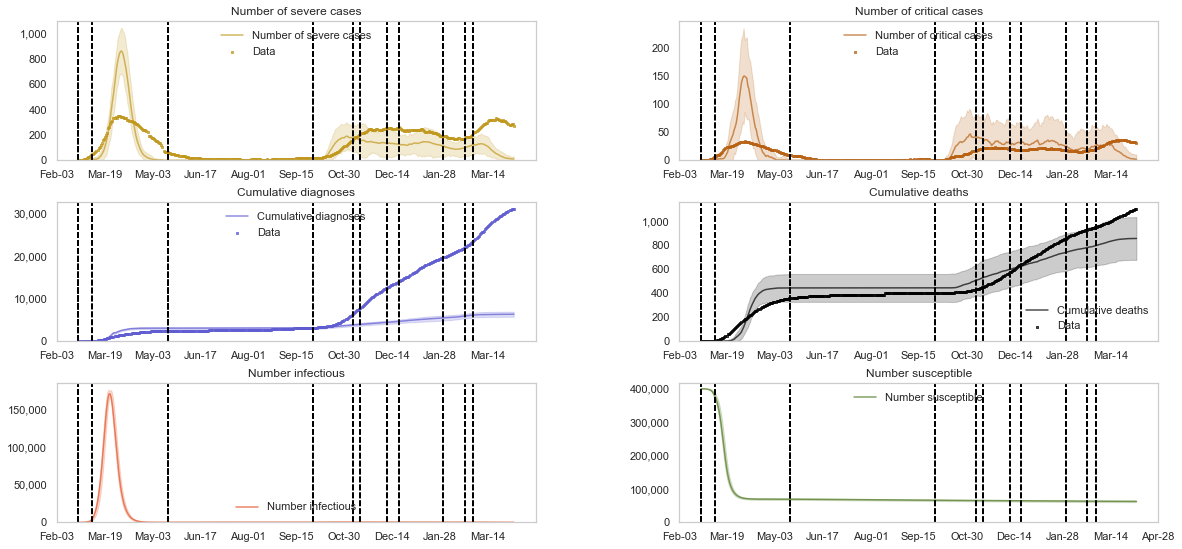

In [16]:
plot_best(study)

## Calibration #4: Constraint Violations & Custom Estimators

When the optimizer tries some values for the parameters, it measures their fitness based on the final objective function only. However, as many of these parameters are co-dependent, the same values could be achieved by increasing one and decreasing another, a method that will eventually lead to possible violation of some common sense ordering constraints, e.g., that the number of work contacts in yellow zone should be greater or equal than the number of work contacts in orange zone.

> In order to tackle this issue, we introduce a *penalty* term, to which the loss will be multiplied, that increases every time an ordering constraint is not satisfied.

Moreover, as we are not bounded to use a differentiable loss function in this case, we can pass a *custom estimator* to covasim's *compute_fit* method that will be in charge of returning a goodness-of-fitness value from the two vectors of ground truths and predictions, respectively.

> In our util package, we provide three different objective functions (*mean squared error*, *mean absolute error*, and *$R^2$ score*), along with the possibility to pass a list of *sample weights* to give more or less importance to certain days/periods in the simulation.

The ordering constraints will be used in the objective function to compute the violations given the dictionary of parameters. Each tuple expresses an ordering, from higher to lower, so that:
$$(\mbox{'init_imports'}, ..., \mbox{'red_imports'}) \rightarrow \mbox{init_imports} \geq ... \geq \mbox{red_imports}$$

The violation is then computed as the product among all the violations, expressed as ratio between the (expected) lower value and (higher) value.

```python
def compute_violation(pars: dict, orderings: list) -> float:
    violation = 1.
    for ordering in orderings:
        ordering = [pars[attribute] for attribute in ordering]
        for higher, lower in zip(ordering[:-1], ordering[1:]):
            violation *= max(1, lower / higher)
    return violation
```

In [17]:
constraint_orderings = [
    ('yellow_work_contacts', 'orange_work_contacts', 'red_work_contacts'),
    ('yellow_school_contacts', 'orange_school_contacts'),
    ('yellow_casual_contacts', 'orange_casual_contacts', 'red_casual_contacts'),
    ('init_imports', 'yellow_imports', 'orange_imports', 'red_imports'),
    ('init_beta', 'summer_beta'),
    ('winter_beta', 'summer_beta')
]

As regards the custom estimator, we noticed that the shape of the loss function may vary the results significantly (we do not know to which extent this is strictly due to the loss or to a combination of the loss and the stochastic algorithm of optuna), and that the more robust approach is to use the *$R^2$ score* (actually, $1 - R^2$), with sample weights that are proportional to the number of severe cases.

> Ideally, this should force the optimizer to be more flexible during the summer period and way stricter around the peaks of the curve, moments in which it is more likely to make errors.

Note: the values are standardized at first, and then translated into the interval $[1, +\infty]$ via a translation factor.

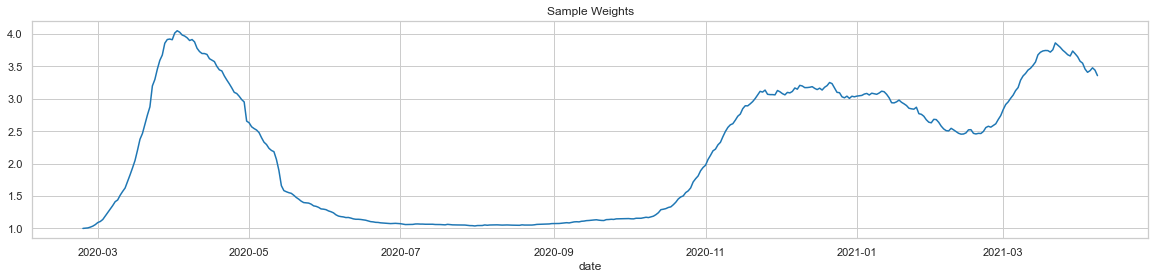

In [18]:
sample_weights = calibration.get_sample_weights(df, 'proportional', column='n_severe')
plt.figure(figsize=(20, 4))
sns.lineplot(x=df['date'], y=sample_weights).set(title='Sample Weights');

In [19]:
estimator = calibration.get_custom_estimator('r2', sample_weights)

def objective(trial):
    # define learnable parameters
    initial_params, intervention_params = get_calibration_params(trial)
    # define and run simulations, then return loss
    intervs = interventions.get_calibration_interventions(intervention_params)
    sim = cv.Sim(pars=initial_params, interventions=intervs, datafile=df)
    msim = cv.MultiSim(sim)
    msim.run(n_runs=3)
    violation = calibration.compute_violation(intervention_params, constraint_orderings)
    mismatches = [s.compute_fit(keys=cols, weights=weights, custom_estimator=estimator).mismatch for s in msim.sims]
    return violation * sum(mismatches) / 3

study = op.create_study()
study.optimize(func=objective, n_trials=n_trials)

[I 2021-04-09 06:11:22,745] A new study created in memory with name: no-name-b2888ba8-8b13-4792-b6eb-2b357494e9db
[I 2021-04-09 06:11:36,626] Trial 0 finished with value: 101591.52178179403 and parameters: {'pop_infected': 1260, 'trace_prob': 0.31, 'trace_time': 7.0, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.30000000000000004, 'red_work_contacts': 0.8, 'yellow_school_contacts': 0.6000000000000001, 'orange_school_contacts': 0.8, 'yellow_casual_contacts': 0.2, 'orange_casual_contacts': 0.30000000000000004, 'red_casual_contacts': 0.6000000000000001, 'init_imports': 1.0, 'yellow_imports': 6.6, 'orange_imports': 5.2, 'red_imports': 1.8, 'init_beta': 0.06849892360212098, 'init_symp': 1.215939736031167, 'init_sev': 0.3276180312452139, 'init_crit': 0.3356413930564111, 'init_death': 0.06197949966045134, 'summer_beta': 0.0019379543353640783, 'summer_symp': 1.872471336008108, 'summer_sev': 0.8462059202511316, 'summer_crit': 2.9639496143797412, 'summer_death': 0.530265383058921, 'wint

[I 2021-04-09 06:13:14,336] Trial 8 finished with value: 8877.759545948527 and parameters: {'pop_infected': 1655, 'trace_prob': 0.45, 'trace_time': 1.7000000000000002, 'yellow_work_contacts': 0.30000000000000004, 'orange_work_contacts': 0.6000000000000001, 'red_work_contacts': 0.6000000000000001, 'yellow_school_contacts': 0.8, 'orange_school_contacts': 0.6000000000000001, 'yellow_casual_contacts': 0.9, 'orange_casual_contacts': 1.0, 'red_casual_contacts': 0.6000000000000001, 'init_imports': 10.700000000000001, 'yellow_imports': 7.5, 'orange_imports': 7.300000000000001, 'red_imports': 2.4000000000000004, 'init_beta': 0.13963605128451495, 'init_symp': 4.053286460862318, 'init_sev': 2.4038693018582378, 'init_crit': 0.01566753217521277, 'init_death': 6.367917621420325, 'summer_beta': 0.12708588711621402, 'summer_symp': 1.7256537805723178, 'summer_sev': 0.017188239136321632, 'summer_crit': 0.05380862290447558, 'summer_death': 0.017397286093980165, 'winter_beta': 0.1292860607472167, 'winter_

[I 2021-04-09 06:14:57,357] Trial 16 finished with value: 710.3041328664366 and parameters: {'pop_infected': 255, 'trace_prob': 0.55, 'trace_time': 7.7, 'yellow_work_contacts': 0.5, 'orange_work_contacts': 0.4, 'red_work_contacts': 0.5, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.2, 'yellow_casual_contacts': 0.4, 'orange_casual_contacts': 0.2, 'red_casual_contacts': 0.1, 'init_imports': 7.300000000000001, 'yellow_imports': 5.1, 'orange_imports': 5.0, 'red_imports': 0.9, 'init_beta': 0.0856666627143742, 'init_symp': 0.10112228458145828, 'init_sev': 0.6293390853976273, 'init_crit': 1.6147580258244463, 'init_death': 0.6968760941389924, 'summer_beta': 0.053318895961585185, 'summer_symp': 0.16355936275020388, 'summer_sev': 0.46605534927588066, 'summer_crit': 0.04190982902188847, 'summer_death': 0.04911069252632715, 'winter_beta': 0.18041825298824132, 'winter_symp': 0.7738168992747297, 'winter_sev': 0.1825690936917849, 'winter_crit': 0.019615420709668888, 'winter_death': 4.512

[I 2021-04-09 06:16:34,620] Trial 24 finished with value: 703.9685050552163 and parameters: {'pop_infected': 890, 'trace_prob': 0.9, 'trace_time': 7.6000000000000005, 'yellow_work_contacts': 0.4, 'orange_work_contacts': 0.4, 'red_work_contacts': 0.30000000000000004, 'yellow_school_contacts': 0.6000000000000001, 'orange_school_contacts': 0.1, 'yellow_casual_contacts': 0.30000000000000004, 'orange_casual_contacts': 0.1, 'red_casual_contacts': 0.1, 'init_imports': 14.600000000000001, 'yellow_imports': 8.9, 'orange_imports': 3.2, 'red_imports': 0.4, 'init_beta': 0.07408078492535464, 'init_symp': 0.2814323962421614, 'init_sev': 0.03805919877980946, 'init_crit': 0.03713287738285034, 'init_death': 5.579018849182241, 'summer_beta': 0.01585699820174872, 'summer_symp': 0.5435960538922969, 'summer_sev': 0.9132366577515926, 'summer_crit': 0.11198724186870242, 'summer_death': 0.011474690427091675, 'winter_beta': 0.1492974832944064, 'winter_symp': 1.2583389511670946, 'winter_sev': 0.4598694925373041

[I 2021-04-09 06:18:10,183] Trial 32 finished with value: 1795.6342380691865 and parameters: {'pop_infected': 480, 'trace_prob': 0.76, 'trace_time': 9.200000000000001, 'yellow_work_contacts': 0.4, 'orange_work_contacts': 0.4, 'red_work_contacts': 0.30000000000000004, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.1, 'yellow_casual_contacts': 0.1, 'orange_casual_contacts': 0.2, 'red_casual_contacts': 0.1, 'init_imports': 5.0, 'yellow_imports': 8.2, 'orange_imports': 2.9, 'red_imports': 0.4, 'init_beta': 0.08203486947187945, 'init_symp': 0.12369384582158764, 'init_sev': 0.10436978953555423, 'init_crit': 0.01765365449177386, 'init_death': 3.4892165219833715, 'summer_beta': 0.0432886470280477, 'summer_symp': 0.2773311974382158, 'summer_sev': 1.01098155030222, 'summer_crit': 0.12910513919721853, 'summer_death': 0.015513089283852527, 'winter_beta': 0.08662189000093631, 'winter_symp': 0.5862009294781535, 'winter_sev': 2.6239674379096516, 'winter_crit': 0.013738131425854751, 'winte

[I 2021-04-09 06:19:49,584] Trial 40 finished with value: 5210.073897087458 and parameters: {'pop_infected': 1340, 'trace_prob': 0.88, 'trace_time': 7.300000000000001, 'yellow_work_contacts': 0.1, 'orange_work_contacts': 0.5, 'red_work_contacts': 0.1, 'yellow_school_contacts': 0.5, 'orange_school_contacts': 0.7000000000000001, 'yellow_casual_contacts': 0.5, 'orange_casual_contacts': 0.2, 'red_casual_contacts': 0.1, 'init_imports': 16.3, 'yellow_imports': 9.3, 'orange_imports': 3.0, 'red_imports': 0.0, 'init_beta': 0.04754859691334725, 'init_symp': 0.08330004474732272, 'init_sev': 0.02950993943478177, 'init_crit': 0.01484085892506017, 'init_death': 1.818166422740131, 'summer_beta': 0.03021818223558732, 'summer_symp': 0.41456438391063327, 'summer_sev': 0.6314805846699028, 'summer_crit': 0.06530183396442053, 'summer_death': 4.68646312517561, 'winter_beta': 0.15797443290881946, 'winter_symp': 7.048618042129991, 'winter_sev': 0.3143695284803632, 'winter_crit': 0.33425865708886, 'winter_deat

[I 2021-04-09 06:21:28,530] Trial 48 finished with value: 1347.382414896907 and parameters: {'pop_infected': 3770, 'trace_prob': 0.8, 'trace_time': 7.300000000000001, 'yellow_work_contacts': 0.6000000000000001, 'orange_work_contacts': 0.4, 'red_work_contacts': 0.30000000000000004, 'yellow_school_contacts': 0.8, 'orange_school_contacts': 0.2, 'yellow_casual_contacts': 0.2, 'orange_casual_contacts': 0.2, 'red_casual_contacts': 0.0, 'init_imports': 15.100000000000001, 'yellow_imports': 4.5, 'orange_imports': 4.6, 'red_imports': 1.5, 'init_beta': 0.088330553609563, 'init_symp': 0.06557233838093002, 'init_sev': 2.1513955133159515, 'init_crit': 2.781211038801667, 'init_death': 7.2854525494535345, 'summer_beta': 0.03506567249229108, 'summer_symp': 0.09599536447947334, 'summer_sev': 0.058110856603511625, 'summer_crit': 0.013872388040262612, 'summer_death': 0.39281765171160854, 'winter_beta': 0.09474398184674375, 'winter_symp': 0.8176373892662445, 'winter_sev': 3.36930946481943, 'winter_crit': 

[I 2021-04-09 06:23:03,030] Trial 56 finished with value: 5919.772039204505 and parameters: {'pop_infected': 290, 'trace_prob': 0.17, 'trace_time': 3.9000000000000004, 'yellow_work_contacts': 0.6000000000000001, 'orange_work_contacts': 0.6000000000000001, 'red_work_contacts': 0.4, 'yellow_school_contacts': 1.0, 'orange_school_contacts': 0.2, 'yellow_casual_contacts': 0.1, 'orange_casual_contacts': 0.6000000000000001, 'red_casual_contacts': 0.0, 'init_imports': 5.4, 'yellow_imports': 9.8, 'orange_imports': 6.5, 'red_imports': 1.2000000000000002, 'init_beta': 0.15473501285420904, 'init_symp': 0.0199939026613371, 'init_sev': 7.5487766761705934, 'init_crit': 0.14622244999514458, 'init_death': 0.041480062608800924, 'summer_beta': 0.0887984941756145, 'summer_symp': 0.12795016703150852, 'summer_sev': 0.2359622961856503, 'summer_crit': 0.03469911867935491, 'summer_death': 2.9873535740688952, 'winter_beta': 0.10869744797437603, 'winter_symp': 3.3018680290360436, 'winter_sev': 0.0891675858887992

[I 2021-04-09 06:24:39,073] Trial 64 finished with value: 1089.5920499532679 and parameters: {'pop_infected': 385, 'trace_prob': 0.34, 'trace_time': 6.4, 'yellow_work_contacts': 0.4, 'orange_work_contacts': 0.30000000000000004, 'red_work_contacts': 0.30000000000000004, 'yellow_school_contacts': 0.7000000000000001, 'orange_school_contacts': 0.4, 'yellow_casual_contacts': 0.2, 'orange_casual_contacts': 0.1, 'red_casual_contacts': 0.2, 'init_imports': 10.5, 'yellow_imports': 9.0, 'orange_imports': 6.2, 'red_imports': 1.3, 'init_beta': 0.13589038223094752, 'init_symp': 0.07365562537396689, 'init_sev': 0.4424033282583676, 'init_crit': 0.034992782059899384, 'init_death': 0.03557752714873672, 'summer_beta': 0.06965465729028969, 'summer_symp': 0.1601539808163842, 'summer_sev': 0.026944014422297217, 'summer_crit': 0.012786315490350562, 'summer_death': 0.5284876707716794, 'winter_beta': 0.113001565144719, 'winter_symp': 1.0751186683996259, 'winter_sev': 0.3217625262685097, 'winter_crit': 0.01755

[I 2021-04-09 06:26:16,354] Trial 72 finished with value: 3558.4719519513405 and parameters: {'pop_infected': 1305, 'trace_prob': 0.17, 'trace_time': 7.300000000000001, 'yellow_work_contacts': 0.5, 'orange_work_contacts': 0.30000000000000004, 'red_work_contacts': 0.4, 'yellow_school_contacts': 0.7000000000000001, 'orange_school_contacts': 0.2, 'yellow_casual_contacts': 0.30000000000000004, 'orange_casual_contacts': 0.2, 'red_casual_contacts': 0.0, 'init_imports': 14.5, 'yellow_imports': 9.2, 'orange_imports': 3.2, 'red_imports': 0.4, 'init_beta': 0.09395274494318782, 'init_symp': 0.40639244307253636, 'init_sev': 9.966401316571403, 'init_crit': 0.023847956878390295, 'init_death': 0.16737296107978425, 'summer_beta': 0.007230652629987316, 'summer_symp': 0.3288414824662947, 'summer_sev': 0.8376745096030305, 'summer_crit': 0.0817362348352621, 'summer_death': 1.3566606039938751, 'winter_beta': 0.15649891201164962, 'winter_symp': 0.6607429527902605, 'winter_sev': 0.171261924265178, 'winter_cr

[I 2021-04-09 06:27:50,475] Trial 80 finished with value: 2471.051398474241 and parameters: {'pop_infected': 1425, 'trace_prob': 0.29, 'trace_time': 5.1000000000000005, 'yellow_work_contacts': 0.5, 'orange_work_contacts': 0.7000000000000001, 'red_work_contacts': 0.6000000000000001, 'yellow_school_contacts': 0.30000000000000004, 'orange_school_contacts': 0.30000000000000004, 'yellow_casual_contacts': 0.2, 'orange_casual_contacts': 0.4, 'red_casual_contacts': 0.6000000000000001, 'init_imports': 12.4, 'yellow_imports': 10.3, 'orange_imports': 7.7, 'red_imports': 0.1, 'init_beta': 0.14186801211640737, 'init_symp': 0.1702450112592461, 'init_sev': 0.3543158998014564, 'init_crit': 0.05632213916522319, 'init_death': 0.017039887823021606, 'summer_beta': 0.02574065500929804, 'summer_symp': 0.1443478573881348, 'summer_sev': 0.30658326623799204, 'summer_crit': 0.02847379450684488, 'summer_death': 5.609592194118972, 'winter_beta': 0.12365799773036072, 'winter_symp': 0.46216222869480594, 'winter_sev

[I 2021-04-09 06:29:28,925] Trial 88 finished with value: 521.328342308461 and parameters: {'pop_infected': 1720, 'trace_prob': 0.23, 'trace_time': 5.6000000000000005, 'yellow_work_contacts': 0.5, 'orange_work_contacts': 0.5, 'red_work_contacts': 0.30000000000000004, 'yellow_school_contacts': 0.8, 'orange_school_contacts': 0.30000000000000004, 'yellow_casual_contacts': 0.1, 'orange_casual_contacts': 0.1, 'red_casual_contacts': 0.0, 'init_imports': 19.0, 'yellow_imports': 11.0, 'orange_imports': 6.5, 'red_imports': 1.2000000000000002, 'init_beta': 0.10913886177437303, 'init_symp': 0.06686152236979893, 'init_sev': 0.020218741265910275, 'init_crit': 0.06950763309163434, 'init_death': 0.07846368480395342, 'summer_beta': 0.08100045729007221, 'summer_symp': 0.17803245162441705, 'summer_sev': 0.09419227318337663, 'summer_crit': 0.024195996057750056, 'summer_death': 3.6191130546415367, 'winter_beta': 0.16849863173266438, 'winter_symp': 0.5976106868188742, 'winter_sev': 0.27513085054642156, 'wi

[I 2021-04-09 06:31:03,451] Trial 96 finished with value: 833.6766251681879 and parameters: {'pop_infected': 2005, 'trace_prob': 0.13, 'trace_time': 7.5, 'yellow_work_contacts': 0.6000000000000001, 'orange_work_contacts': 0.5, 'red_work_contacts': 0.5, 'yellow_school_contacts': 0.2, 'orange_school_contacts': 0.30000000000000004, 'yellow_casual_contacts': 0.1, 'orange_casual_contacts': 0.0, 'red_casual_contacts': 0.0, 'init_imports': 18.0, 'yellow_imports': 11.5, 'orange_imports': 7.800000000000001, 'red_imports': 1.3, 'init_beta': 0.11289163652055278, 'init_symp': 0.14909684199139775, 'init_sev': 0.5987423405750509, 'init_crit': 0.051932931482868094, 'init_death': 0.014141569493288063, 'summer_beta': 0.07468118961316993, 'summer_symp': 0.29439160218823, 'summer_sev': 0.05351731800139122, 'summer_crit': 0.016018301868135975, 'summer_death': 3.523280548658806, 'winter_beta': 0.17834003131288617, 'winter_symp': 2.419289866311789, 'winter_sev': 0.15635327456425327, 'winter_crit': 0.0130769

[I 2021-04-09 06:32:38,063] Trial 104 finished with value: 7593.931163126563 and parameters: {'pop_infected': 2255, 'trace_prob': 0.11, 'trace_time': 5.9, 'yellow_work_contacts': 0.5, 'orange_work_contacts': 0.5, 'red_work_contacts': 0.4, 'yellow_school_contacts': 0.30000000000000004, 'orange_school_contacts': 0.2, 'yellow_casual_contacts': 0.1, 'orange_casual_contacts': 0.2, 'red_casual_contacts': 0.8, 'init_imports': 18.1, 'yellow_imports': 10.5, 'orange_imports': 8.0, 'red_imports': 0.8, 'init_beta': 0.05430246072338438, 'init_symp': 0.048033183223557624, 'init_sev': 0.016417908881610207, 'init_crit': 0.052539511498660214, 'init_death': 0.01596226348518179, 'summer_beta': 0.09089551706003825, 'summer_symp': 0.036925734840642245, 'summer_sev': 0.13902750703011324, 'summer_crit': 0.04604191441848992, 'summer_death': 1.171629746294169, 'winter_beta': 0.13178935605635822, 'winter_symp': 0.744723308549724, 'winter_sev': 0.4679187301649291, 'winter_crit': 0.026287342625830913, 'winter_dea

[I 2021-04-09 06:34:15,701] Trial 112 finished with value: 591.1181676870173 and parameters: {'pop_infected': 245, 'trace_prob': 0.28, 'trace_time': 6.1000000000000005, 'yellow_work_contacts': 0.8, 'orange_work_contacts': 0.30000000000000004, 'red_work_contacts': 0.30000000000000004, 'yellow_school_contacts': 0.2, 'orange_school_contacts': 0.1, 'yellow_casual_contacts': 0.4, 'orange_casual_contacts': 0.2, 'red_casual_contacts': 0.2, 'init_imports': 9.200000000000001, 'yellow_imports': 10.0, 'orange_imports': 8.0, 'red_imports': 0.6000000000000001, 'init_beta': 0.133954111917809, 'init_symp': 0.06365804815914773, 'init_sev': 0.07044291533127792, 'init_crit': 0.3921123928734652, 'init_death': 0.04499905197510519, 'summer_beta': 0.11321944429852103, 'summer_symp': 0.0741329256650051, 'summer_sev': 0.220683104482142, 'summer_crit': 0.08375636076319459, 'summer_death': 0.9785444631145588, 'winter_beta': 0.11631987910531391, 'winter_symp': 0.4198733955797788, 'winter_sev': 2.2173986689875615

[I 2021-04-09 06:35:47,745] Trial 120 finished with value: 1643.1045023555516 and parameters: {'pop_infected': 225, 'trace_prob': 0.46, 'trace_time': 5.2, 'yellow_work_contacts': 0.6000000000000001, 'orange_work_contacts': 0.30000000000000004, 'red_work_contacts': 0.2, 'yellow_school_contacts': 1.0, 'orange_school_contacts': 0.0, 'yellow_casual_contacts': 0.30000000000000004, 'orange_casual_contacts': 0.1, 'red_casual_contacts': 0.30000000000000004, 'init_imports': 10.5, 'yellow_imports': 10.3, 'orange_imports': 7.2, 'red_imports': 0.9, 'init_beta': 0.1235716390526324, 'init_symp': 0.040564501670890964, 'init_sev': 0.0961899522815054, 'init_crit': 0.12104196070451856, 'init_death': 0.02610110278788634, 'summer_beta': 0.10400822038680346, 'summer_symp': 0.03763959846854568, 'summer_sev': 0.16988846178107642, 'summer_crit': 0.0848695192904128, 'summer_death': 2.1330767848185914, 'winter_beta': 0.14206604942427464, 'winter_symp': 0.44806358000296886, 'winter_sev': 4.025468454543728, 'wint

[I 2021-04-09 06:37:20,512] Trial 128 finished with value: 668.5928952180915 and parameters: {'pop_infected': 150, 'trace_prob': 0.33, 'trace_time': 6.2, 'yellow_work_contacts': 0.7000000000000001, 'orange_work_contacts': 0.2, 'red_work_contacts': 0.2, 'yellow_school_contacts': 0.7000000000000001, 'orange_school_contacts': 0.0, 'yellow_casual_contacts': 0.5, 'orange_casual_contacts': 0.30000000000000004, 'red_casual_contacts': 0.2, 'init_imports': 11.0, 'yellow_imports': 10.9, 'orange_imports': 5.4, 'red_imports': 0.4, 'init_beta': 0.17727798237919734, 'init_symp': 0.1830084978539584, 'init_sev': 0.16351561229482925, 'init_crit': 0.2616337238780776, 'init_death': 0.07947565823682651, 'summer_beta': 0.13691054731231606, 'summer_symp': 0.8710141325596052, 'summer_sev': 0.19100721676022675, 'summer_crit': 0.13570748197331198, 'summer_death': 0.3568797691437706, 'winter_beta': 0.10840647899005112, 'winter_symp': 0.4415263992783456, 'winter_sev': 0.8882371345221179, 'winter_crit': 0.0255214

[I 2021-04-09 06:38:58,856] Trial 136 finished with value: 1830.8157068734054 and parameters: {'pop_infected': 685, 'trace_prob': 0.4, 'trace_time': 5.4, 'yellow_work_contacts': 0.8, 'orange_work_contacts': 0.2, 'red_work_contacts': 0.30000000000000004, 'yellow_school_contacts': 0.30000000000000004, 'orange_school_contacts': 0.1, 'yellow_casual_contacts': 0.4, 'orange_casual_contacts': 0.1, 'red_casual_contacts': 0.2, 'init_imports': 9.9, 'yellow_imports': 11.0, 'orange_imports': 5.6, 'red_imports': 0.30000000000000004, 'init_beta': 0.128221173870667, 'init_symp': 0.047432095696120224, 'init_sev': 0.10921688309797947, 'init_crit': 0.08887514929509768, 'init_death': 0.0315289396705234, 'summer_beta': 0.11541546492540403, 'summer_symp': 0.48787412362656696, 'summer_sev': 0.2500735747365279, 'summer_crit': 0.0774772662950226, 'summer_death': 1.9194288919581985, 'winter_beta': 0.13094874573128007, 'winter_symp': 0.4116566727739096, 'winter_sev': 1.5821657344112219, 'winter_crit': 0.0204746

[I 2021-04-09 06:40:29,189] Trial 144 finished with value: 576.6275973398366 and parameters: {'pop_infected': 435, 'trace_prob': 0.29, 'trace_time': 5.5, 'yellow_work_contacts': 0.8, 'orange_work_contacts': 0.4, 'red_work_contacts': 0.30000000000000004, 'yellow_school_contacts': 0.8, 'orange_school_contacts': 0.1, 'yellow_casual_contacts': 0.4, 'orange_casual_contacts': 0.2, 'red_casual_contacts': 0.1, 'init_imports': 9.1, 'yellow_imports': 10.0, 'orange_imports': 5.0, 'red_imports': 0.6000000000000001, 'init_beta': 0.13643387469554236, 'init_symp': 0.09047394171756153, 'init_sev': 0.11019548868787457, 'init_crit': 0.15458440051433325, 'init_death': 0.0474862472843356, 'summer_beta': 0.10959786645186559, 'summer_symp': 0.39443784546837035, 'summer_sev': 0.20018960057802754, 'summer_crit': 0.04148623408931589, 'summer_death': 1.806065638694701, 'winter_beta': 0.13543033444279426, 'winter_symp': 0.6843910903924237, 'winter_sev': 0.7078605262874474, 'winter_crit': 0.025302119855753875, 'w

[I 2021-04-09 06:42:04,055] Trial 152 finished with value: 571.1951512310521 and parameters: {'pop_infected': 220, 'trace_prob': 0.59, 'trace_time': 4.7, 'yellow_work_contacts': 0.8, 'orange_work_contacts': 0.4, 'red_work_contacts': 0.0, 'yellow_school_contacts': 0.8, 'orange_school_contacts': 0.1, 'yellow_casual_contacts': 0.5, 'orange_casual_contacts': 0.2, 'red_casual_contacts': 0.2, 'init_imports': 11.3, 'yellow_imports': 11.0, 'orange_imports': 5.2, 'red_imports': 0.1, 'init_beta': 0.1199436093231499, 'init_symp': 0.21412467816670905, 'init_sev': 0.10808854932724528, 'init_crit': 0.09527964686405915, 'init_death': 0.010337124432928859, 'summer_beta': 0.10177557092219965, 'summer_symp': 0.23899500148639635, 'summer_sev': 0.09277477478105794, 'summer_crit': 0.034006618578531704, 'summer_death': 0.2893837763897134, 'winter_beta': 0.15405075858000603, 'winter_symp': 1.0071705884364324, 'winter_sev': 0.6094507895567177, 'winter_crit': 0.07195540121543659, 'winter_death': 0.376632625390

[I 2021-04-09 06:43:47,256] Trial 160 finished with value: 578.9212404287878 and parameters: {'pop_infected': 120, 'trace_prob': 0.53, 'trace_time': 4.800000000000001, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.5, 'red_work_contacts': 0.0, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.0, 'yellow_casual_contacts': 0.5, 'orange_casual_contacts': 0.2, 'red_casual_contacts': 0.1, 'init_imports': 11.700000000000001, 'yellow_imports': 11.100000000000001, 'orange_imports': 4.800000000000001, 'red_imports': 0.2, 'init_beta': 0.1184470287516897, 'init_symp': 0.4189787909197639, 'init_sev': 0.06981694944198942, 'init_crit': 0.1436895875147849, 'init_death': 0.015249115257318943, 'summer_beta': 0.09381942031211778, 'summer_symp': 0.16469439592287233, 'summer_sev': 0.09068632748248398, 'summer_crit': 0.029802142572213666, 'summer_death': 0.39400956157676387, 'winter_beta': 0.1559887929072459, 'winter_symp': 1.656813514258214, 'winter_sev': 0.6656324035573435, 'winter_crit'

[I 2021-04-09 06:45:21,870] Trial 168 finished with value: 542.7622237988888 and parameters: {'pop_infected': 2145, 'trace_prob': 0.56, 'trace_time': 2.8000000000000003, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.5, 'red_work_contacts': 0.0, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.0, 'yellow_casual_contacts': 0.7000000000000001, 'orange_casual_contacts': 0.30000000000000004, 'red_casual_contacts': 0.1, 'init_imports': 12.9, 'yellow_imports': 11.100000000000001, 'orange_imports': 4.6, 'red_imports': 0.1, 'init_beta': 0.10053964327609917, 'init_symp': 0.7884520187400357, 'init_sev': 0.03895253653275442, 'init_crit': 0.23021165037469649, 'init_death': 0.010124979452159647, 'summer_beta': 0.0885629766578925, 'summer_symp': 0.22935996017089905, 'summer_sev': 0.02751882865151884, 'summer_crit': 0.024296151960570896, 'summer_death': 0.13981760042352898, 'winter_beta': 0.16595082209488413, 'winter_symp': 1.978147017955381, 'winter_sev': 0.43646579899768245, 'wint

[I 2021-04-09 06:46:59,560] Trial 176 finished with value: 556.025867342497 and parameters: {'pop_infected': 2485, 'trace_prob': 0.5700000000000001, 'trace_time': 2.1, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.4, 'red_work_contacts': 0.0, 'yellow_school_contacts': 1.0, 'orange_school_contacts': 0.0, 'yellow_casual_contacts': 0.9, 'orange_casual_contacts': 0.5, 'red_casual_contacts': 0.0, 'init_imports': 13.9, 'yellow_imports': 12.0, 'orange_imports': 4.1, 'red_imports': 0.1, 'init_beta': 0.0909375948679046, 'init_symp': 0.8720781411083465, 'init_sev': 0.0392535766505353, 'init_crit': 0.29862034802396376, 'init_death': 0.011839468625363853, 'summer_beta': 0.078625138198526, 'summer_symp': 0.208036144450826, 'summer_sev': 0.016940051728937724, 'summer_crit': 0.011934370555998506, 'summer_death': 0.10264761424208824, 'winter_beta': 0.1727003783272389, 'winter_symp': 2.399641480665708, 'winter_sev': 0.37538712425008813, 'winter_crit': 0.12419203991304437, 'winter_death': 5.144

[I 2021-04-09 06:48:41,297] Trial 184 finished with value: 554.4058530036993 and parameters: {'pop_infected': 2840, 'trace_prob': 0.71, 'trace_time': 1.5, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.4, 'red_work_contacts': 0.0, 'yellow_school_contacts': 1.0, 'orange_school_contacts': 0.0, 'yellow_casual_contacts': 0.9, 'orange_casual_contacts': 0.5, 'red_casual_contacts': 0.0, 'init_imports': 14.100000000000001, 'yellow_imports': 11.7, 'orange_imports': 4.2, 'red_imports': 0.0, 'init_beta': 0.09652072881130375, 'init_symp': 0.8782848350331466, 'init_sev': 0.028125106488789468, 'init_crit': 0.36498176164969437, 'init_death': 0.012384779583124698, 'summer_beta': 0.07300291148047706, 'summer_symp': 0.195623450725341, 'summer_sev': 0.020614741287099995, 'summer_crit': 0.011917961833758355, 'summer_death': 0.08361571126541943, 'winter_beta': 0.17943696149769964, 'winter_symp': 5.149870841844935, 'winter_sev': 0.2904341725450731, 'winter_crit': 0.20330938694180825, 'winter_death':

[I 2021-04-09 06:50:19,237] Trial 192 finished with value: 560.2076010074874 and parameters: {'pop_infected': 2975, 'trace_prob': 0.72, 'trace_time': 0.30000000000000004, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.4, 'red_work_contacts': 0.0, 'yellow_school_contacts': 1.0, 'orange_school_contacts': 0.0, 'yellow_casual_contacts': 0.9, 'orange_casual_contacts': 0.6000000000000001, 'red_casual_contacts': 0.0, 'init_imports': 14.700000000000001, 'yellow_imports': 11.600000000000001, 'orange_imports': 4.0, 'red_imports': 0.30000000000000004, 'init_beta': 0.09555213845281654, 'init_symp': 0.617697975174603, 'init_sev': 0.02316932386069327, 'init_crit': 0.6522248156060583, 'init_death': 0.0131487606376713, 'summer_beta': 0.06222640503047043, 'summer_symp': 0.3245831178549104, 'summer_sev': 0.011719793744923067, 'summer_crit': 0.010149534059677631, 'summer_death': 0.062275259599543435, 'winter_beta': 0.17804912550048846, 'winter_symp': 9.532588673651027, 'winter_sev': 0.28995192553

[I 2021-04-09 06:52:02,497] Trial 200 finished with value: 547.677684812725 and parameters: {'pop_infected': 2170, 'trace_prob': 0.77, 'trace_time': 2.8000000000000003, 'yellow_work_contacts': 1.0, 'orange_work_contacts': 0.5, 'red_work_contacts': 0.0, 'yellow_school_contacts': 1.0, 'orange_school_contacts': 0.0, 'yellow_casual_contacts': 1.0, 'orange_casual_contacts': 0.7000000000000001, 'red_casual_contacts': 0.0, 'init_imports': 14.8, 'yellow_imports': 11.5, 'orange_imports': 3.6, 'red_imports': 0.30000000000000004, 'init_beta': 0.1065856327982276, 'init_symp': 0.5092983757727177, 'init_sev': 0.033795390782209916, 'init_crit': 0.7946141646542009, 'init_death': 0.40282461180614515, 'summer_beta': 0.06507319208717231, 'summer_symp': 0.35410255979384886, 'summer_sev': 0.03610547108942456, 'summer_crit': 0.011165411158645938, 'summer_death': 0.06144608698773929, 'winter_beta': 0.19717991112908387, 'winter_symp': 9.466965729046896, 'winter_sev': 0.31579648560838885, 'winter_crit': 0.1784

[I 2021-04-09 06:53:44,939] Trial 208 finished with value: 529.3130469636661 and parameters: {'pop_infected': 2240, 'trace_prob': 0.79, 'trace_time': 2.9000000000000004, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.5, 'red_work_contacts': 0.1, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.0, 'yellow_casual_contacts': 1.0, 'orange_casual_contacts': 0.7000000000000001, 'red_casual_contacts': 0.0, 'init_imports': 16.7, 'yellow_imports': 11.3, 'orange_imports': 3.4000000000000004, 'red_imports': 0.4, 'init_beta': 0.10985624446311465, 'init_symp': 0.5010916868944001, 'init_sev': 0.028311989629919952, 'init_crit': 1.381442740992339, 'init_death': 1.2320099266400575, 'summer_beta': 0.055806439416954644, 'summer_symp': 0.4072265503279245, 'summer_sev': 0.03891383288643696, 'summer_crit': 0.010826390772844799, 'summer_death': 0.05644819109004632, 'winter_beta': 0.1964405358742975, 'winter_symp': 9.818059418087309, 'winter_sev': 0.2085639319508053, 'winter_crit': 0.1531663

[I 2021-04-09 06:55:32,135] Trial 216 finished with value: 527.238204050252 and parameters: {'pop_infected': 2265, 'trace_prob': 0.8300000000000001, 'trace_time': 3.2, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.5, 'red_work_contacts': 0.1, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.0, 'yellow_casual_contacts': 1.0, 'orange_casual_contacts': 0.8, 'red_casual_contacts': 0.0, 'init_imports': 16.7, 'yellow_imports': 11.2, 'orange_imports': 3.1, 'red_imports': 0.4, 'init_beta': 0.11093333490318114, 'init_symp': 0.46571397231272577, 'init_sev': 0.027742305710289825, 'init_crit': 1.5712898207164008, 'init_death': 1.6683593214277672, 'summer_beta': 0.05274675331921199, 'summer_symp': 0.4274203671151333, 'summer_sev': 0.04436257158637521, 'summer_crit': 0.010110780303808329, 'summer_death': 0.031111781803228343, 'winter_beta': 0.1912077970584716, 'winter_symp': 7.25318374478038, 'winter_sev': 0.19123398913096148, 'winter_crit': 0.14569275229914705, 'winter_death': 1.

[I 2021-04-09 06:57:21,113] Trial 224 finished with value: 531.2839412836349 and parameters: {'pop_infected': 2035, 'trace_prob': 0.79, 'trace_time': 3.4000000000000004, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.6000000000000001, 'red_work_contacts': 0.1, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.0, 'yellow_casual_contacts': 1.0, 'orange_casual_contacts': 0.7000000000000001, 'red_casual_contacts': 0.0, 'init_imports': 17.5, 'yellow_imports': 11.2, 'orange_imports': 3.5, 'red_imports': 0.5, 'init_beta': 0.11085046594846543, 'init_symp': 0.4528794125869146, 'init_sev': 0.026692948579850367, 'init_crit': 1.4896602525336897, 'init_death': 1.3130229930231339, 'summer_beta': 0.05586562063594219, 'summer_symp': 0.483716845402342, 'summer_sev': 0.04482432760448926, 'summer_crit': 0.010144227091885127, 'summer_death': 0.01904856835027454, 'winter_beta': 0.19980141142256608, 'winter_symp': 9.913237677356825, 'winter_sev': 0.18404418606492484, 'winter_crit': 0.103917

[I 2021-04-09 06:59:02,726] Trial 232 finished with value: 545.4727617164978 and parameters: {'pop_infected': 2085, 'trace_prob': 0.85, 'trace_time': 2.2, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.5, 'red_work_contacts': 0.1, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.0, 'yellow_casual_contacts': 1.0, 'orange_casual_contacts': 0.7000000000000001, 'red_casual_contacts': 0.0, 'init_imports': 17.3, 'yellow_imports': 11.4, 'orange_imports': 2.9, 'red_imports': 0.4, 'init_beta': 0.10764367066105383, 'init_symp': 0.43993213366710254, 'init_sev': 0.025781238188167056, 'init_crit': 1.0488834863163137, 'init_death': 0.697248885344854, 'summer_beta': 0.047663386781113294, 'summer_symp': 0.3895440285498803, 'summer_sev': 0.03788940316417177, 'summer_crit': 0.011245059979949774, 'summer_death': 0.03246789646728278, 'winter_beta': 0.19981078274280598, 'winter_symp': 7.358386440188466, 'winter_sev': 0.21916676867113077, 'winter_crit': 0.13523274849427047, 'winter_death':

[I 2021-04-09 07:00:55,943] Trial 240 finished with value: 555.2622306449788 and parameters: {'pop_infected': 1965, 'trace_prob': 0.91, 'trace_time': 2.9000000000000004, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.5, 'red_work_contacts': 0.1, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.0, 'yellow_casual_contacts': 1.0, 'orange_casual_contacts': 0.8, 'red_casual_contacts': 0.0, 'init_imports': 17.6, 'yellow_imports': 11.2, 'orange_imports': 3.4000000000000004, 'red_imports': 0.5, 'init_beta': 0.11501109800265122, 'init_symp': 0.37475235505006815, 'init_sev': 0.020728519310031935, 'init_crit': 0.882289947396285, 'init_death': 1.4228850354329294, 'summer_beta': 0.05912689134034602, 'summer_symp': 0.4966239707860177, 'summer_sev': 0.04285416706762353, 'summer_crit': 0.9838916493488035, 'summer_death': 0.03613549980129474, 'winter_beta': 0.1994907314037581, 'winter_symp': 5.015923659394264, 'winter_sev': 0.15033586652441486, 'winter_crit': 0.2302099129191724, 'wint

[I 2021-04-09 07:02:50,344] Trial 248 finished with value: 553.5226177274227 and parameters: {'pop_infected': 2315, 'trace_prob': 0.89, 'trace_time': 2.3000000000000003, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.5, 'red_work_contacts': 0.1, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.0, 'yellow_casual_contacts': 1.0, 'orange_casual_contacts': 0.9, 'red_casual_contacts': 0.0, 'init_imports': 17.400000000000002, 'yellow_imports': 11.0, 'orange_imports': 2.9, 'red_imports': 0.30000000000000004, 'init_beta': 0.102207668873198, 'init_symp': 0.2966894152217527, 'init_sev': 0.01548342885762475, 'init_crit': 1.2804068939486999, 'init_death': 2.0251449326665867, 'summer_beta': 0.04643986928558174, 'summer_symp': 0.38771545904404436, 'summer_sev': 0.03244831731883873, 'summer_crit': 0.013206624307720294, 'summer_death': 0.02541047630601304, 'winter_beta': 0.1851537910533231, 'winter_symp': 7.073991720120878, 'winter_sev': 0.2508805558937951, 'winter_crit': 0.106497640

[I 2021-04-09 07:04:35,600] Trial 256 finished with value: 510.94879597049663 and parameters: {'pop_infected': 2400, 'trace_prob': 0.86, 'trace_time': 3.0, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.5, 'red_work_contacts': 0.1, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.0, 'yellow_casual_contacts': 1.0, 'orange_casual_contacts': 1.0, 'red_casual_contacts': 0.0, 'init_imports': 18.0, 'yellow_imports': 11.0, 'orange_imports': 3.2, 'red_imports': 0.4, 'init_beta': 0.11579384423114929, 'init_symp': 0.38424623832508037, 'init_sev': 0.013303749173884176, 'init_crit': 1.30913261651298, 'init_death': 1.819762269288192, 'summer_beta': 0.06661110190993505, 'summer_symp': 0.34260714431744094, 'summer_sev': 0.049505252963345875, 'summer_crit': 0.01503311272547663, 'summer_death': 0.04224206856110042, 'winter_beta': 0.18942499102287463, 'winter_symp': 6.514038428854393, 'winter_sev': 0.13432682839964238, 'winter_crit': 0.08449544755574405, 'winter_death': 2.5376101771328

[I 2021-04-09 07:06:25,195] Trial 264 finished with value: 494.59586128230814 and parameters: {'pop_infected': 2690, 'trace_prob': 0.9400000000000001, 'trace_time': 3.7, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.5, 'red_work_contacts': 0.1, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.0, 'yellow_casual_contacts': 1.0, 'orange_casual_contacts': 1.0, 'red_casual_contacts': 0.0, 'init_imports': 18.2, 'yellow_imports': 10.7, 'orange_imports': 3.2, 'red_imports': 0.6000000000000001, 'init_beta': 0.12164083950924034, 'init_symp': 0.2763741490753259, 'init_sev': 0.010613334677677045, 'init_crit': 4.1475517620676445, 'init_death': 2.689711245371066, 'summer_beta': 0.06855997075371088, 'summer_symp': 0.2760538980820235, 'summer_sev': 0.06273781354442608, 'summer_crit': 0.019292076830221223, 'summer_death': 0.04523524491985171, 'winter_beta': 0.1832707333944118, 'winter_symp': 4.939844254595872, 'winter_sev': 0.0956791717257347, 'winter_crit': 0.07697339491700345, 'win

[I 2021-04-09 07:08:06,223] Trial 272 finished with value: 513.6143321682496 and parameters: {'pop_infected': 2710, 'trace_prob': 0.96, 'trace_time': 3.7, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.5, 'red_work_contacts': 0.1, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.0, 'yellow_casual_contacts': 1.0, 'orange_casual_contacts': 1.0, 'red_casual_contacts': 0.0, 'init_imports': 18.400000000000002, 'yellow_imports': 10.7, 'orange_imports': 2.6, 'red_imports': 0.6000000000000001, 'init_beta': 0.12162357390738343, 'init_symp': 0.26156614481454765, 'init_sev': 0.01067013673877071, 'init_crit': 5.136814369678859, 'init_death': 3.0415573367161186, 'summer_beta': 0.06671191223102393, 'summer_symp': 0.26507852303896373, 'summer_sev': 0.0692586399618078, 'summer_crit': 0.020135617143185413, 'summer_death': 0.0500155422273089, 'winter_beta': 0.18288275304507615, 'winter_symp': 4.591954155017759, 'winter_sev': 0.0563765299466083, 'winter_crit': 0.06777268847964754, 'wint

[I 2021-04-09 07:09:49,207] Trial 280 finished with value: 499.2286136155514 and parameters: {'pop_infected': 2750, 'trace_prob': 0.99, 'trace_time': 4.0, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.5, 'red_work_contacts': 0.1, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.9, 'yellow_casual_contacts': 1.0, 'orange_casual_contacts': 1.0, 'red_casual_contacts': 0.0, 'init_imports': 18.3, 'yellow_imports': 10.7, 'orange_imports': 2.5, 'red_imports': 0.7000000000000001, 'init_beta': 0.12744863117264973, 'init_symp': 0.24675438083197115, 'init_sev': 0.011887947536611232, 'init_crit': 3.206192998133938, 'init_death': 3.143802292183115, 'summer_beta': 0.06796048054644974, 'summer_symp': 0.2698886084609262, 'summer_sev': 0.08018748900319153, 'summer_crit': 0.017850302059078546, 'summer_death': 0.044838917165231626, 'winter_beta': 0.17595214505267884, 'winter_symp': 4.3765952168757725, 'winter_sev': 0.033607822838378015, 'winter_crit': 0.06980506319235251, 'winter_death'

[I 2021-04-09 07:11:37,205] Trial 288 finished with value: 498.39728066143294 and parameters: {'pop_infected': 2790, 'trace_prob': 0.93, 'trace_time': 4.2, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.5, 'red_work_contacts': 0.1, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.9, 'yellow_casual_contacts': 1.0, 'orange_casual_contacts': 1.0, 'red_casual_contacts': 0.0, 'init_imports': 18.900000000000002, 'yellow_imports': 10.5, 'orange_imports': 2.1, 'red_imports': 0.7000000000000001, 'init_beta': 0.13067594959309928, 'init_symp': 0.22020144350601212, 'init_sev': 0.012129085784026708, 'init_crit': 6.766991456722865, 'init_death': 4.050802813970453, 'summer_beta': 0.07151060327436454, 'summer_symp': 0.2916700958641496, 'summer_sev': 0.07944184626902165, 'summer_crit': 0.02359964681845871, 'summer_death': 0.04255399052599198, 'winter_beta': 0.17554580564791036, 'winter_symp': 3.904333653659022, 'winter_sev': 0.06935005441636036, 'winter_crit': 0.05684292320797041, 'wi

[I 2021-04-09 07:13:17,975] Trial 296 finished with value: 500.0949997706869 and parameters: {'pop_infected': 2710, 'trace_prob': 0.93, 'trace_time': 3.9000000000000004, 'yellow_work_contacts': 0.9, 'orange_work_contacts': 0.5, 'red_work_contacts': 0.2, 'yellow_school_contacts': 0.9, 'orange_school_contacts': 0.8, 'yellow_casual_contacts': 1.0, 'orange_casual_contacts': 1.0, 'red_casual_contacts': 0.0, 'init_imports': 18.5, 'yellow_imports': 10.2, 'orange_imports': 2.2, 'red_imports': 0.7000000000000001, 'init_beta': 0.13277763672841134, 'init_symp': 0.2366635977223628, 'init_sev': 0.012692476294120347, 'init_crit': 5.06633571033882, 'init_death': 5.341571533607075, 'summer_beta': 0.07238604917171332, 'summer_symp': 0.24512905655664313, 'summer_sev': 0.0931083811254515, 'summer_crit': 0.02453424234935212, 'summer_death': 0.07149040738563582, 'winter_beta': 0.1795426648543675, 'winter_symp': 3.7304582359302225, 'winter_sev': 0.05515082005252898, 'winter_crit': 0.06362149986094624, 'wint

In [20]:
calibration.inspect_study(study, top=0.1)[1]

,count,min,max,mean,median,std,best
objective,30,486.996132,511.637223,503.224490,503.925676,6.359437,486.996132
pop_infected,30,435.000000,2810.000000,2589.166667,2725.000000,432.149965,2765.000000
trace_prob,30,0.850000,1.000000,0.936333,0.930000,0.032851,0.960000
trace_time,30,3.000000,9.300000,3.910000,3.700000,1.074260,3.600000
yellow_work_contacts,30,0.400000,0.900000,0.883333,0.900000,0.091287,0.900000
orange_work_contacts,30,0.400000,0.500000,0.496667,0.500000,0.018257,0.500000
red_work_contacts,30,0.100000,0.300000,0.110000,0.100000,0.040258,0.100000
yellow_school_contacts,30,0.400000,0.900000,0.883333,0.900000,0.091287,0.900000
orange_school_contacts,30,0.000000,0.900000,0.413333,0.050000,0.444688,0.000000
yellow_casual_contacts,30,0.300000,1.000000,0.976667,1.000000,0.127802,1.000000


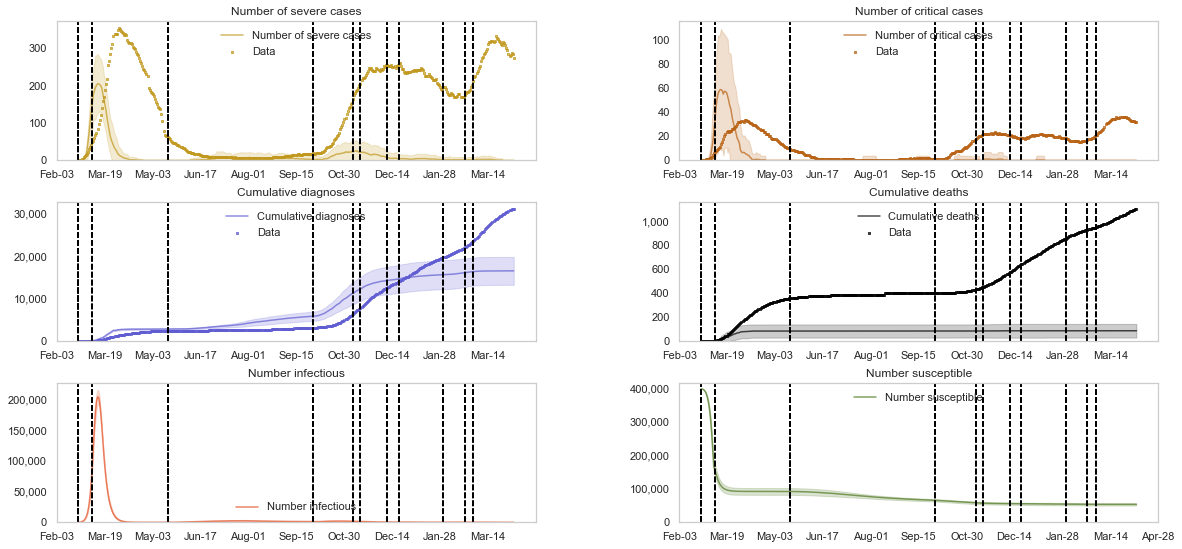

In [21]:
plot_best(study)

## Calibration #5: Incremental Design vs. Space Reduction

At this point, even though we have been able to improve some aspects of the search, it is clear that the optimizer cannot find a correct solution without some external *domain knowledge*. The search often gets stranded on partially or totally wrong areas and continues the exploration in that neighborhood, and in any case the variance in the values of each parameter is quite large even in the top ten-percent trials. This is most probably due to the fact that the *co-dependence* of the parameters is very high, and there can be a lot of ways to reach almost the same solution, therefore the search should be limited to a lower number of parameters and should be guided by experts.

A first workaround that we came up to in order to deceive this problem was to *calibrate each of the three periods incrementally*. This means that we started by calibrating just the parameters related to the initial phase (from the beginning to mid May), from which we extracted some stricter bounds for the parameters that were used to calibrate the summer phase (from mid May to mid september), and the same for the winter phase (from mid September on). Additionally, when calibrating a phase, we gave *higher weights* to the sample of that phase in order to give them a stronger importance. However, even though the final prediction turned out to be somehow better than the previous ones, this method is very slow (three calibrations are needed instead of one) and, among all, strongly influenced by stochastic fluctuations, therefore we abandoned it.

> In the end, we will go for a simple method, that is to use our *\"common sense\" knowledge* to eliminate some parameters and fix stricter bounds to some others. This will allow us to remove some co-dependencies at the expenses of some assumptions which may or not hold exactly.

In particular, we assume that:
* during the *yellow* and *orange* zones, the work contacts are 100%
* during the *yellow* and *orange* zones, the school contacts are the same (jointly learned parameter)
* during the *red* zone there are no casual contacts and no imported cases
* the *viral load* is the same during the whole simulation (*beta* is the only parameter that changes)

As well, we fix stricter bounds for most of the remaining parameters.

In [22]:
def get_calibration_params(trial):
    return dict(
        pop_infected=trial.suggest_int('pop_infected', pop_size // 1e4, pop_size // 1e2, step=5),
        **default_params
    ), dict(
        trace_prob=trial.suggest_float('trace_prob', 0.3, 0.9, step=1e-2),
        trace_time=trial.suggest_float('trace_time', 1.0, 5.0, step=1e-1),
        work_contacts=trial.suggest_float('work_contacts', 0.4, 0.9, step=1e-2),
        school_contacts=trial.suggest_float('school_contacts', 0.2, 0.8, step=1e-2),
        yellow_casual_contacts=trial.suggest_float('yellow_casual_contacts', 0.6, 1.0, step=1e-2),
        orange_casual_contacts=trial.suggest_float('orange_casual_contacts', 0.2, 0.8, step=1e-2),
        init_imports=trial.suggest_float('init_imports', 5.0, 15.0, step=1e-1),
        yellow_imports=trial.suggest_float('yellow_imports', 4.0, 12.0, step=1e-1),
        orange_imports=trial.suggest_float('orange_imports', 2.0, 8.0, step=1e-1),
        init_beta=trial.suggest_float('init_beta', 0.01, 0.02, step=None),
        summer_beta=trial.suggest_float('summer_beta', 0.002, 0.01, step=None),
        winter_beta=trial.suggest_float('winter_beta', 0.01, 0.02, step=None),
        init_symp=trial.suggest_float('init_symp', 0.5, 2.5, log=True),
        init_sev=trial.suggest_float('init_sev', 0.5, 2.0, log=True),
        init_crit=trial.suggest_float('init_crit', 0.5, 2.0, log=True),
        init_death=trial.suggest_float('init_death', 1.5, 4.5, log=True)
    )

We change the constraint ordering tuples accordingly, then we run the optimization.

In [23]:
constraint_orderings = [
    ('yellow_casual_contacts', 'orange_casual_contacts'),
    ('init_imports', 'yellow_imports', 'orange_imports'),
    ('init_beta', 'summer_beta'),
    ('winter_beta', 'summer_beta')
]

def objective(trial):
    # define learnable parameters
    initial_params, intervention_params = get_calibration_params(trial)
    # define and run simulations, then return loss
    intervs = interventions.get_calibration_interventions(intervention_params)
    sim = cv.Sim(pars=initial_params, interventions=intervs, datafile=df)
    msim = cv.MultiSim(sim)
    msim.run(n_runs=3)
    violation = calibration.compute_violation(intervention_params, constraint_orderings)
    mismatches = [s.compute_fit(keys=cols, weights=weights, custom_estimator=estimator).mismatch for s in msim.sims]
    return violation * sum(mismatches) / 3

study = op.create_study()
study.optimize(func=objective, n_trials=n_trials)

[I 2021-04-09 07:15:20,375] A new study created in memory with name: no-name-4686e700-521a-4521-8f60-d637f656277f
[I 2021-04-09 07:15:35,588] Trial 0 finished with value: 2278.38433635679 and parameters: {'pop_infected': 1170, 'trace_prob': 0.52, 'trace_time': 1.1, 'work_contacts': 0.61, 'school_contacts': 0.45, 'yellow_casual_contacts': 0.95, 'orange_casual_contacts': 0.7, 'init_imports': 14.8, 'yellow_imports': 5.8, 'orange_imports': 7.5, 'init_beta': 0.01784988726255022, 'summer_beta': 0.00566884536457244, 'winter_beta': 0.01950222709232421, 'init_symp': 0.79351054026742, 'init_sev': 1.272431702134616, 'init_crit': 0.8144032977317323, 'init_death': 2.4030681768007347}. Best is trial 0 with value: 2278.38433635679.
[I 2021-04-09 07:15:50,495] Trial 1 finished with value: 562.6568313732898 and parameters: {'pop_infected': 1465, 'trace_prob': 0.37, 'trace_time': 3.7, 'work_contacts': 0.5800000000000001, 'school_contacts': 0.51, 'yellow_casual_contacts': 0.88, 'orange_casual_contacts': 

[I 2021-04-09 07:18:31,398] Trial 13 finished with value: 719.0547497191286 and parameters: {'pop_infected': 550, 'trace_prob': 0.42, 'trace_time': 2.2, 'work_contacts': 0.9, 'school_contacts': 0.6000000000000001, 'yellow_casual_contacts': 0.8099999999999999, 'orange_casual_contacts': 0.2, 'init_imports': 11.100000000000001, 'yellow_imports': 7.4, 'orange_imports': 3.3, 'init_beta': 0.012377008797448259, 'summer_beta': 0.0037339317585636657, 'winter_beta': 0.012724379095458977, 'init_symp': 2.244210141445456, 'init_sev': 0.65434228330183, 'init_crit': 1.8389385145558574, 'init_death': 1.8209308262702593}. Best is trial 2 with value: 409.5165213841906.
[I 2021-04-09 07:18:44,243] Trial 14 finished with value: 441.28405479032944 and parameters: {'pop_infected': 2585, 'trace_prob': 0.3, 'trace_time': 1.3, 'work_contacts': 0.73, 'school_contacts': 0.55, 'yellow_casual_contacts': 0.85, 'orange_casual_contacts': 0.33, 'init_imports': 5.2, 'yellow_imports': 4.0, 'orange_imports': 4.2, 'init_b

[I 2021-04-09 07:21:28,648] Trial 26 finished with value: 395.4321697175007 and parameters: {'pop_infected': 60, 'trace_prob': 0.38, 'trace_time': 1.9, 'work_contacts': 0.49, 'school_contacts': 0.37, 'yellow_casual_contacts': 0.99, 'orange_casual_contacts': 0.25, 'init_imports': 8.9, 'yellow_imports': 5.3, 'orange_imports': 2.6, 'init_beta': 0.01026198360151438, 'summer_beta': 0.0038783459506599276, 'winter_beta': 0.01584191783516857, 'init_symp': 1.1776124999584094, 'init_sev': 0.7349235591430923, 'init_crit': 0.5839793826522651, 'init_death': 1.965351164913047}. Best is trial 26 with value: 395.4321697175007.
[I 2021-04-09 07:21:41,366] Trial 27 finished with value: 540.3628868401355 and parameters: {'pop_infected': 105, 'trace_prob': 0.47, 'trace_time': 2.2, 'work_contacts': 0.46, 'school_contacts': 0.29000000000000004, 'yellow_casual_contacts': 1.0, 'orange_casual_contacts': 0.24000000000000002, 'init_imports': 10.2, 'yellow_imports': 5.2, 'orange_imports': 2.4, 'init_beta': 0.0100

[I 2021-04-09 07:24:18,523] Trial 39 finished with value: 795.7735195531237 and parameters: {'pop_infected': 505, 'trace_prob': 0.51, 'trace_time': 1.6, 'work_contacts': 0.4, 'school_contacts': 0.26, 'yellow_casual_contacts': 0.8999999999999999, 'orange_casual_contacts': 0.23, 'init_imports': 10.3, 'yellow_imports': 6.6, 'orange_imports': 3.5, 'init_beta': 0.0115185405802648, 'summer_beta': 0.0060705423168836955, 'winter_beta': 0.0176514393350203, 'init_symp': 1.0164866851800114, 'init_sev': 0.5963253563982808, 'init_crit': 0.8046168512111906, 'init_death': 2.1739276898365785}. Best is trial 31 with value: 390.07352930856615.
[I 2021-04-09 07:24:33,188] Trial 40 finished with value: 668.2237286874903 and parameters: {'pop_infected': 255, 'trace_prob': 0.39, 'trace_time': 1.3, 'work_contacts': 0.46, 'school_contacts': 0.43000000000000005, 'yellow_casual_contacts': 0.99, 'orange_casual_contacts': 0.36, 'init_imports': 9.600000000000001, 'yellow_imports': 9.100000000000001, 'orange_import

[I 2021-04-09 07:27:16,060] Trial 52 finished with value: 410.15245110174584 and parameters: {'pop_infected': 225, 'trace_prob': 0.62, 'trace_time': 2.0, 'work_contacts': 0.43000000000000005, 'school_contacts': 0.28, 'yellow_casual_contacts': 0.86, 'orange_casual_contacts': 0.33, 'init_imports': 7.7, 'yellow_imports': 6.9, 'orange_imports': 2.7, 'init_beta': 0.011105244105484757, 'summer_beta': 0.005938947748922214, 'winter_beta': 0.01730578459295421, 'init_symp': 1.5647217089847358, 'init_sev': 0.5000769783175031, 'init_crit': 0.6882856101452487, 'init_death': 1.7450186466472253}. Best is trial 31 with value: 390.07352930856615.
[I 2021-04-09 07:27:28,324] Trial 53 finished with value: 476.91291210322703 and parameters: {'pop_infected': 45, 'trace_prob': 0.78, 'trace_time': 1.4, 'work_contacts': 0.47000000000000003, 'school_contacts': 0.37, 'yellow_casual_contacts': 0.9299999999999999, 'orange_casual_contacts': 0.29000000000000004, 'init_imports': 8.5, 'yellow_imports': 5.5, 'orange_i

[I 2021-04-09 07:30:09,703] Trial 65 finished with value: 835.7448432606197 and parameters: {'pop_infected': 3370, 'trace_prob': 0.72, 'trace_time': 2.1, 'work_contacts': 0.42000000000000004, 'school_contacts': 0.51, 'yellow_casual_contacts': 0.9299999999999999, 'orange_casual_contacts': 0.29000000000000004, 'init_imports': 12.4, 'yellow_imports': 5.0, 'orange_imports': 2.5, 'init_beta': 0.011338687366161965, 'summer_beta': 0.005655472575205361, 'winter_beta': 0.01620985883353312, 'init_symp': 1.09321464539442, 'init_sev': 0.6513159421039764, 'init_crit': 1.0257880135119262, 'init_death': 1.8550548379470275}. Best is trial 57 with value: 373.03368155290053.
[I 2021-04-09 07:30:24,016] Trial 66 finished with value: 443.3738121271488 and parameters: {'pop_infected': 185, 'trace_prob': 0.69, 'trace_time': 1.9, 'work_contacts': 0.48000000000000004, 'school_contacts': 0.48000000000000004, 'yellow_casual_contacts': 1.0, 'orange_casual_contacts': 0.25, 'init_imports': 9.2, 'yellow_imports': 6

[I 2021-04-09 07:32:59,979] Trial 78 finished with value: 603.7654997127614 and parameters: {'pop_infected': 670, 'trace_prob': 0.8700000000000001, 'trace_time': 3.0, 'work_contacts': 0.45, 'school_contacts': 0.39, 'yellow_casual_contacts': 0.78, 'orange_casual_contacts': 0.35, 'init_imports': 8.3, 'yellow_imports': 5.0, 'orange_imports': 2.4, 'init_beta': 0.012043786703330459, 'summer_beta': 0.002877428710004292, 'winter_beta': 0.01846968960912845, 'init_symp': 0.8845872320698925, 'init_sev': 0.544716696054954, 'init_crit': 1.0254139004460503, 'init_death': 2.4136397390345823}. Best is trial 72 with value: 371.4699829391284.
[I 2021-04-09 07:33:12,639] Trial 79 finished with value: 426.49570155102293 and parameters: {'pop_infected': 480, 'trace_prob': 0.8300000000000001, 'trace_time': 3.1, 'work_contacts': 0.47000000000000003, 'school_contacts': 0.44, 'yellow_casual_contacts': 0.6699999999999999, 'orange_casual_contacts': 0.30000000000000004, 'init_imports': 8.8, 'yellow_imports': 5.8

[I 2021-04-09 07:35:55,593] Trial 91 finished with value: 413.36423967173124 and parameters: {'pop_infected': 375, 'trace_prob': 0.8799999999999999, 'trace_time': 2.2, 'work_contacts': 0.45, 'school_contacts': 0.35, 'yellow_casual_contacts': 0.97, 'orange_casual_contacts': 0.30000000000000004, 'init_imports': 8.5, 'yellow_imports': 6.1, 'orange_imports': 3.0, 'init_beta': 0.011017807369444868, 'summer_beta': 0.0040436221889062225, 'winter_beta': 0.01724644340056251, 'init_symp': 1.0321369371988616, 'init_sev': 0.5942943625229042, 'init_crit': 0.8245546301964395, 'init_death': 2.0544757591267904}. Best is trial 72 with value: 371.4699829391284.
[I 2021-04-09 07:36:08,420] Trial 92 finished with value: 373.22215758691 and parameters: {'pop_infected': 610, 'trace_prob': 0.8899999999999999, 'trace_time': 2.3, 'work_contacts': 0.4, 'school_contacts': 0.38, 'yellow_casual_contacts': 0.97, 'orange_casual_contacts': 0.32, 'init_imports': 8.3, 'yellow_imports': 6.6, 'orange_imports': 2.8, 'init

[I 2021-04-09 07:38:48,801] Trial 104 finished with value: 369.9023802090331 and parameters: {'pop_infected': 220, 'trace_prob': 0.77, 'trace_time': 2.2, 'work_contacts': 0.47000000000000003, 'school_contacts': 0.4, 'yellow_casual_contacts': 0.8899999999999999, 'orange_casual_contacts': 0.43000000000000005, 'init_imports': 10.3, 'yellow_imports': 6.4, 'orange_imports': 2.5, 'init_beta': 0.012970364043305531, 'summer_beta': 0.0045161554973715354, 'winter_beta': 0.016153912355073546, 'init_symp': 1.6194761002428153, 'init_sev': 0.9259134301284728, 'init_crit': 0.9040616631171051, 'init_death': 3.5286731160578175}. Best is trial 103 with value: 353.8039693842954.
[I 2021-04-09 07:39:03,595] Trial 105 finished with value: 967.4335600220851 and parameters: {'pop_infected': 3995, 'trace_prob': 0.78, 'trace_time': 2.2, 'work_contacts': 0.53, 'school_contacts': 0.41000000000000003, 'yellow_casual_contacts': 0.9099999999999999, 'orange_casual_contacts': 0.45, 'init_imports': 10.4, 'yellow_impor

[I 2021-04-09 07:41:44,164] Trial 117 finished with value: 400.9351283666094 and parameters: {'pop_infected': 200, 'trace_prob': 0.8200000000000001, 'trace_time': 2.3, 'work_contacts': 0.49, 'school_contacts': 0.42000000000000004, 'yellow_casual_contacts': 0.86, 'orange_casual_contacts': 0.43000000000000005, 'init_imports': 10.7, 'yellow_imports': 8.2, 'orange_imports': 2.6, 'init_beta': 0.012983076199800225, 'summer_beta': 0.004481224613708276, 'winter_beta': 0.01686676037470647, 'init_symp': 1.7430840079637502, 'init_sev': 1.083951187406177, 'init_crit': 0.8595766936036663, 'init_death': 3.796443063094315}. Best is trial 103 with value: 353.8039693842954.
[I 2021-04-09 07:41:56,702] Trial 118 finished with value: 445.57793438420526 and parameters: {'pop_infected': 405, 'trace_prob': 0.8, 'trace_time': 1.9, 'work_contacts': 0.48000000000000004, 'school_contacts': 0.39, 'yellow_casual_contacts': 0.82, 'orange_casual_contacts': 0.47000000000000003, 'init_imports': 9.9, 'yellow_imports':

[I 2021-04-09 07:44:41,712] Trial 130 finished with value: 376.3224126437597 and parameters: {'pop_infected': 45, 'trace_prob': 0.73, 'trace_time': 2.0, 'work_contacts': 0.48000000000000004, 'school_contacts': 0.56, 'yellow_casual_contacts': 0.88, 'orange_casual_contacts': 0.51, 'init_imports': 9.8, 'yellow_imports': 6.800000000000001, 'orange_imports': 2.5, 'init_beta': 0.013790300137584782, 'summer_beta': 0.006122261658009495, 'winter_beta': 0.015385759099398228, 'init_symp': 1.53540429695253, 'init_sev': 0.9406020434400335, 'init_crit': 0.6878155205124056, 'init_death': 3.21442928230048}. Best is trial 120 with value: 350.1457271262939.
[I 2021-04-09 07:44:56,932] Trial 131 finished with value: 419.38371068209653 and parameters: {'pop_infected': 185, 'trace_prob': 0.6799999999999999, 'trace_time': 1.9, 'work_contacts': 0.5, 'school_contacts': 0.48000000000000004, 'yellow_casual_contacts': 0.88, 'orange_casual_contacts': 0.56, 'init_imports': 10.8, 'yellow_imports': 7.0, 'orange_impo

[I 2021-04-09 07:47:35,348] Trial 143 finished with value: 366.0478014081075 and parameters: {'pop_infected': 145, 'trace_prob': 0.77, 'trace_time': 1.7000000000000002, 'work_contacts': 0.5, 'school_contacts': 0.54, 'yellow_casual_contacts': 0.9299999999999999, 'orange_casual_contacts': 0.44, 'init_imports': 9.3, 'yellow_imports': 6.4, 'orange_imports': 2.0, 'init_beta': 0.013738763295034068, 'summer_beta': 0.00473889549586977, 'winter_beta': 0.016038500184346122, 'init_symp': 1.3546898882802936, 'init_sev': 0.9337398656094886, 'init_crit': 0.8232010409162944, 'init_death': 4.101117025888926}. Best is trial 120 with value: 350.1457271262939.
[I 2021-04-09 07:47:49,092] Trial 144 finished with value: 395.4805818702186 and parameters: {'pop_infected': 165, 'trace_prob': 0.76, 'trace_time': 1.6, 'work_contacts': 0.51, 'school_contacts': 0.52, 'yellow_casual_contacts': 0.8899999999999999, 'orange_casual_contacts': 0.44, 'init_imports': 9.3, 'yellow_imports': 6.2, 'orange_imports': 2.0, 'in

[I 2021-04-09 07:50:32,689] Trial 156 finished with value: 405.49434147022026 and parameters: {'pop_infected': 105, 'trace_prob': 0.72, 'trace_time': 2.1, 'work_contacts': 0.5, 'school_contacts': 0.47000000000000003, 'yellow_casual_contacts': 0.9099999999999999, 'orange_casual_contacts': 0.42000000000000004, 'init_imports': 11.9, 'yellow_imports': 6.6, 'orange_imports': 2.1, 'init_beta': 0.013550323616291325, 'summer_beta': 0.005100455596348906, 'winter_beta': 0.0150800531986803, 'init_symp': 1.5457071545305492, 'init_sev': 1.063488391893244, 'init_crit': 0.6932655006046, 'init_death': 3.597708298394391}. Best is trial 120 with value: 350.1457271262939.
[I 2021-04-09 07:50:45,325] Trial 157 finished with value: 375.0592927448836 and parameters: {'pop_infected': 45, 'trace_prob': 0.75, 'trace_time': 1.5, 'work_contacts': 0.51, 'school_contacts': 0.52, 'yellow_casual_contacts': 0.87, 'orange_casual_contacts': 0.4, 'init_imports': 9.8, 'yellow_imports': 7.1, 'orange_imports': 2.3, 'init_b

[I 2021-04-09 07:53:24,901] Trial 169 finished with value: 487.72735957839905 and parameters: {'pop_infected': 380, 'trace_prob': 0.71, 'trace_time': 1.8, 'work_contacts': 0.52, 'school_contacts': 0.49, 'yellow_casual_contacts': 0.9199999999999999, 'orange_casual_contacts': 0.53, 'init_imports': 9.9, 'yellow_imports': 6.5, 'orange_imports': 2.4, 'init_beta': 0.014191121844705869, 'summer_beta': 0.005528441347104438, 'winter_beta': 0.015389278338625544, 'init_symp': 1.377805607927311, 'init_sev': 0.9675534539414863, 'init_crit': 0.606747328140947, 'init_death': 3.4061959410750937}. Best is trial 120 with value: 350.1457271262939.
[I 2021-04-09 07:53:38,757] Trial 170 finished with value: 417.48318136585084 and parameters: {'pop_infected': 45, 'trace_prob': 0.75, 'trace_time': 1.4, 'work_contacts': 0.55, 'school_contacts': 0.47000000000000003, 'yellow_casual_contacts': 0.94, 'orange_casual_contacts': 0.46, 'init_imports': 10.2, 'yellow_imports': 7.2, 'orange_imports': 2.0, 'init_beta': 0

[I 2021-04-09 07:56:19,257] Trial 182 finished with value: 371.68516278068495 and parameters: {'pop_infected': 195, 'trace_prob': 0.73, 'trace_time': 1.6, 'work_contacts': 0.53, 'school_contacts': 0.48000000000000004, 'yellow_casual_contacts': 0.9099999999999999, 'orange_casual_contacts': 0.45, 'init_imports': 10.5, 'yellow_imports': 6.5, 'orange_imports': 2.1, 'init_beta': 0.013160330806898435, 'summer_beta': 0.0048362545376671225, 'winter_beta': 0.01581907627363969, 'init_symp': 1.448340598024549, 'init_sev': 0.8791508518033236, 'init_crit': 0.6984098568433095, 'init_death': 4.30225206022}. Best is trial 120 with value: 350.1457271262939.
[I 2021-04-09 07:56:32,113] Trial 183 finished with value: 415.3367242268966 and parameters: {'pop_infected': 125, 'trace_prob': 0.76, 'trace_time': 1.6, 'work_contacts': 0.8400000000000001, 'school_contacts': 0.49, 'yellow_casual_contacts': 0.9099999999999999, 'orange_casual_contacts': 0.41000000000000003, 'init_imports': 10.100000000000001, 'yello

[I 2021-04-09 07:59:16,603] Trial 195 finished with value: 720.2698061324927 and parameters: {'pop_infected': 265, 'trace_prob': 0.71, 'trace_time': 1.7000000000000002, 'work_contacts': 0.52, 'school_contacts': 0.47000000000000003, 'yellow_casual_contacts': 0.9099999999999999, 'orange_casual_contacts': 0.47000000000000003, 'init_imports': 13.9, 'yellow_imports': 7.4, 'orange_imports': 5.0, 'init_beta': 0.014248570709947336, 'summer_beta': 0.004420240755811906, 'winter_beta': 0.01581631873781953, 'init_symp': 1.4527752127076636, 'init_sev': 1.0068436294911491, 'init_crit': 0.7748045681883916, 'init_death': 3.4487612311639553}. Best is trial 120 with value: 350.1457271262939.
[I 2021-04-09 07:59:28,832] Trial 196 finished with value: 360.86891159420526 and parameters: {'pop_infected': 110, 'trace_prob': 0.78, 'trace_time': 2.0, 'work_contacts': 0.49, 'school_contacts': 0.54, 'yellow_casual_contacts': 0.8899999999999999, 'orange_casual_contacts': 0.41000000000000003, 'init_imports': 10.60

[I 2021-04-09 08:02:05,250] Trial 208 finished with value: 389.52767923931106 and parameters: {'pop_infected': 40, 'trace_prob': 0.8, 'trace_time': 2.2, 'work_contacts': 0.46, 'school_contacts': 0.51, 'yellow_casual_contacts': 0.79, 'orange_casual_contacts': 0.38, 'init_imports': 9.9, 'yellow_imports': 7.300000000000001, 'orange_imports': 2.1, 'init_beta': 0.012724421478090314, 'summer_beta': 0.0048337291959496525, 'winter_beta': 0.01630872753384103, 'init_symp': 1.4319653540386963, 'init_sev': 1.0261827129784042, 'init_crit': 0.7522273276013666, 'init_death': 3.999265731772299}. Best is trial 120 with value: 350.1457271262939.
[I 2021-04-09 08:02:18,847] Trial 209 finished with value: 356.54268012969874 and parameters: {'pop_infected': 120, 'trace_prob': 0.79, 'trace_time': 1.9, 'work_contacts': 0.5, 'school_contacts': 0.45, 'yellow_casual_contacts': 0.8999999999999999, 'orange_casual_contacts': 0.49, 'init_imports': 10.4, 'yellow_imports': 6.6, 'orange_imports': 2.4, 'init_beta': 0.0

[I 2021-04-09 08:04:58,834] Trial 221 finished with value: 378.0764345325151 and parameters: {'pop_infected': 225, 'trace_prob': 0.8, 'trace_time': 1.8, 'work_contacts': 0.5, 'school_contacts': 0.49, 'yellow_casual_contacts': 0.75, 'orange_casual_contacts': 0.48000000000000004, 'init_imports': 10.7, 'yellow_imports': 6.300000000000001, 'orange_imports': 2.3, 'init_beta': 0.012879463599657555, 'summer_beta': 0.003920024929613898, 'winter_beta': 0.016040802066506092, 'init_symp': 1.5674852062702493, 'init_sev': 0.9537094383632815, 'init_crit': 0.6740792146455199, 'init_death': 3.739514369857132}. Best is trial 120 with value: 350.1457271262939.
[I 2021-04-09 08:05:11,287] Trial 222 finished with value: 379.2961319675134 and parameters: {'pop_infected': 110, 'trace_prob': 0.81, 'trace_time': 2.0, 'work_contacts': 0.52, 'school_contacts': 0.47000000000000003, 'yellow_casual_contacts': 0.63, 'orange_casual_contacts': 0.51, 'init_imports': 10.4, 'yellow_imports': 6.1, 'orange_imports': 2.4, 

[I 2021-04-09 08:07:55,011] Trial 234 finished with value: 359.23296934843853 and parameters: {'pop_infected': 130, 'trace_prob': 0.8500000000000001, 'trace_time': 1.7000000000000002, 'work_contacts': 0.53, 'school_contacts': 0.55, 'yellow_casual_contacts': 0.88, 'orange_casual_contacts': 0.46, 'init_imports': 11.0, 'yellow_imports': 6.7, 'orange_imports': 2.6, 'init_beta': 0.014455404821212825, 'summer_beta': 0.0037853931629477033, 'winter_beta': 0.014558135139362143, 'init_symp': 2.11396533828167, 'init_sev': 1.0986904505870616, 'init_crit': 0.7466982108369032, 'init_death': 3.470315107115687}. Best is trial 226 with value: 346.15545079308777.
[I 2021-04-09 08:08:09,673] Trial 235 finished with value: 363.8408324158013 and parameters: {'pop_infected': 265, 'trace_prob': 0.8700000000000001, 'trace_time': 1.7000000000000002, 'work_contacts': 0.54, 'school_contacts': 0.55, 'yellow_casual_contacts': 0.88, 'orange_casual_contacts': 0.48000000000000004, 'init_imports': 11.100000000000001, 

[I 2021-04-09 08:10:47,254] Trial 247 finished with value: 828.4048596526659 and parameters: {'pop_infected': 1340, 'trace_prob': 0.8600000000000001, 'trace_time': 1.7000000000000002, 'work_contacts': 0.51, 'school_contacts': 0.5700000000000001, 'yellow_casual_contacts': 0.8899999999999999, 'orange_casual_contacts': 0.5, 'init_imports': 11.2, 'yellow_imports': 7.1, 'orange_imports': 2.2, 'init_beta': 0.014101978455942488, 'summer_beta': 0.004447810001158944, 'winter_beta': 0.015477446612003062, 'init_symp': 2.2352422034926875, 'init_sev': 1.1605483090016249, 'init_crit': 0.7338944937916609, 'init_death': 3.4617085732283828}. Best is trial 226 with value: 346.15545079308777.
[I 2021-04-09 08:11:00,225] Trial 248 finished with value: 364.2759709653921 and parameters: {'pop_infected': 165, 'trace_prob': 0.73, 'trace_time': 1.9, 'work_contacts': 0.51, 'school_contacts': 0.5700000000000001, 'yellow_casual_contacts': 0.8999999999999999, 'orange_casual_contacts': 0.49, 'init_imports': 10.6000

[I 2021-04-09 08:13:45,478] Trial 260 finished with value: 398.98503433968403 and parameters: {'pop_infected': 220, 'trace_prob': 0.8400000000000001, 'trace_time': 1.9, 'work_contacts': 0.52, 'school_contacts': 0.54, 'yellow_casual_contacts': 0.8999999999999999, 'orange_casual_contacts': 0.48000000000000004, 'init_imports': 10.9, 'yellow_imports': 6.5, 'orange_imports': 2.5, 'init_beta': 0.013194721832445465, 'summer_beta': 0.0042112365214352025, 'winter_beta': 0.015582476970646861, 'init_symp': 1.4899881373060262, 'init_sev': 1.169126040034396, 'init_crit': 0.696429588768162, 'init_death': 3.264430074969612}. Best is trial 226 with value: 346.15545079308777.
[I 2021-04-09 08:13:57,896] Trial 261 finished with value: 412.36087165304133 and parameters: {'pop_infected': 330, 'trace_prob': 0.76, 'trace_time': 2.1, 'work_contacts': 0.54, 'school_contacts': 0.46, 'yellow_casual_contacts': 0.9099999999999999, 'orange_casual_contacts': 0.42000000000000004, 'init_imports': 10.5, 'yellow_import

[I 2021-04-09 08:16:35,442] Trial 273 finished with value: 393.7286176516715 and parameters: {'pop_infected': 320, 'trace_prob': 0.75, 'trace_time': 1.9, 'work_contacts': 0.47000000000000003, 'school_contacts': 0.5, 'yellow_casual_contacts': 0.87, 'orange_casual_contacts': 0.48000000000000004, 'init_imports': 10.4, 'yellow_imports': 6.2, 'orange_imports': 2.2, 'init_beta': 0.01332941664803733, 'summer_beta': 0.004352647960916203, 'winter_beta': 0.01585816420175736, 'init_symp': 2.078142882986593, 'init_sev': 0.9531996746566541, 'init_crit': 0.7033299478080827, 'init_death': 3.4313324715508156}. Best is trial 226 with value: 346.15545079308777.
[I 2021-04-09 08:16:49,188] Trial 274 finished with value: 367.2959386012555 and parameters: {'pop_infected': 100, 'trace_prob': 0.74, 'trace_time': 2.1, 'work_contacts': 0.48000000000000004, 'school_contacts': 0.48000000000000004, 'yellow_casual_contacts': 0.8999999999999999, 'orange_casual_contacts': 0.51, 'init_imports': 10.0, 'yellow_imports'

[I 2021-04-09 08:19:32,443] Trial 286 finished with value: 483.9986364218271 and parameters: {'pop_infected': 255, 'trace_prob': 0.59, 'trace_time': 2.1, 'work_contacts': 0.45, 'school_contacts': 0.56, 'yellow_casual_contacts': 0.9099999999999999, 'orange_casual_contacts': 0.54, 'init_imports': 11.2, 'yellow_imports': 6.300000000000001, 'orange_imports': 2.0, 'init_beta': 0.012510158406242696, 'summer_beta': 0.00395367388593269, 'winter_beta': 0.01624948367625202, 'init_symp': 1.4456771041667142, 'init_sev': 0.748758610460787, 'init_crit': 0.6744680375111054, 'init_death': 3.384942083973317}. Best is trial 226 with value: 346.15545079308777.
[I 2021-04-09 08:19:45,059] Trial 287 finished with value: 364.673095095315 and parameters: {'pop_infected': 45, 'trace_prob': 0.5800000000000001, 'trace_time': 2.0, 'work_contacts': 0.5, 'school_contacts': 0.55, 'yellow_casual_contacts': 0.9299999999999999, 'orange_casual_contacts': 0.51, 'init_imports': 10.7, 'yellow_imports': 6.7, 'orange_import

[I 2021-04-09 08:22:27,048] Trial 299 finished with value: 388.9008994188225 and parameters: {'pop_infected': 105, 'trace_prob': 0.72, 'trace_time': 2.2, 'work_contacts': 0.48000000000000004, 'school_contacts': 0.53, 'yellow_casual_contacts': 0.8999999999999999, 'orange_casual_contacts': 0.49, 'init_imports': 10.5, 'yellow_imports': 7.300000000000001, 'orange_imports': 2.3, 'init_beta': 0.013851025559658272, 'summer_beta': 0.005161463645445435, 'winter_beta': 0.015441850563311033, 'init_symp': 1.6972314102568469, 'init_sev': 1.064963504104177, 'init_crit': 0.7285372576134115, 'init_death': 3.3564006892845595}. Best is trial 226 with value: 346.15545079308777.


As usual, we inspect the results...

In [24]:
calibration.inspect_study(study, top=0.1)[1]

,count,min,max,mean,median,std,best
objective,30,346.155451,363.183602,357.616672,359.291120,4.704516,346.155451
pop_infected,30,50.000000,235.000000,137.000000,120.000000,41.306257,160.000000
trace_prob,30,0.580000,0.850000,0.776333,0.790000,0.062504,0.820000
trace_time,30,1.600000,2.200000,1.883333,1.850000,0.151050,1.800000
work_contacts,30,0.460000,0.640000,0.510667,0.510000,0.030954,0.510000
school_contacts,30,0.420000,0.570000,0.503333,0.515000,0.042938,0.520000
yellow_casual_contacts,30,0.750000,0.940000,0.890000,0.900000,0.039304,0.880000
orange_casual_contacts,30,0.380000,0.520000,0.463333,0.470000,0.039158,0.470000
init_imports,30,9.300000,11.200000,10.433333,10.400000,0.447471,10.600000
yellow_imports,30,6.300000,7.600000,6.760000,6.700000,0.321205,6.400000


... and plot the outcomes of the best configuration.

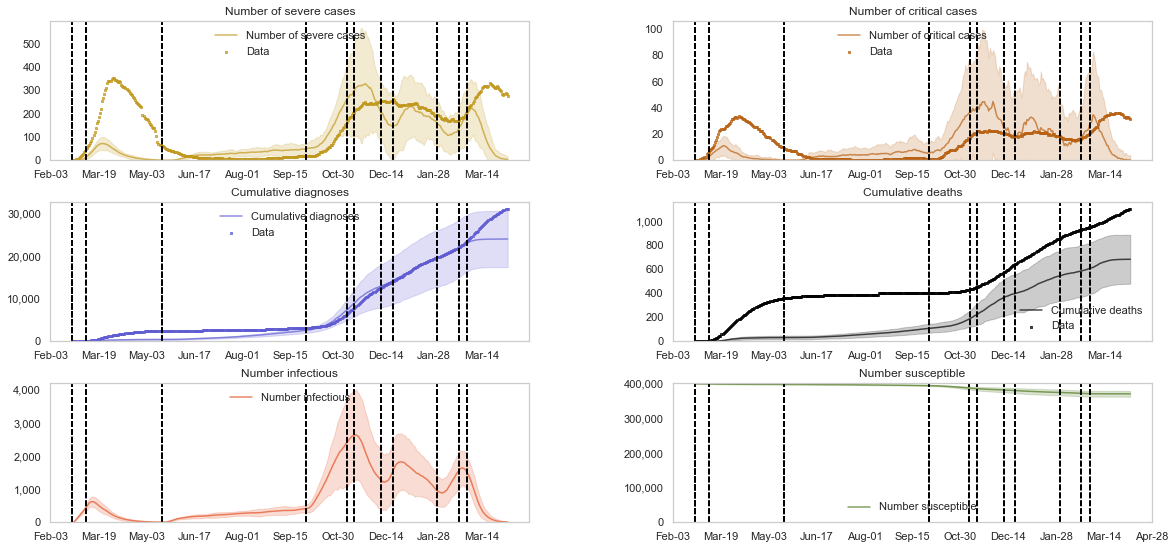

In [25]:
plot_best(study)

## Final Parameters

Eventually, as to have more trustworthy results, we get rid of the *pop_scale* parameter and fix the number of agents as the total number of individuals in the population, i.e., *400k*. 

In order to maximize the fitness to the curve, we performed some *manual tuning* on the parameters to adjust some flawed values. The final outcome is stored in the `parameters.json` file, which contains two dictionaries: one for the initial and one for the intervention parameters.

In [26]:
def plot_outcome():
    intervs = interventions.get_calibration_interventions(intervention_params)
    sim = cv.Sim(pars=initial_params, interventions=intervs, datafile=df)
    msim = cv.MultiSim(sim)
    msim.run(n_runs=30)
    msim.mean()
    msim.plot(
        list(cols) + ['n_infectious', 'n_susceptible'],
        fig_args={'figsize': (18, 8)},
        scatter_args={'s': 5},
        plot_args={'lw': 2},
        interval=45
    )

with open('../res/parameters.json', 'r') as json_file:
  j = json.load(json_file)

intervention_params = j['intervention_params']
initial_params = j['initial_params']
initial_params['end_day'] = df['date'].iloc[-1]

In [27]:
pd.Series({**initial_params, **intervention_params})

pop_type                      hybrid
location                       italy
start_day                 2020-02-24
pop_size                      400000
pop_infected                     720
n_beds_hosp                   1481.6
n_beds_icu                     57.84
quar_period                       14
verbose                            0
end_day                   2021-04-08
household_trace_prob             1.0
household_trace_time             0.0
school_trace_prob               0.55
school_trace_time                2.8
work_trace_prob                 0.55
work_trace_time                  2.8
casual_trace_prob                0.0
casual_trace_time                0.0
init_work_contacts               1.0
summer_work_contacts             1.0
yellow_work_contacts             1.0
orange_work_contacts             1.0
red_work_contacts               0.67
init_school_contacts             1.0
summer_school_contacts           0.0
yellow_school_contacts          0.55
orange_school_contacts          0.55
r

And here is the final outcome *:)*

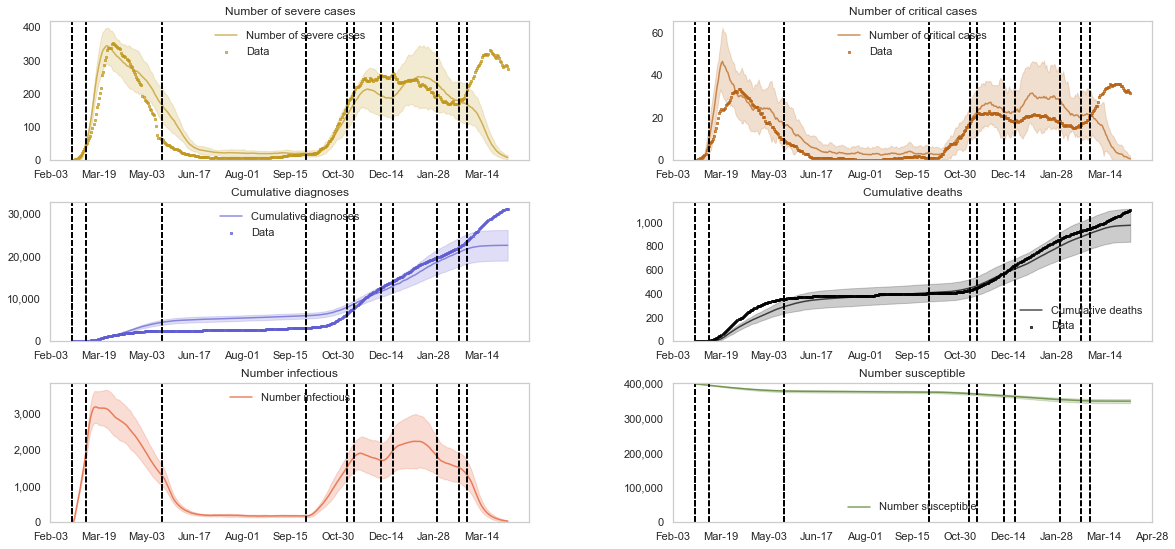

In [28]:
plot_outcome()